### Returns을 찍어보자

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from statsmodels.api import OLS, add_constant
from scipy.stats import stats
from tqdm import tqdm

In [2]:
#mktcap = pd.read_pickle("ryu_mktcap.pickle")
#price  = pd.read_pickle("ryu_price.pickle")

In [2]:
#mktcap = pd.read_pickle("mktcap_vol_screnned.pickle")
#price  = pd.read_pickle("price_vol_screnned.pickle")

In [8]:
mktcap = pd.read_pickle("ryu_new_mktcap9.pickle")
price  = pd.read_pickle("ryu_new_price9.pickle")
vol = pd.read_pickle("ryu_new_volume9.pickle")

mktcap_pp = (vol > 0).replace(False,np.nan) * mktcap

모든 수익률, MDD 등 평가는 Daily로 변환해서 이뤄질거임 -> 너무나 당연한 것

In [4]:
class CrossSection:
    def __init__(self, price_df:pd.DataFrame, mktcap_df:pd.DataFrame, freq:str):
        '''freq(str) : [daily, 3days, weekly]'''
        self.__map_dict = {"daily" :[1, None],
                           "weekly":[7, "W"] }
        self.__freq_str = freq
        
        self.__daily_index = price_df.index
        self.__daily_columns = price_df.columns
        
        self.__price_daily = price_df.copy()
        self.__rtn_daily = np.sign(self.__price_daily) * price_df.pct_change(fill_method=None) # 코드 개선(sign 추가)
        self.__mktcap_daily = mktcap_df.copy()
        self.__mktcap_pp = self.__preprocess_mktcap()
        self.__rtn_pp = self.__preprocess_price()
        
    def __preprocess_price(self):
        '''Weekly로 Resample하는데 사용함 ,
           pct_change 리턴'''
        price = self.__price_daily
        pct = price.pct_change(self.__map_dict[self.__freq_str][0], fill_method=None)
        if self.__freq_str == "daily":
            pass
        else:
            pct = pct.resample(self.__map_dict[self.__freq_str][1]) \
                     .first()
            price_pp = price.resample(self.__map_dict[self.__freq_str][1]) \
                         .first()
            self.__price_pp = price_pp #뒤에서 코인 개수 구하기 위해서 사용함
        sign = np.sign(price.loc[pct.index[:-1]]) #  이렇게 인덱스만 빼와서 sign을 해줄 수 있겠군
        rtn = pct * sign   
        return rtn
    
    def __preprocess_mktcap(self):
        '''Weekly로 Resample하는데 사용함'''
        mktcap = self.__mktcap_daily
        if self.__freq_str == "daily":
            pass
        else:
            mktcap = mktcap.resample(self.__map_dict[self.__freq_str][1])\
                           .first()
        return mktcap
    
    def calculate_cagr(self, return_df):
        '''rtn을 받았을 때, CAGR을 계산합니다'''
        #scaler = self.mapping_scaler[self.__freq_str]
        holding_year = (len(return_df) / 365)
        cum = (return_df+1).cumprod()
        cagr = (cum.iloc[-1] / cum.iloc[0]) ** (1/holding_year) -1
        return cagr
    
    def mkt_index(self):
        '''시총가중평균 mkt_index를 반환한다'''
        # rtn, mktcap 둘다 daily자료 사용
        rtn = self.__rtn_daily
        mktcap = self.__mktcap_daily
        weight = mktcap.apply(lambda x: x / np.nansum(x), axis=1)
        return (rtn* weight).sum(axis=1).iloc[:-1]
        
    def q_momentum(self, q:str, num_of_coin:int, return_num = False):
        '''Q(str) : "3" 3분위, "5" 5분위 
           num_of_coin : 그룹당 최소 코인 수 
           return_num : 그룹별 코인수를 리턴할지(default : False)'''
        mktcap_pp = self.__mktcap_pp
        rtn_pp = self.__rtn_pp
        rtn_daily = self.__rtn_daily
        price_daily = self.__price_daily
        self.__return_num = return_num
        
        q_map = {"5":[0.2, 0.4, 0.6, 0.8],
                 "3":[1/3, 2/3]}
        
        # 모멘텀 별로 그룹을 나누기 위한 thresh를 설정해 줍시다
        thresh = rtn_pp.apply(lambda x: np.nanquantile(x,q_map[q]),
                           axis=1)
        sum_dict = {}
        weight_dict = {}
        # 모멘텀 그룹별로 분리해주는 Masking dataframe을 생성해줍니다
        for i in tqdm(range(0, len(q_map[q]) + 1)):  
            if i == 0: # 첫번째 분위수 계산
                thr = thresh.apply(lambda x: x[i])
                filter_df = rtn_pp.apply(lambda x: x <= thr, axis=0) \
                           .replace({True:1, False:np.nan})
            elif i == (len(q_map[q])): # 마지막 분위수 계산
                thr = thresh.apply(lambda x: x[i-1])
                filter_df = rtn_pp.apply(lambda x: x > thr, axis=0) \
                          .replace({True:1, False:np.nan})
            else: # 가운데인 경우
                thr = thresh.apply(lambda x: x[i-1])
                thr2 = thresh.apply(lambda x: x[i])
                filter_df = rtn_pp.apply(lambda x: (thr < x) & (x <= thr2), axis=0) \
                            .replace({True:1, False:np.nan})       
            
            sum_dict[str(i)] = filter_df.sum(1)
            weight = (filter_df * mktcap_pp).apply(lambda x: x / np.nansum(x), axis=1)
            weight_dict[str(i)] = weight     
        
        num_coin = pd.concat(sum_dict, axis=1)        
        slice = num_coin[num_coin >= num_of_coin].dropna(axis=0)
        self.__start_date = slice.index[0]
        print("{}에서부터 수익률을 계산".format(self.__start_date))
        
        # 여기서부터 수정이 들어가야함
        ## 코인 개수를 구해야함 weight만큼 코인을 사는데, 초기 포폴 가치가 1일 때의 구입량을 구하고, 
        ## 구입량 * price가 그 시점 포폴 가치임...
        
        return_dict = {}
        daily_rtn = {}
        
        if self.__freq_str == "daily": # Daily rebalancing 하는 경우 -> 그냥 매일 weight구해서 리밸런싱하면됨
            for i in tqdm(range(len(weight_dict.keys()))):
                group_rtn = (weight_dict[str(i)].shift(1) * rtn_daily).loc[self.__start_date:].iloc[:-1].sum(1)
                return_dict["Q" + str(i+1)] = group_rtn
                daily_rtn["Q"+str(i+1)] = (weight_dict[str(i)] * rtn_daily).loc[self.__start_date:].iloc[:-1].sum(1)
        else: # 주단위 Rebalancing 하는 경우
            for i in tqdm(range(len(weight_dict.keys()))):
                
                # 주단위 포폴 리턴이 됨 
                price_pp = self.__price_pp
                pf_weekly_value = ((rtn_pp * weight_dict[str(i)].shift(1)).sum(1) + 1).cumprod()
                each_input_money = (weight_dict[str(i)].T * pf_weekly_value).T # toy df,s 실험으로 찾음
                
                how_many_coin = each_input_money / price_pp  # 각 코인당 구입할 개수를 계산 -> 이 부분쯤에서 shift를 주어야하나 말아야하나 생각
                                
                daily_coin_converted = pd.DataFrame(index=self.__daily_index,  # 여기서 weight말고 코인 개수를 ffill 해야함
                                                      columns=self.__daily_columns) \
                                                          .fillna(how_many_coin) \
                                                          .ffill(limit=6) 
                pf_value = ((price_daily * daily_coin_converted).loc[self.__start_date:].iloc[:-1].sum(1) \
                                                               .pct_change(fill_method=None)) \
                                                               .fillna(0)
                return_dict["Q" + str(i+1)] = pf_value
            
        if return_num:
            return_dict["count"] = num_coin.loc[self.__start_date:].iloc[:-1]
        return return_dict#, daily_rtn
    
    def q_momentum_rolling(self, q:str,num_of_coin:int, return_num = False):
        '''전 주 Momentum을 Rolling 하면서 매일 Rebalancing 한다'''
        mktcap = self.__mktcap_daily
        price = self.__price_daily
        daily_rtn = price.pct_change(fill_method=None)
        self.__return_num = return_num
        q_map = {"5":[0.2, 0.4, 0.6, 0.8],
                 "3":[1/3, 2/3]} 
        # Daily Data
        rolling_momentum = price.rolling(window=7, min_periods=7) \
                                .apply(lambda x: (x[-1] - x[0]) / x[0])
                                
        thresh = rolling_momentum.apply(lambda x: np.nanquantile(x,q_map[q]),
                                        axis=1)
        sum_dict = {}
        weight_dict = {}
        # 모멘텀 그룹별로 분리해주는 Masking dataframe을 생성해줍니다
        for i in tqdm(range(0, len(q_map[q]) + 1)):  
            if i == 0: # 첫번째 분위수 계산
                thr = thresh.apply(lambda x: x[i])
                filter_df = rolling_momentum.apply(lambda x: x <= thr, axis=0) \
                                            .replace({True:1, False:np.nan})
            elif i == (len(q_map[q])): # 마지막 분위수 계산
                thr = thresh.apply(lambda x: x[i-1])
                filter_df = rolling_momentum.apply(lambda x: x > thr, axis=0) \
                                            .replace({True:1, False:np.nan})
            else: # 가운데인 경우
                thr = thresh.apply(lambda x: x[i-1])
                thr2 = thresh.apply(lambda x: x[i])
                filter_df = rolling_momentum.apply(lambda x: (thr < x) & (x <= thr2), axis=0) \
                                            .replace({True:1, False:np.nan})       
            
            sum_dict[str(i)] = filter_df.sum(1)
            # 각 그룹별 weight를 계산함
            weight = (filter_df * mktcap).apply(lambda x: x / np.nansum(x), axis=1)
            weight_dict[str(i)] = weight     
        
        num_coin = pd.concat(sum_dict, axis=1)        
        slice = num_coin[num_coin >= num_of_coin].dropna(axis=0)
        self.__start_date = slice.index[0]
        print("{}에서부터 수익률을 계산".format(self.__start_date))
        
        return_dict = {}
        for i in tqdm(range(len(weight_dict.keys()))):
            pf_rtn = ((daily_rtn.loc[self.__start_date:].iloc[:-1] * weight_dict[str(i)].shift(1).loc[self.__start_date:].iloc[:-1]).sum(1))
            return_dict["Q" + str(i+1)] = pf_rtn
    
        if return_num:
            return_dict["count"] = num_coin.loc[self.__start_date:].iloc[:-1]
            
        return return_dict       
    
    def run_alpha_regression(self, return_dict, constant=True, go=None):
        '''add_constant : True(Default)/ False'''
        
        for key, strategy_df in return_dict.items():
            if go == None:
                start = self.__start_date
            else:
                start = go
                
            if str(key) =="count":
                continue
            tmp_mktrtn = self.mkt_index().loc[start:]
            strategy_df = strategy_df.copy().loc[start:]
            
            if constant:
                model = OLS(strategy_df, add_constant(tmp_mktrtn))
            else:
                model = OLS(strategy_df, tmp_mktrtn)
            result = model.fit()

            print(f"{key} Regression Result")
            print(result.summary2())
            
    def print_statistics(self, return_dict, with_mkt:False, go=None):
        df_key = list(return_dict.keys())
        
        if self.__return_num:
            df_key = list(return_dict.keys())[:-1]
            
        if go == None:
            start = self.__start_date
        else:
            start = go
            
        mean = [df.loc[start:].mean().round(6) for key, df in return_dict.items() if key != "count"]          
        std = [df.loc[start:].std() for key, df in return_dict.items() if key != "count"]
        cagr =[self.calculate_cagr(df.loc[start:]) * 100 for key, df in return_dict.items() if key != "count"]          
        return_df = pd.DataFrame([cagr,mean,std], 
                                 index=["CAGR", "Mean","STD"], 
                                 columns=df_key)
        if with_mkt:
            mkt_index = self.mkt_index().loc[start:]
            mkt = pd.DataFrame([self.calculate_cagr(mkt_index) * 100, mkt_index.mean(), mkt_index.std()],
                               index=["CAGR", "Mean","STD"], 
                               columns=["MKT"])
            return_df = pd.concat([return_df, mkt], axis=1)
        return_df.loc["Shape",:] = (return_df.loc["Mean",:]*365)/ (return_df.loc["STD",:]*np.sqrt(365))
        return return_df
        
    def draw_return_result(self, return_dict:dict, with_mkt=False, go=None):
        '''rtn_result : dict
           with_mkt   : bool -> 마켓인덱스를 함께 그릴지 표시'''
        if with_mkt:
            mktrtn = self.mkt_index().loc[self.__start_date:]

        for key, df in return_dict.items():
            if str(key) == "count":
                continue
            fig, axes = plt.subplots(3,1, sharex=True, figsize=(24,24), 
                                     gridspec_kw={'height_ratios': [4, 1, 1]})
            cum_df = (df+1).cumprod()
            cum_df.plot(ax=axes[0])
                
            axes[0].set_title("{} Cross-Sectional Momentum Cummulative {} returns weighted by marketcap".format(key,self.__freq_str))
            axes[0].grid()
            axes[0].legend(["Startegy","MKT"])

            peak = cum_df.cummax()
            drawdown = (cum_df-peak)/peak
            drawdown.plot(ax=axes[1])
            axes[1].set_title("Draw Down")
            axes[1].grid()

            df.plot(ax=axes[2])
            axes[2].set_title("{} Returns".format(self.__freq_str))
            axes[2].grid()
            
            if with_mkt:
                if go == None:
                    start = self.__start_date
                else:
                    start = go
                mktcum = (mktrtn+1).loc[start:].cumprod()
                mktcum.plot(ax=axes[0])
                axes[0].grid()
                axes[0].legend(["Startegy","MKT"])
                peak = mktcum.cummax()
                drawdown = (mktcum-peak) / peak
                drawdown.loc[start:].plot(ax=axes[1], alpha=0.3)
                axes[1].grid()
                mktrtn.loc[start:].plot(ax=axes[2], alpha=0.3)
                axes[2].grid();      

### 마켓 인덱스

In [11]:
mkt = CrossSection(price.loc["2013-12-27":], mktcap_pp.loc["2013-12-27":], 
                   freq="daily")

mkt_index  = mkt.mkt_index()

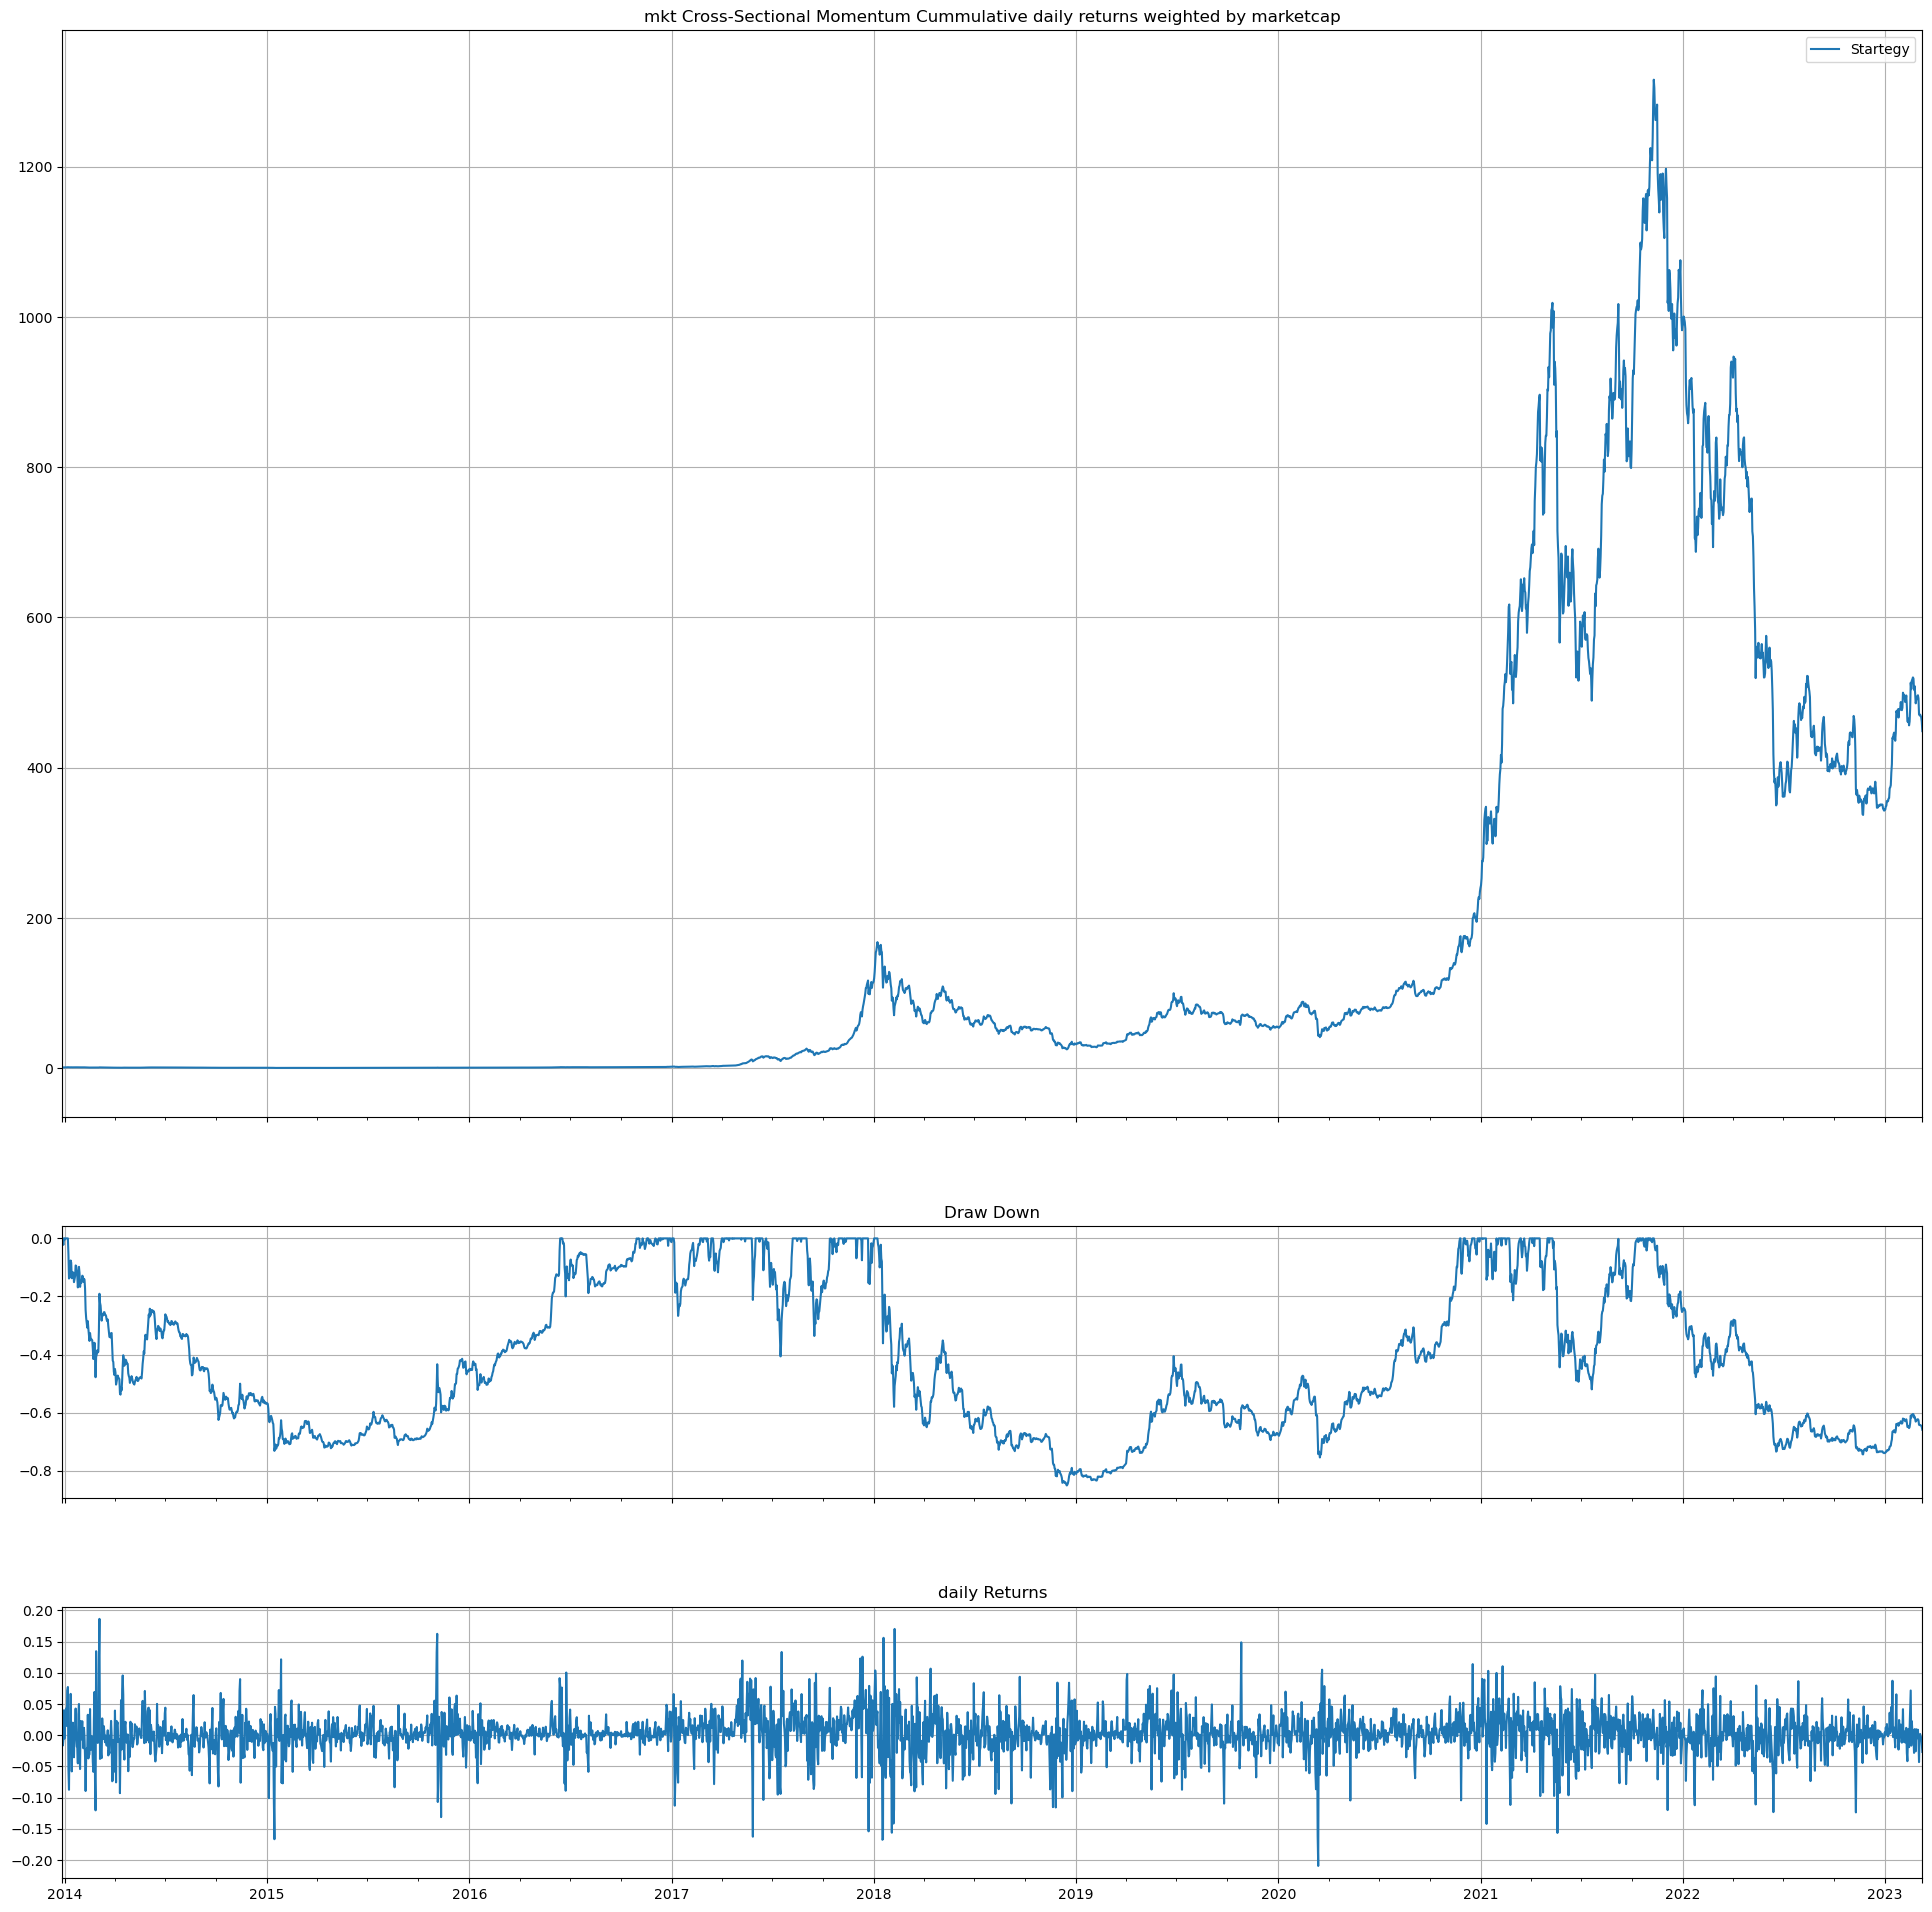

In [12]:
mkt.draw_return_result({"mkt":mkt_index})

In [5]:
test = CrossSection(price, mktcap, freq="weekly")
test_mkt_index  = test.mkt_index()

In [6]:
# 와 미친 존나 좋군!! 똑같잖어!!! 코드 잘짰다!!
#pd.set_option("display.max_rows", )
pd.concat([mkt_index, test_mkt_index], axis=1)#.iloc[-50:]

0         1
2013-03-01  0.000000  0.000000
2013-03-02  0.000000  0.000000
2013-03-03  0.000000  0.000000
2013-03-04  0.000000  0.000000
2013-03-05  0.000000  0.000000
...              ...       ...
2023-03-05  0.001972  0.001972
2023-03-06 -0.003847 -0.003847
2023-03-07 -0.003738 -0.003738
2023-03-08 -0.012762 -0.012762
2023-03-09 -0.026994 -0.026994

[3661 rows x 2 columns]

### 주단위 리벨런싱

In [15]:
mktcap_pp.loc["2013-12-27":]

$ROPE      0XBTC 0XMR  0XW 100x 10MT        10SET  18C  1AI 1AMD  \
2013-12-27   NaN        NaN  NaN  NaN  NaN  NaN          NaN  NaN  NaN  NaN   
2013-12-28   NaN        NaN  NaN  NaN  NaN  NaN          NaN  NaN  NaN  NaN   
2013-12-29   NaN        NaN  NaN  NaN  NaN  NaN          NaN  NaN  NaN  NaN   
2013-12-30   NaN        NaN  NaN  NaN  NaN  NaN          NaN  NaN  NaN  NaN   
2013-12-31   NaN        NaN  NaN  NaN  NaN  NaN          NaN  NaN  NaN  NaN   
...          ...        ...  ...  ...  ...  ...          ...  ...  ...  ...   
2023-03-06   NaN  1925829.0  NaN  NaN  NaN  NaN  116955456.0  NaN  NaN  NaN   
2023-03-07   NaN  1916279.0  NaN  NaN  NaN  NaN  116641456.0  NaN  NaN  NaN   
2023-03-08   NaN  1904300.0  NaN  NaN  NaN  NaN  110647190.0  NaN  NaN  NaN   
2023-03-09   NaN  1855984.0  NaN  NaN  NaN  NaN  108751296.0  NaN  NaN  NaN   
2023-03-10   NaN  1731084.0  NaN  NaN  NaN  NaN  102590177.0  NaN  NaN  NaN   

            ...  ZYX  ZZC  ZZZ ZZZV2 eCum eRSDL g9tro imBTC yBXTB yTOFU  
2013-12-27  ...  NaN  NaN  NaN   NaN  NaN   NaN   NaN   NaN   NaN   NaN  
2013-12-28  ...  NaN  NaN  NaN   NaN  NaN   NaN   NaN   NaN   NaN   NaN  
2013-12-29  ...  NaN  NaN  NaN   NaN  NaN   NaN   NaN   NaN   NaN   NaN  
2013-12-30  ...  NaN  NaN  NaN   NaN  NaN   NaN   NaN   NaN   NaN   NaN  
2013-12-31  ...  NaN  NaN  NaN   NaN  NaN   NaN   NaN   NaN   NaN   NaN  
...         ...  ...  ...  ...   ...  ...   ...   ...   ...   ...   ...  
2023-03-06  ...  NaN  NaN  NaN   NaN  NaN   NaN   NaN   NaN   NaN   NaN  
2023-03-07  ...  NaN  NaN  NaN   NaN  NaN   NaN   NaN   NaN   NaN   NaN  
2023-03-08  ...  NaN  NaN  NaN   NaN  NaN   NaN   NaN   NaN   NaN   NaN  
2023-03-09  ...  NaN  NaN  NaN   NaN  NaN   NaN   NaN   NaN   NaN   NaN  
2023-03-10  ...  NaN  NaN  NaN   NaN  NaN   NaN   NaN   NaN   NaN   NaN  

[3361 rows x 9406 columns]

In [14]:
weekly = CrossSection(price.loc["2013-12-27":], mktcap_pp.loc["2013-12-27":], freq="weekly")
q5_weekly = weekly.q_momentum("5", 20, True)
#three_weekly = weekly.q_momentum("3", 20, True)

c:\Users\user\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1374: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
  0%|          | 0/5 [00:03<?, ?it/s]


ZeroDivisionError: float division by zero

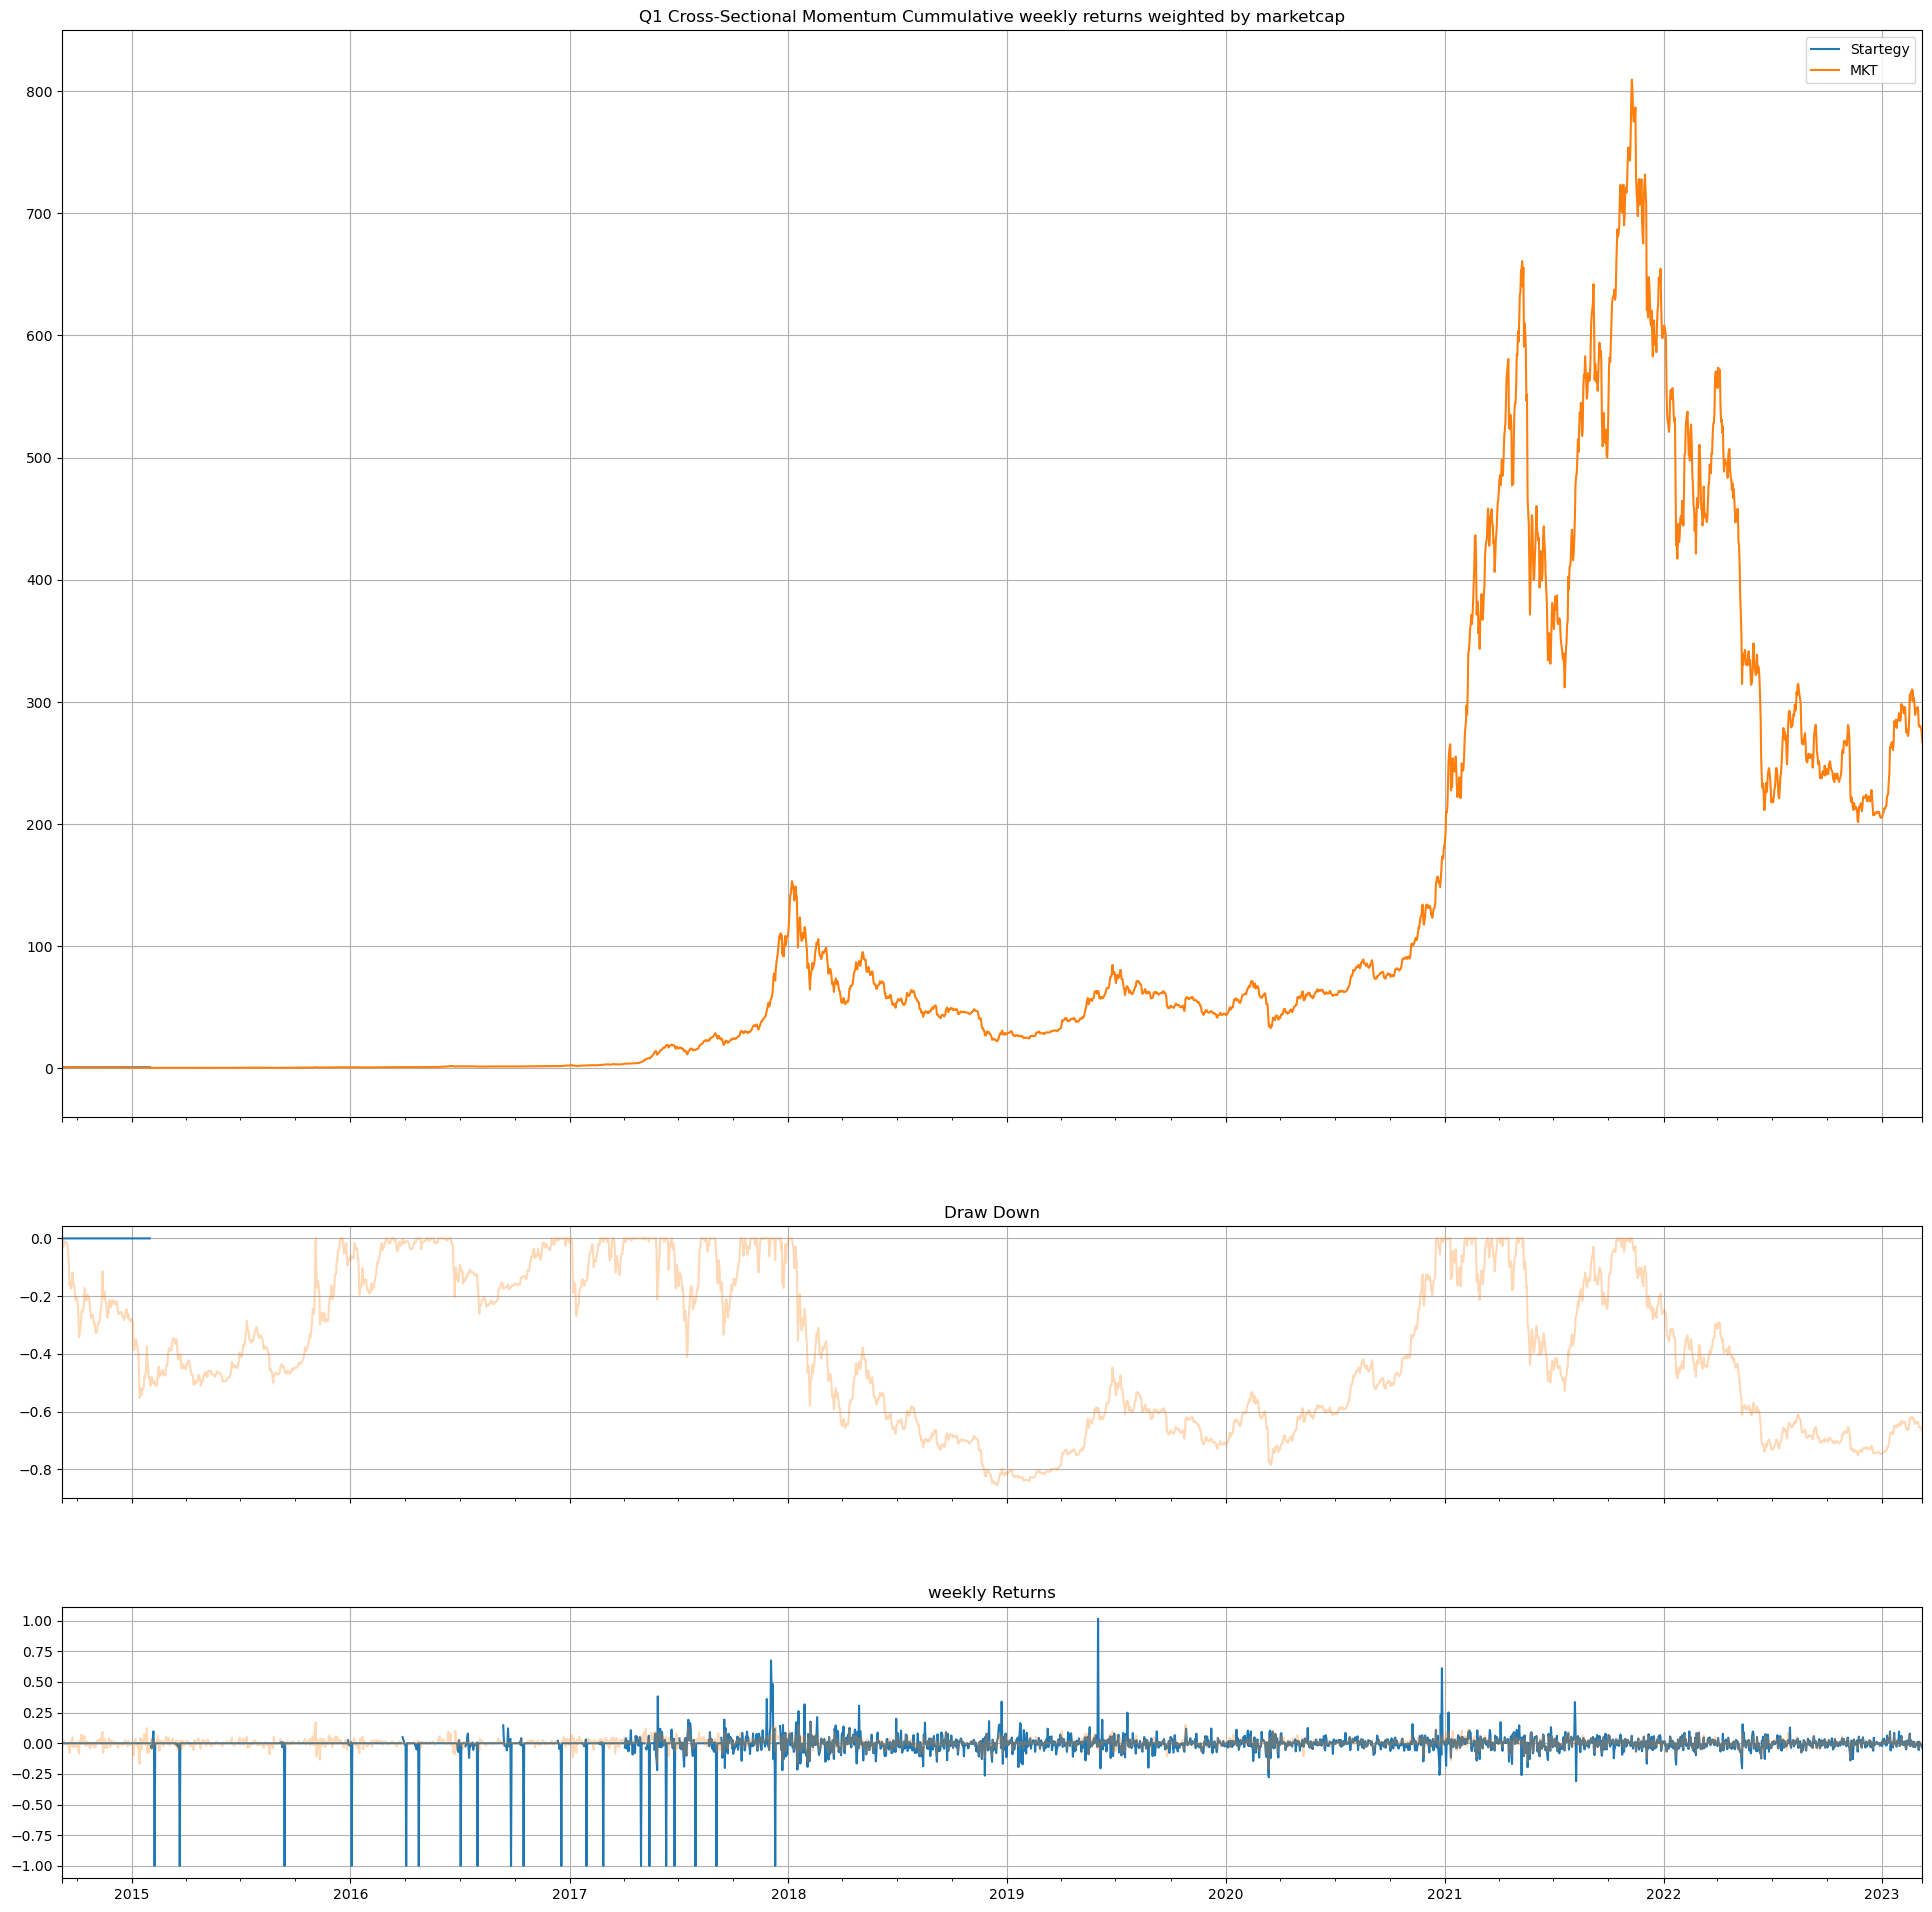

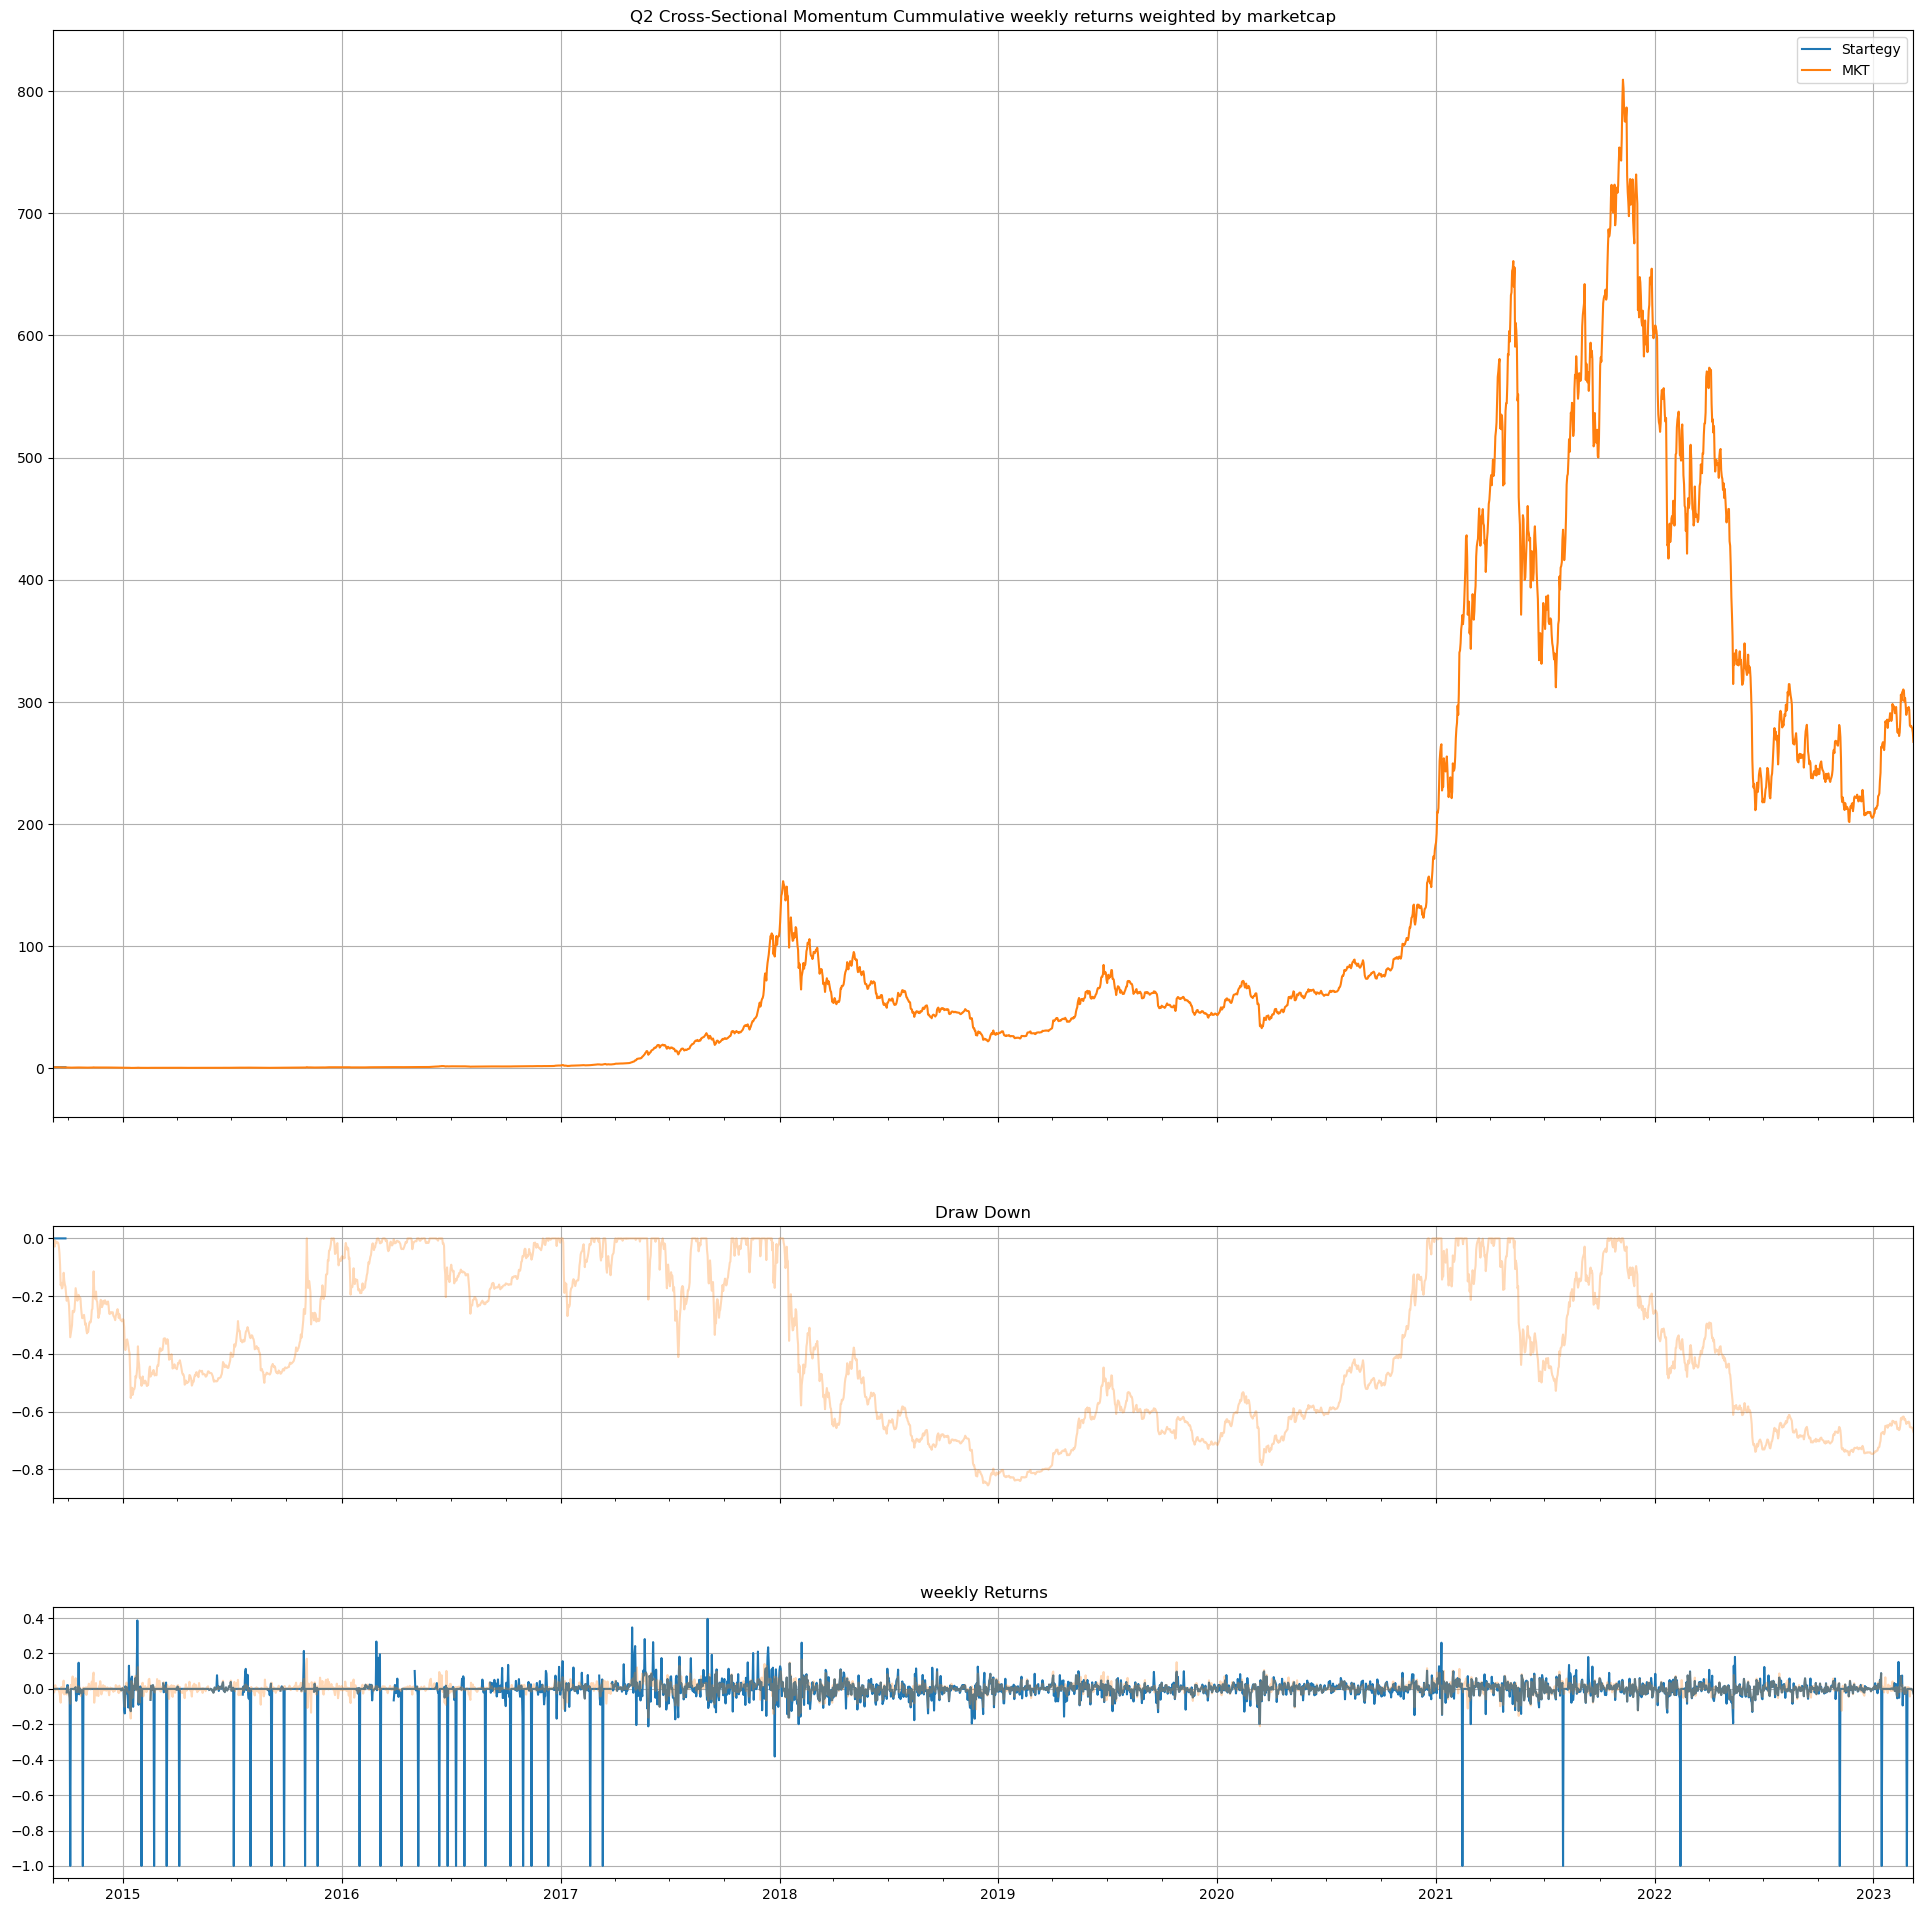

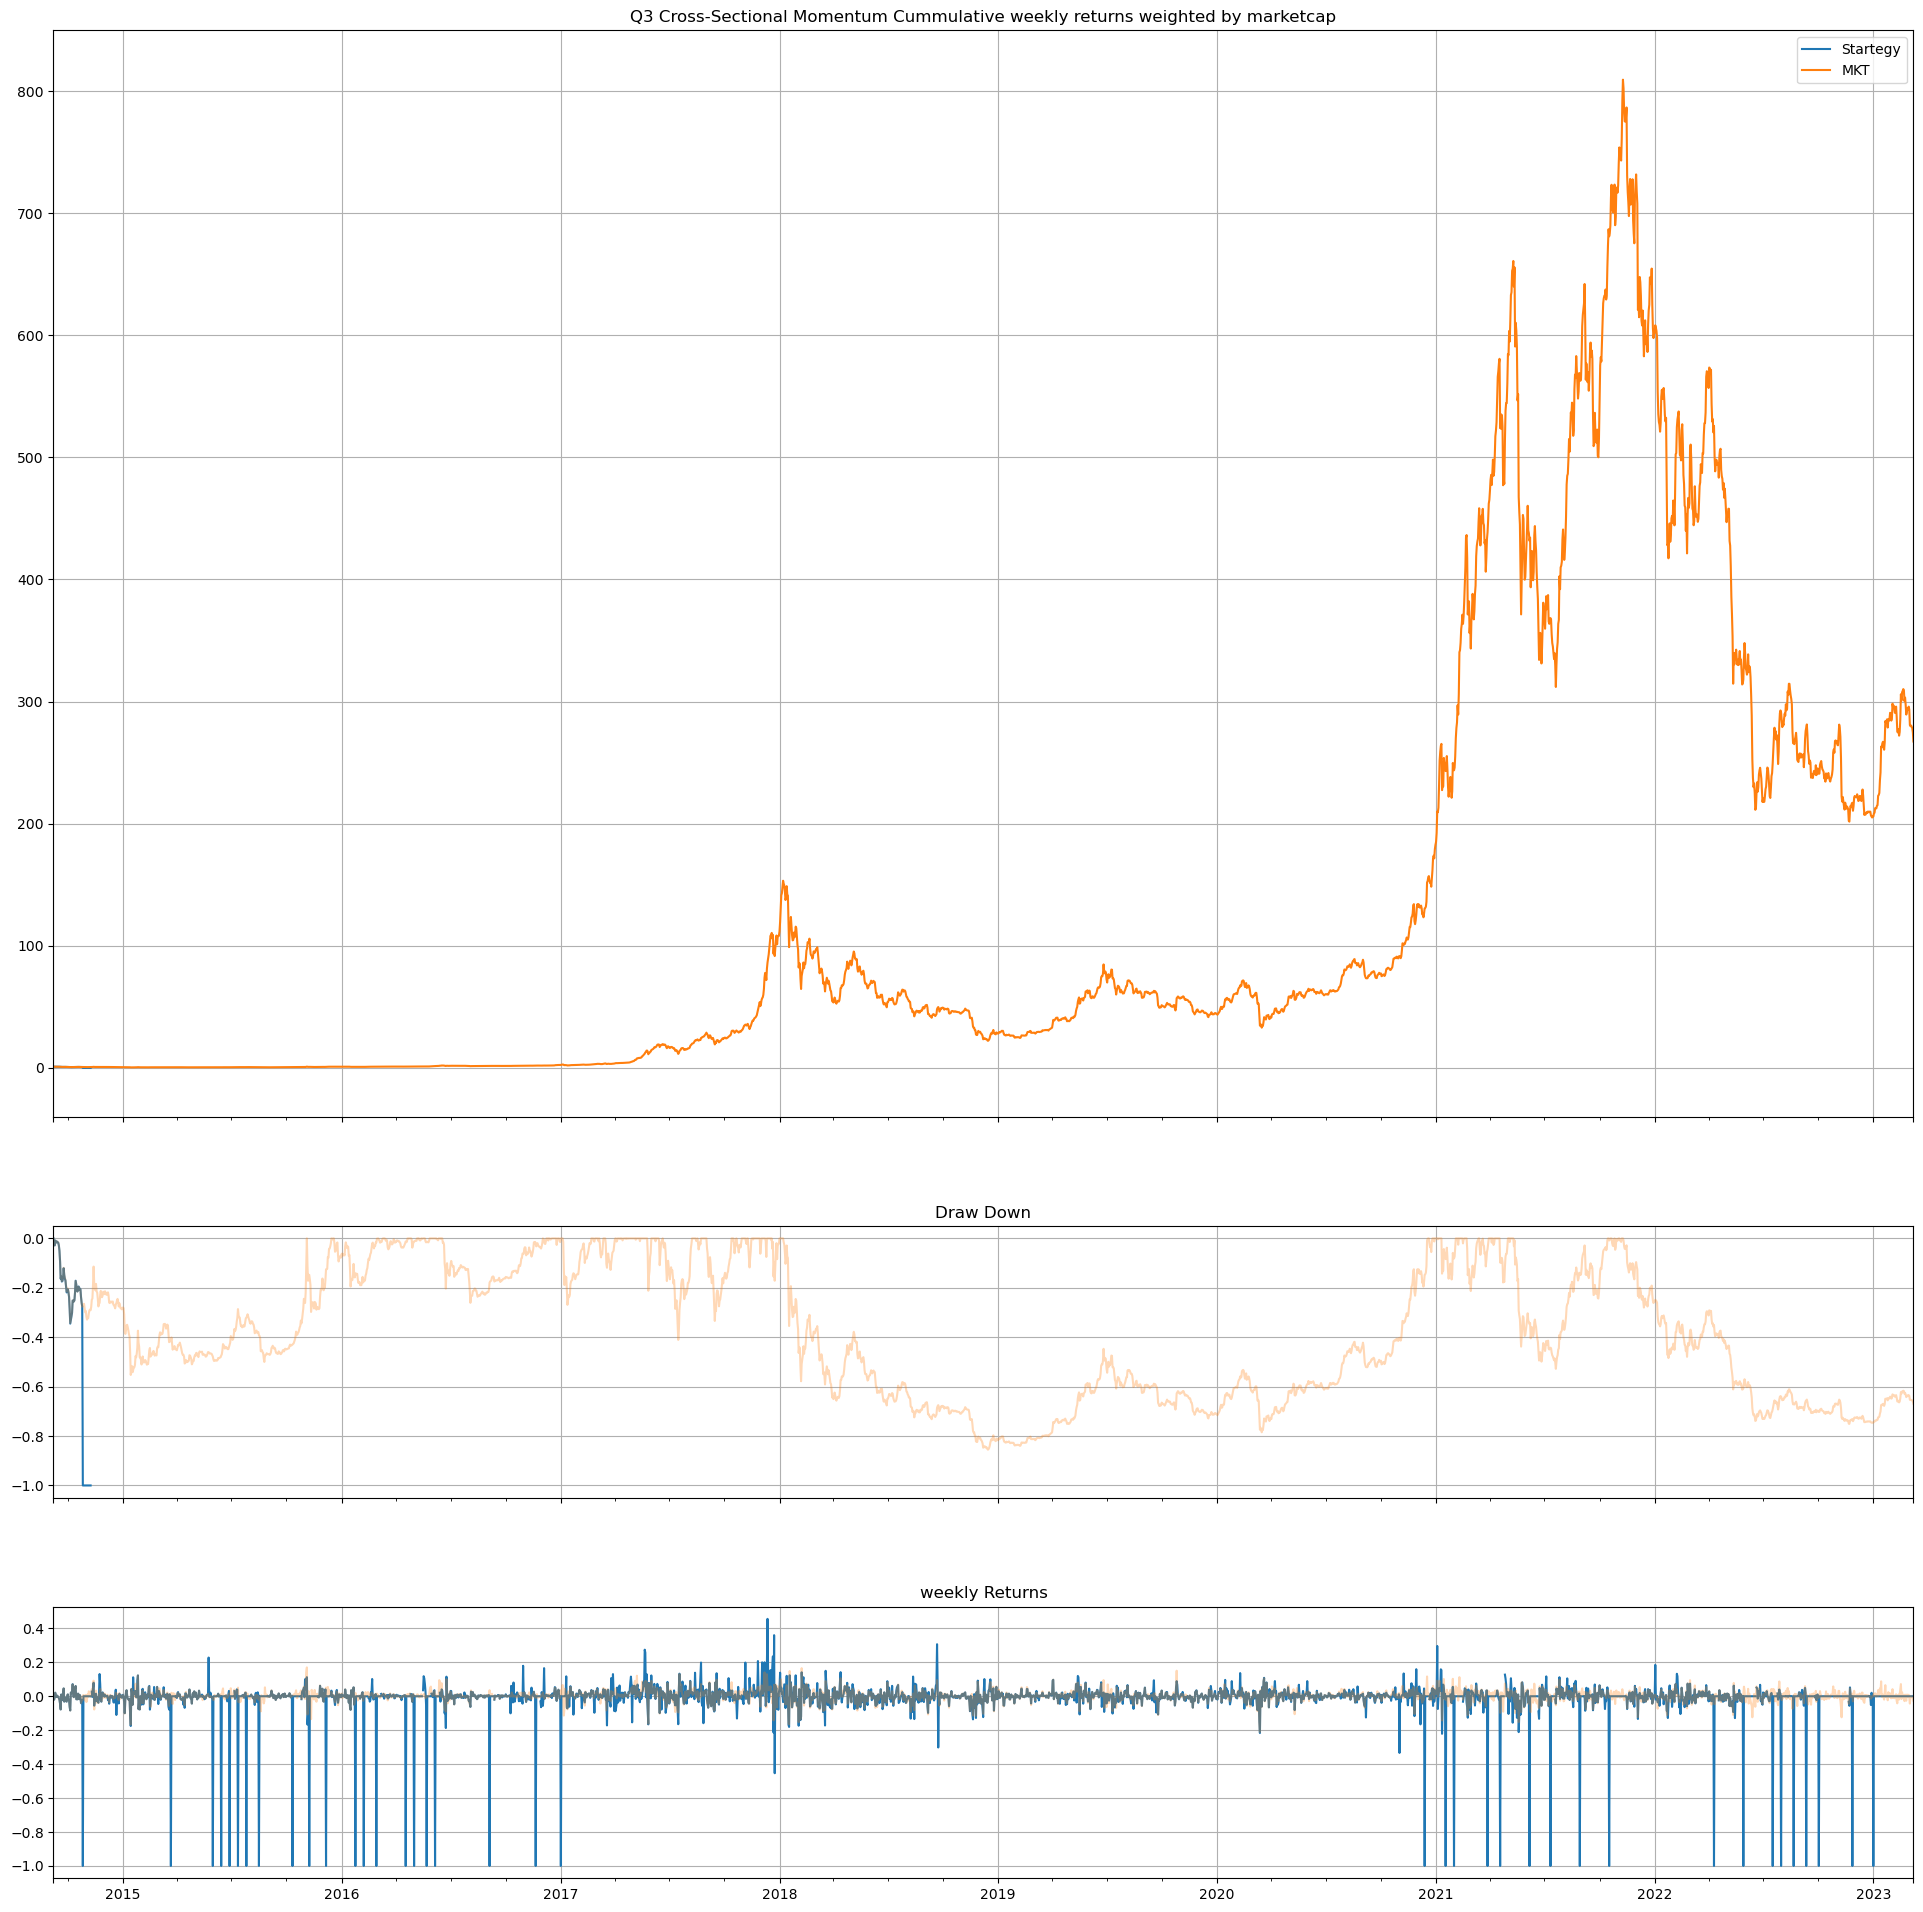

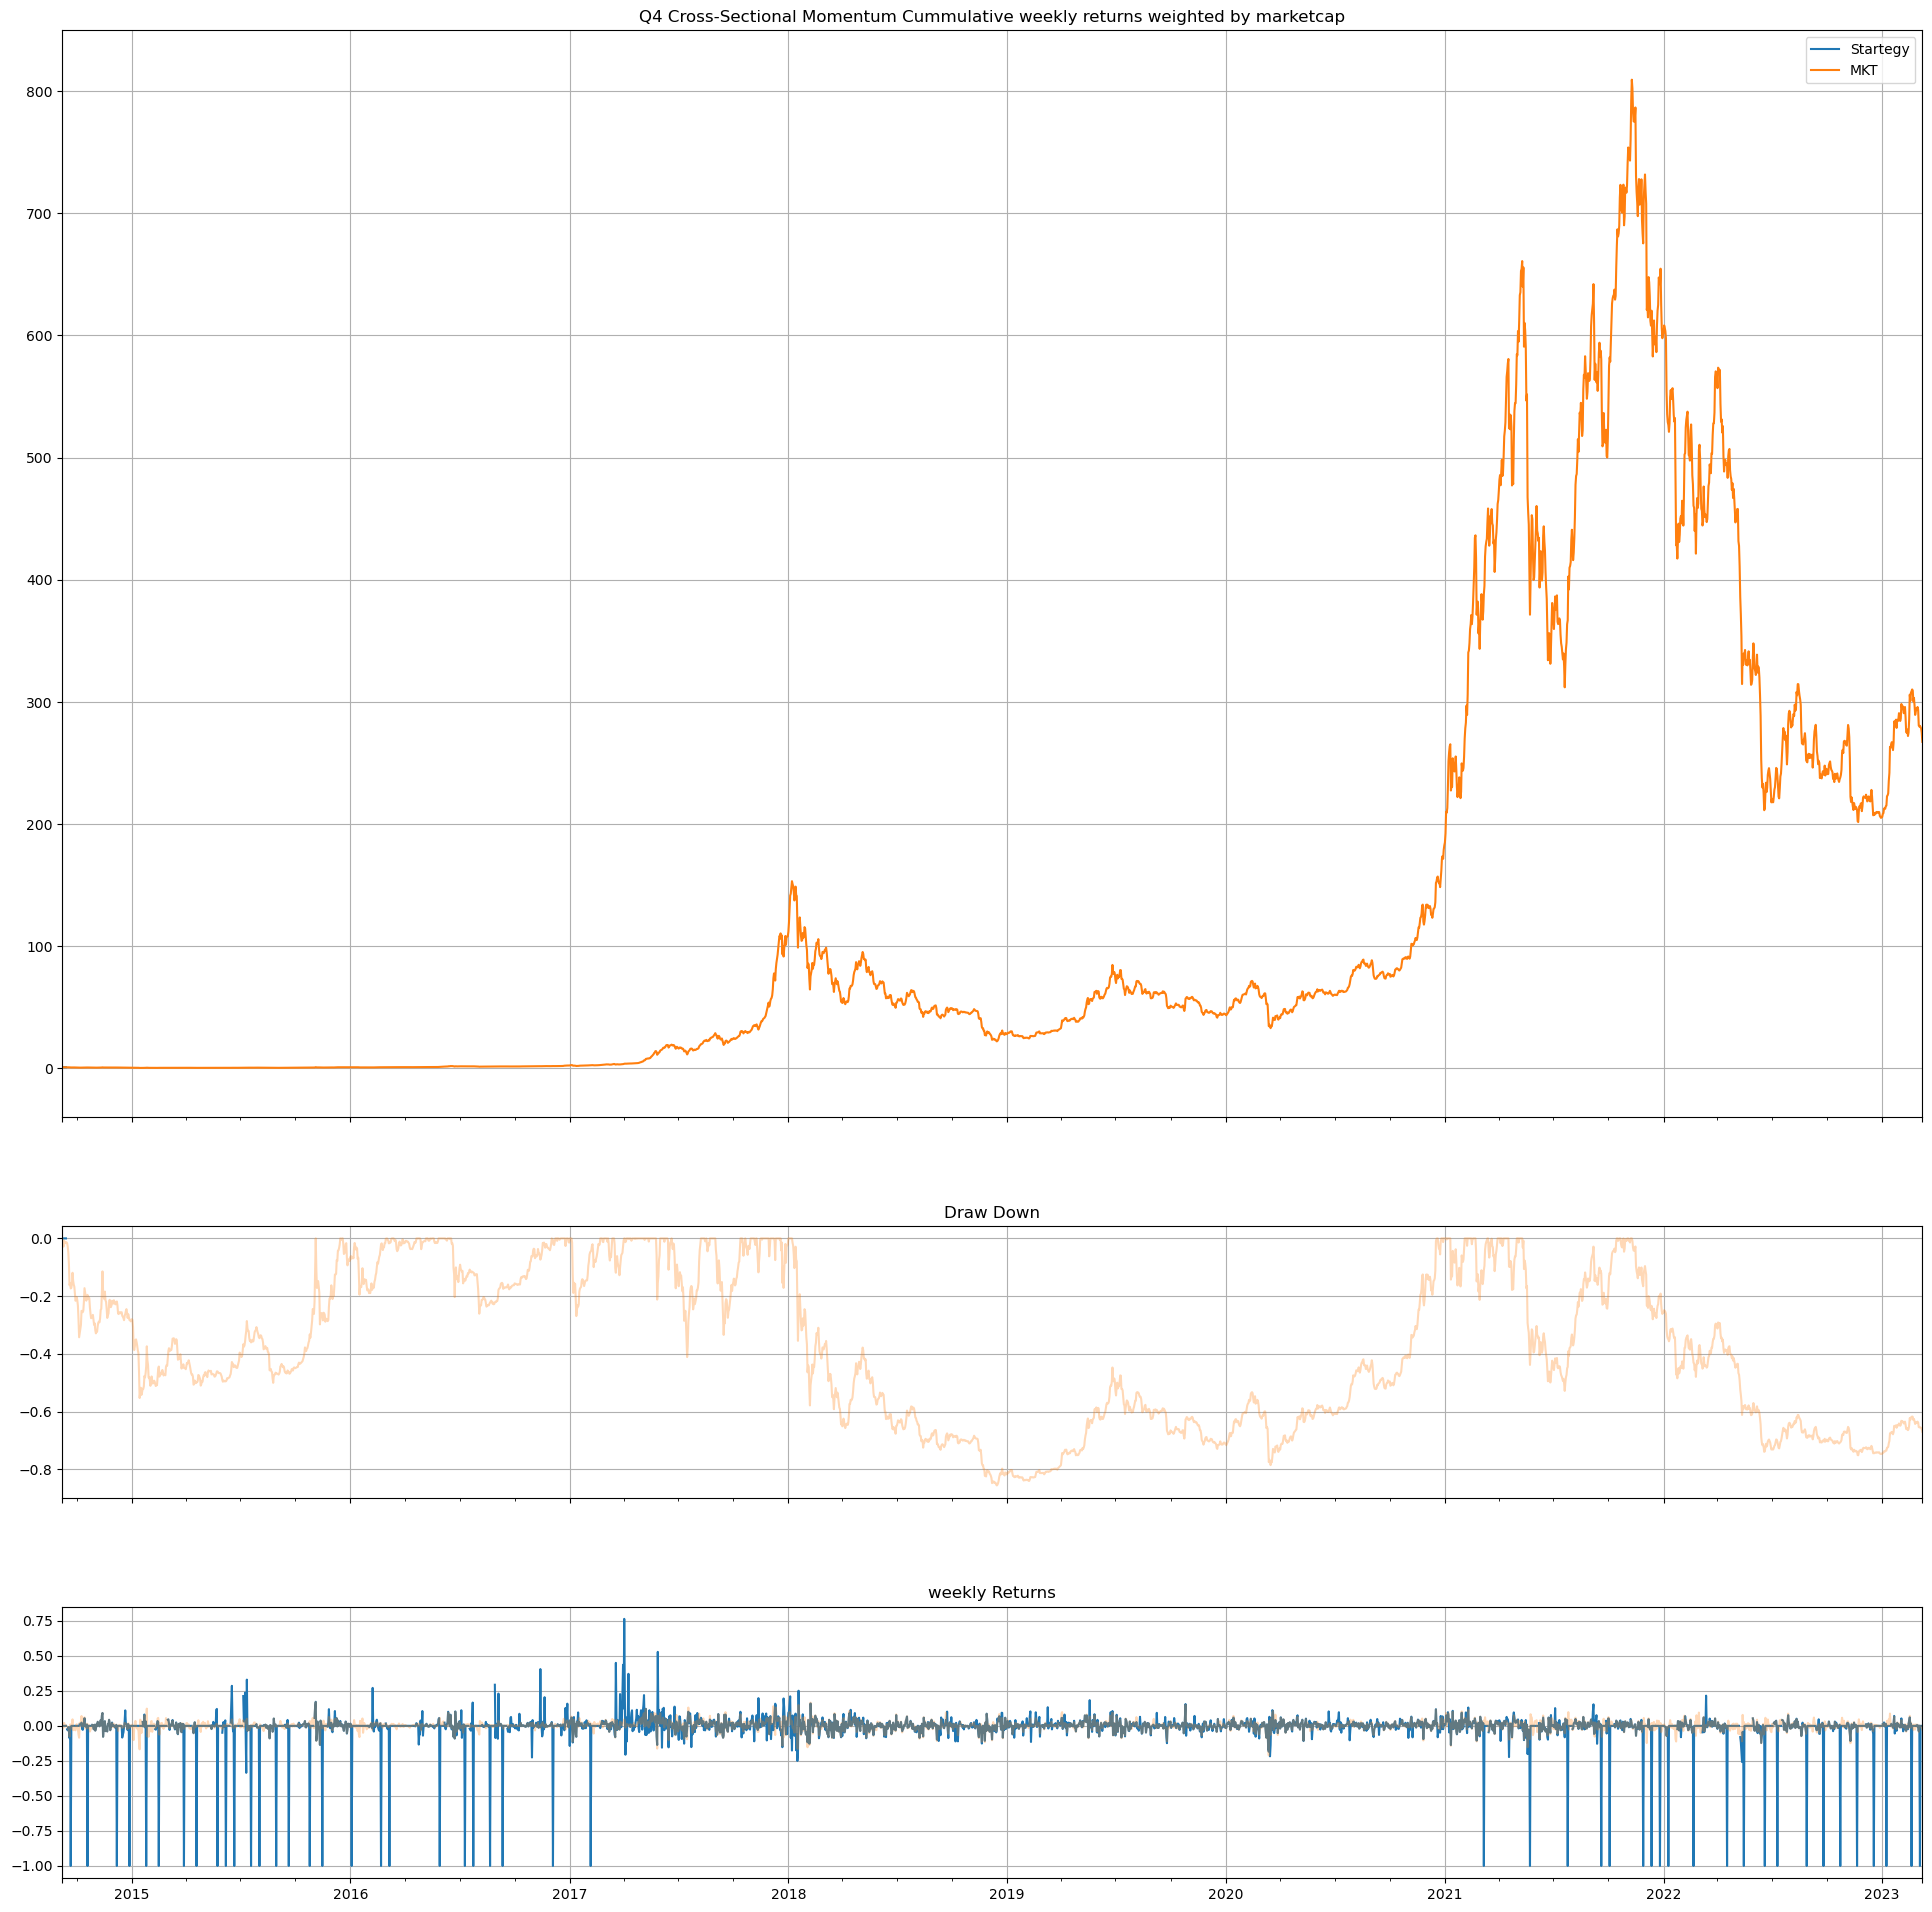

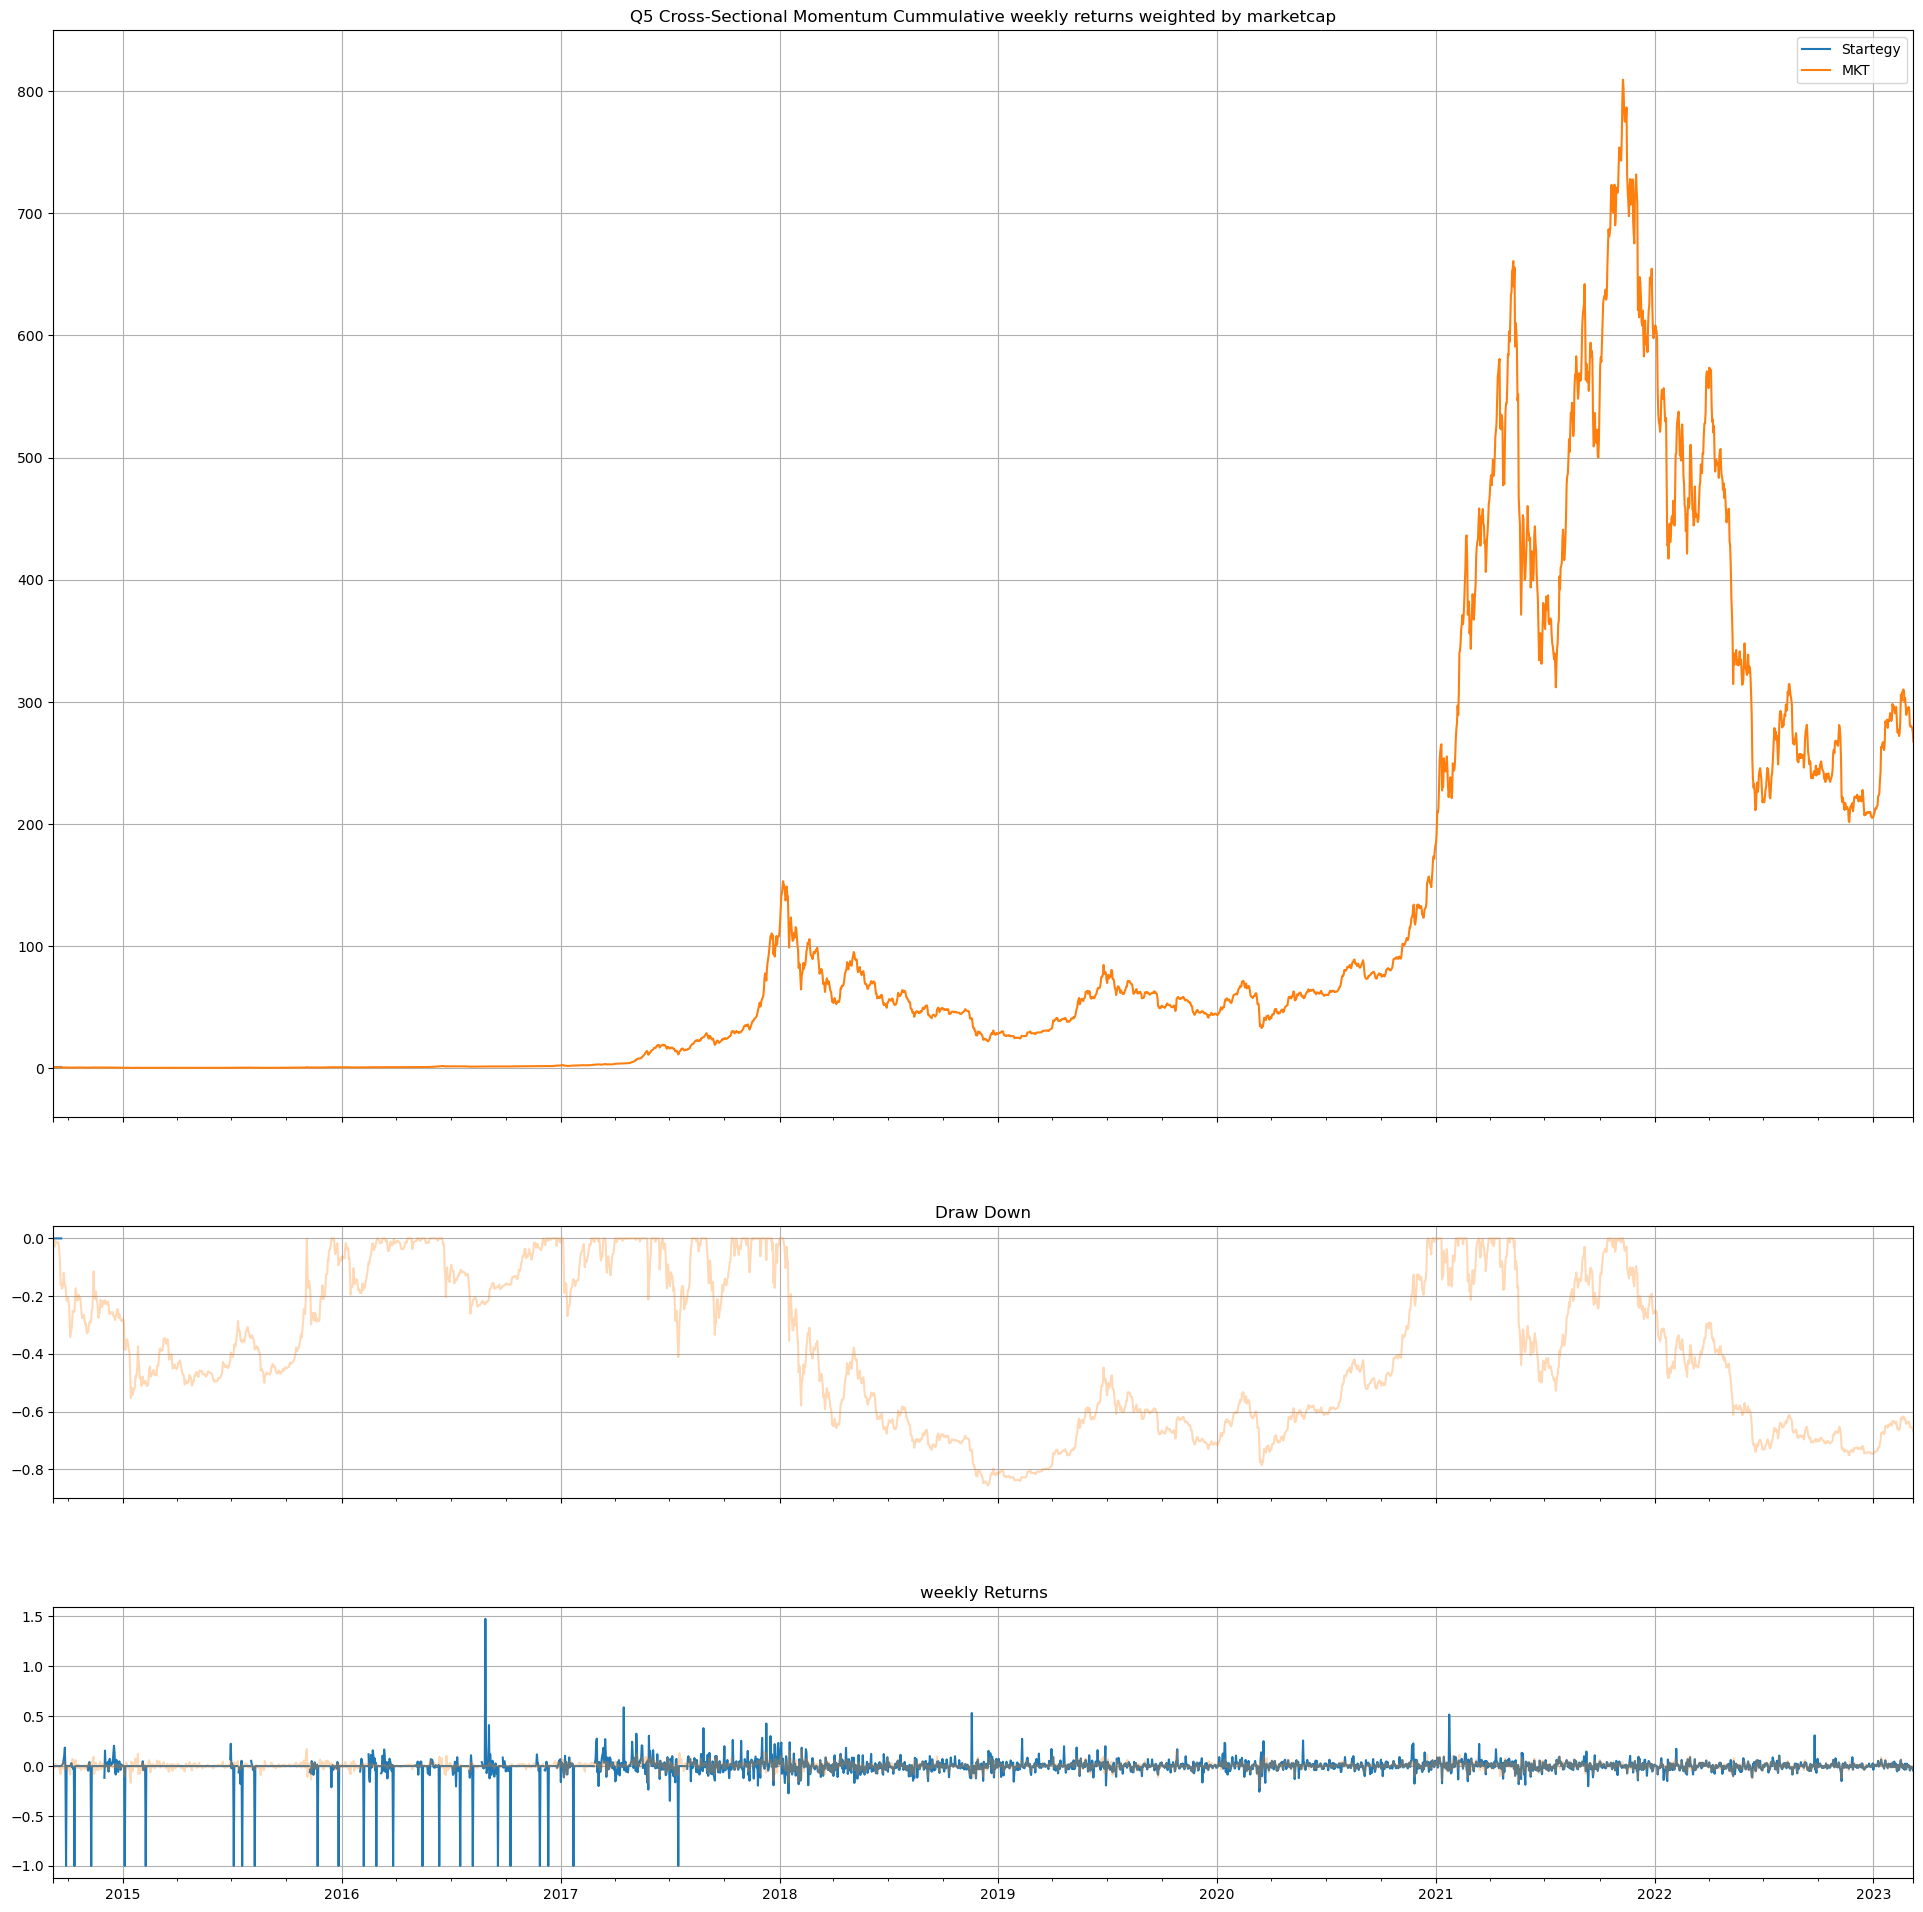

In [9]:
weekly.draw_return_result(q5_weekly, with_mkt=True)

<AxesSubplot:>

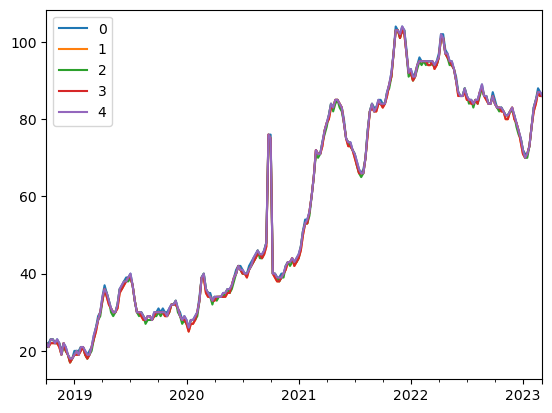

In [13]:
q5_weekly["count"].plot()

In [14]:
weekly.print_statistics(q5_weekly, with_mkt=True)

Q1        Q2        Q3         Q4         Q5        MKT
CAGR  -52.501367 -3.969982 -7.665645  36.144884  79.455111  47.042771
Mean   -0.000835  0.000840  0.000566   0.001671   0.002588   0.001547
STD     0.049183  0.043556  0.039418   0.040208   0.044697   0.031255
Shape  -0.324353  0.368448  0.274325   0.793974   1.106186   0.945653

In [11]:
weekly.run_alpha_regression(q5_weekly, constant=True)

Q1 Regression Result
                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.451     
Dependent Variable: y                AIC:                -7271.6638
Date:               2023-03-31 21:00 BIC:                -7260.3932
No. Observations:   2070             Log-Likelihood:     3637.8    
Df Model:           1                F-statistic:        1703.     
Df Residuals:       2068             Prob (F-statistic): 4.92e-272 
R-squared:          0.452            Scale:              0.0017437 
---------------------------------------------------------------------
             Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
---------------------------------------------------------------------
const       -0.0029     0.0009   -3.1226   0.0018   -0.0047   -0.0011
0            1.1464     0.0278   41.2621   0.0000    1.0919    1.2009
-------------------------------------------------------------------
Omnibus:            1729.344      D

In [12]:
new_dict = {key: df for key, df in q5_weekly.items() if key != "count"}

# 상관관계 map 출력
pd.concat([pd.DataFrame(new_dict), mkt_index.loc["2017-07-09":]],
          axis=1).corr()

Q1        Q2        Q3        Q4        Q5         0
Q1  1.000000  0.538057  0.583478  0.450741  0.290725  0.671968
Q2  0.538057  1.000000  0.489100  0.479495  0.326522  0.725343
Q3  0.583478  0.489100  1.000000  0.487426  0.399722  0.758377
Q4  0.450741  0.479495  0.487426  1.000000  0.338624  0.734238
Q5  0.290725  0.326522  0.399722  0.338624  1.000000  0.582304
0   0.671968  0.725343  0.758377  0.734238  0.582304  1.000000

### 일단위 리밸런싱

In [15]:
daily = CrossSection(price, mktcap, freq="daily")
q5_daily = daily.q_momentum("5",20, True)

c:\Users\user\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1374: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
100%|██████████| 5/5 [00:36<00:00,  7.22s/it]


2018-01-09 00:00:00에서부터 수익률을 계산


100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


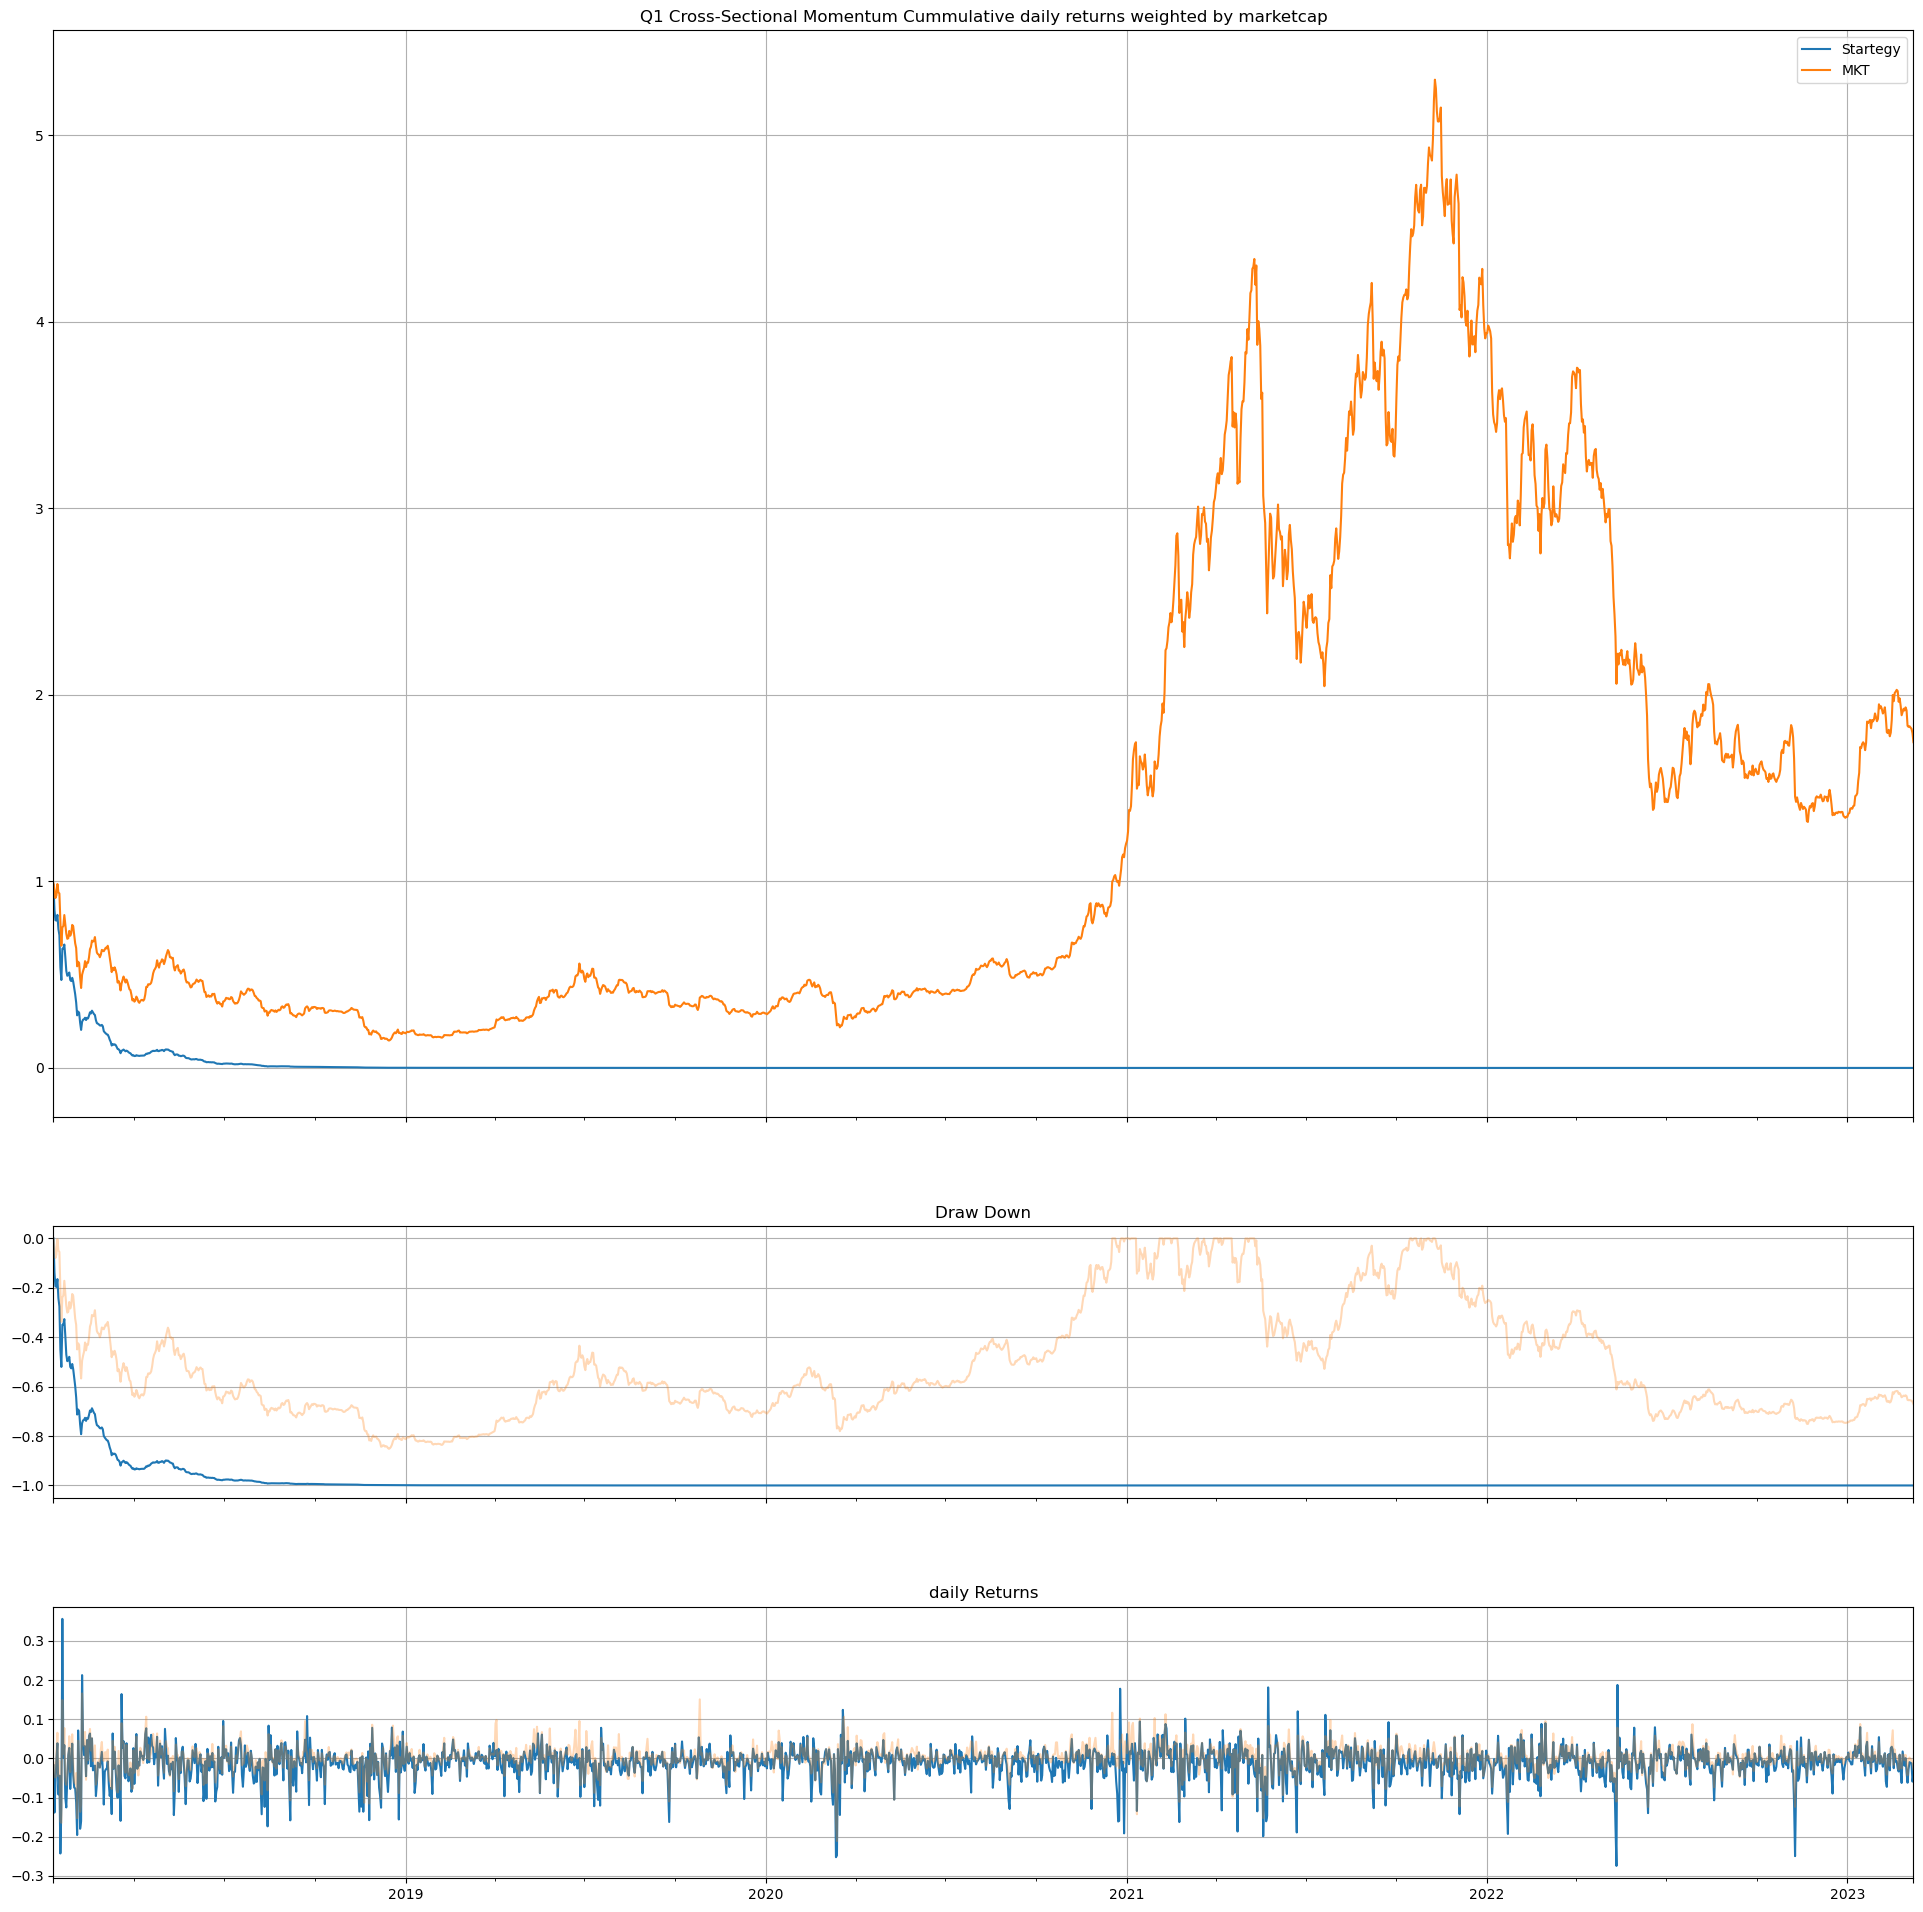

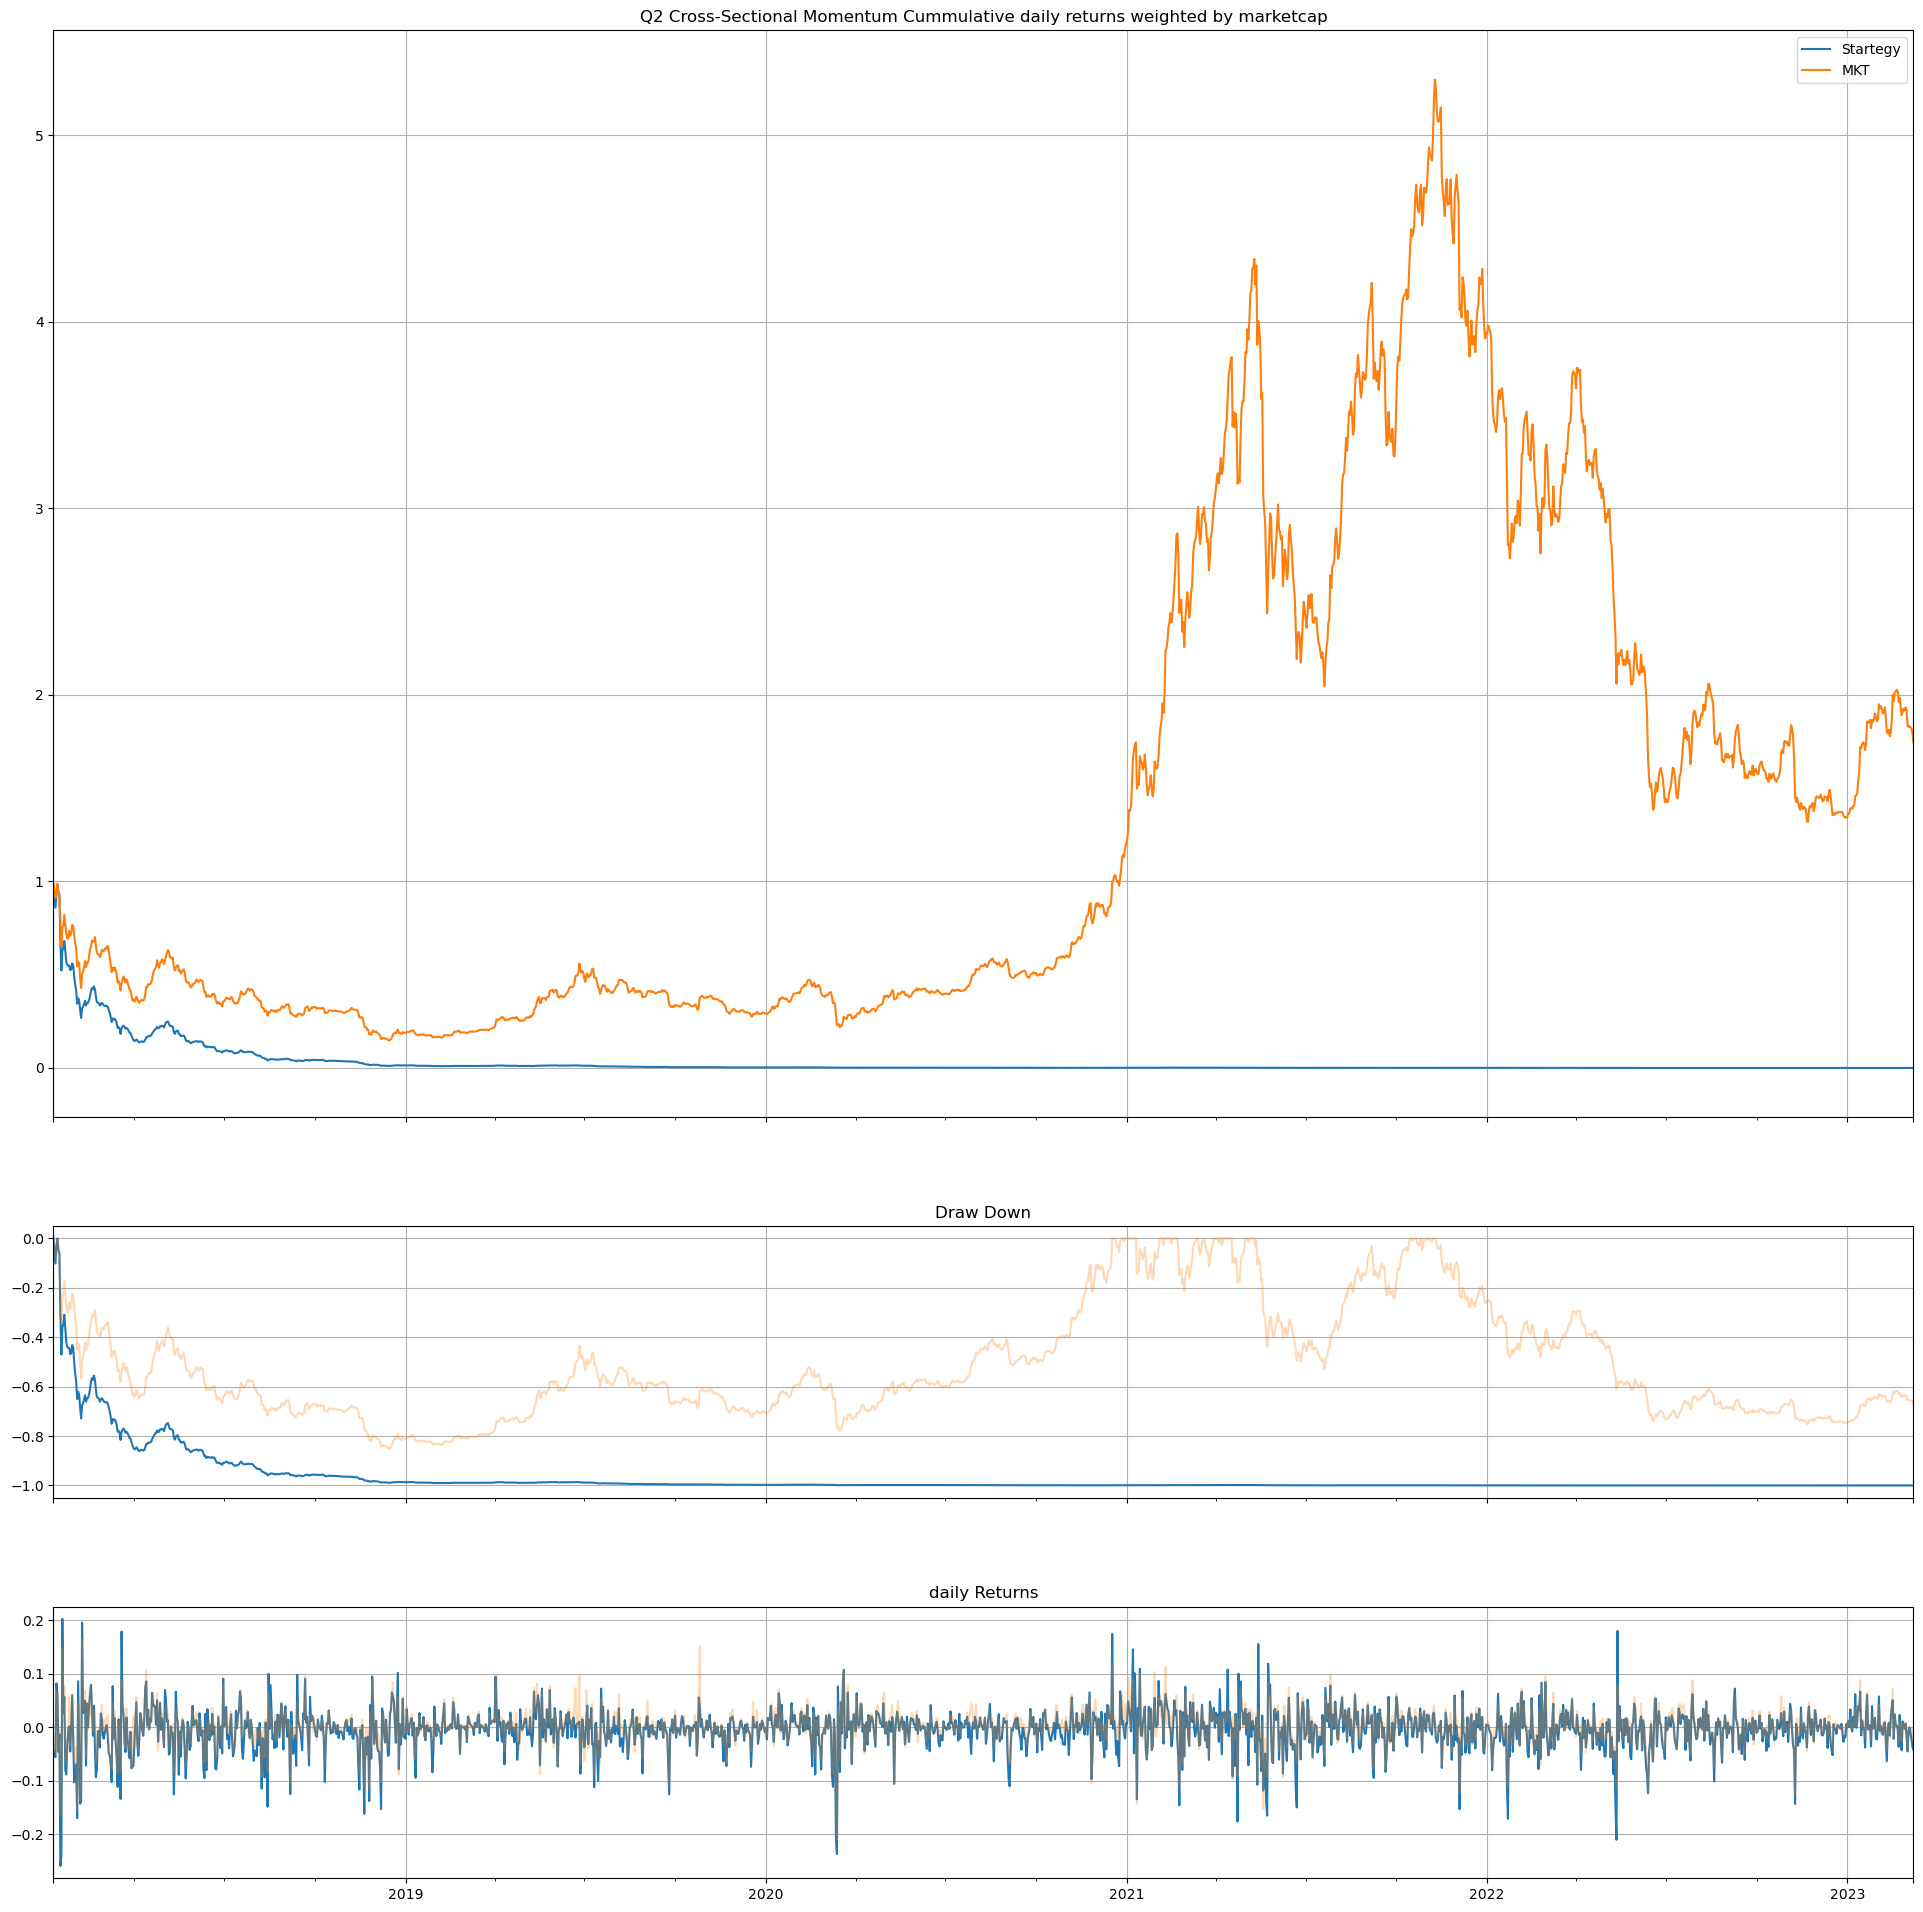

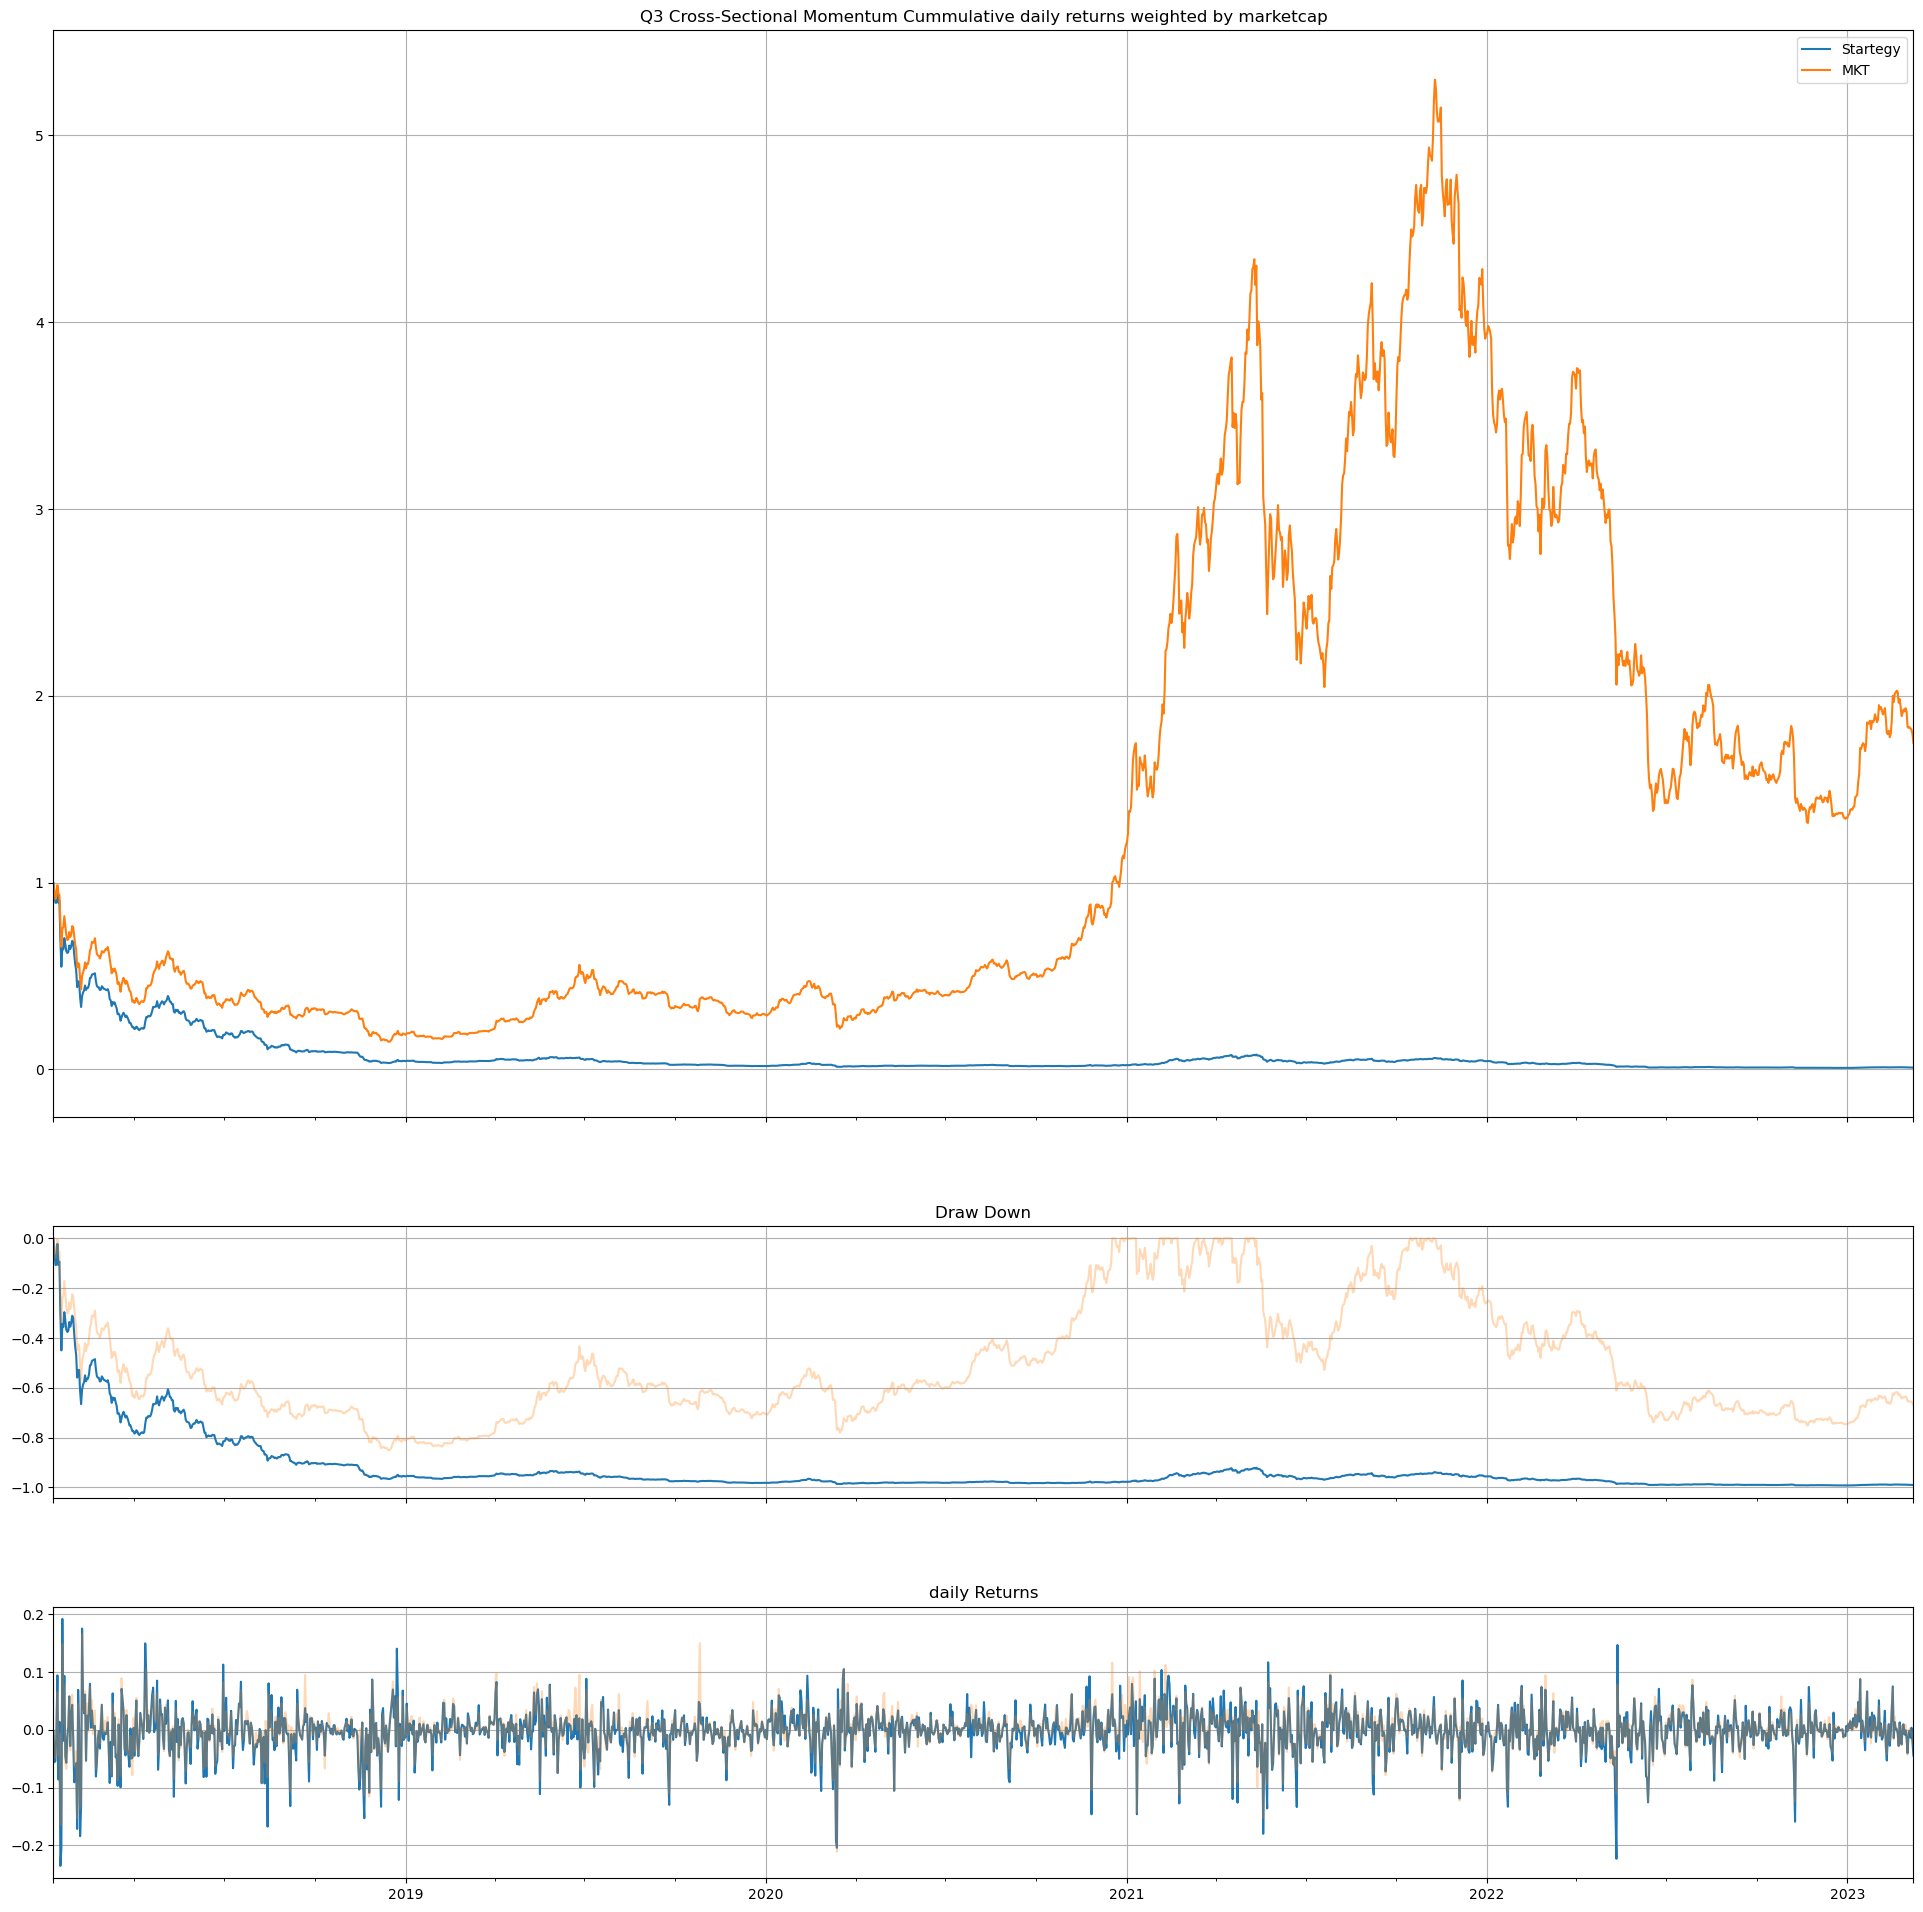

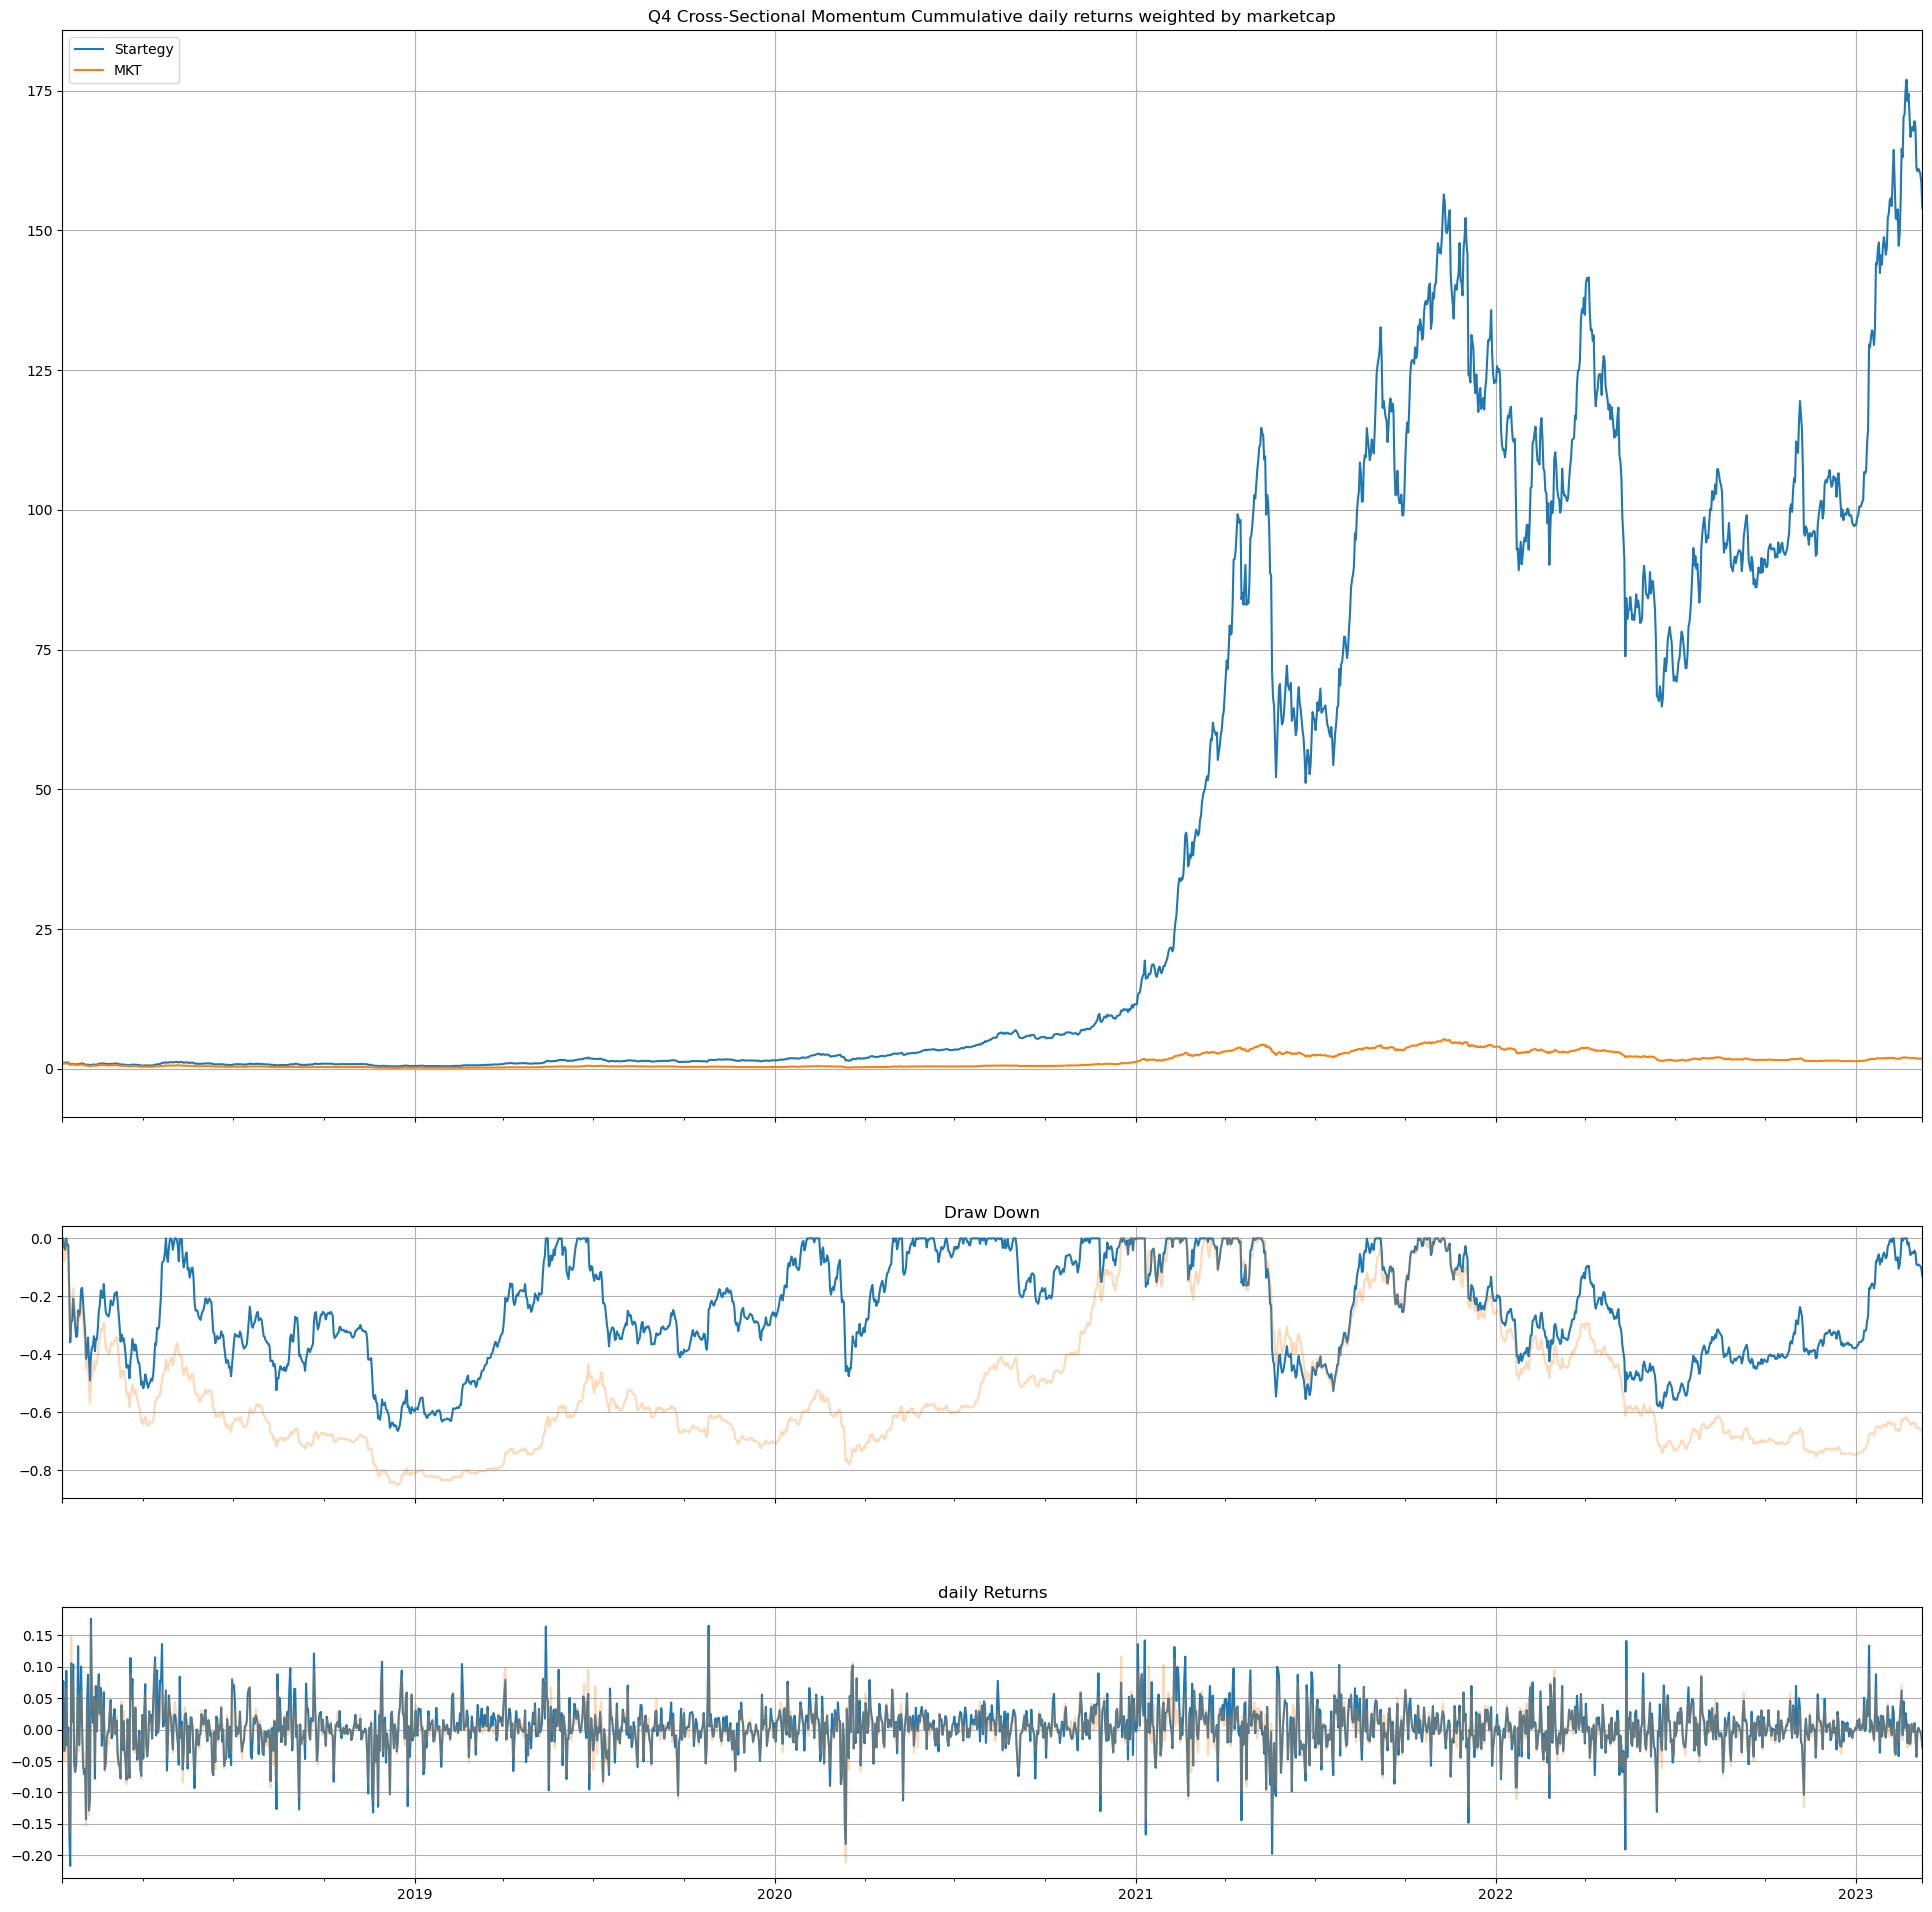

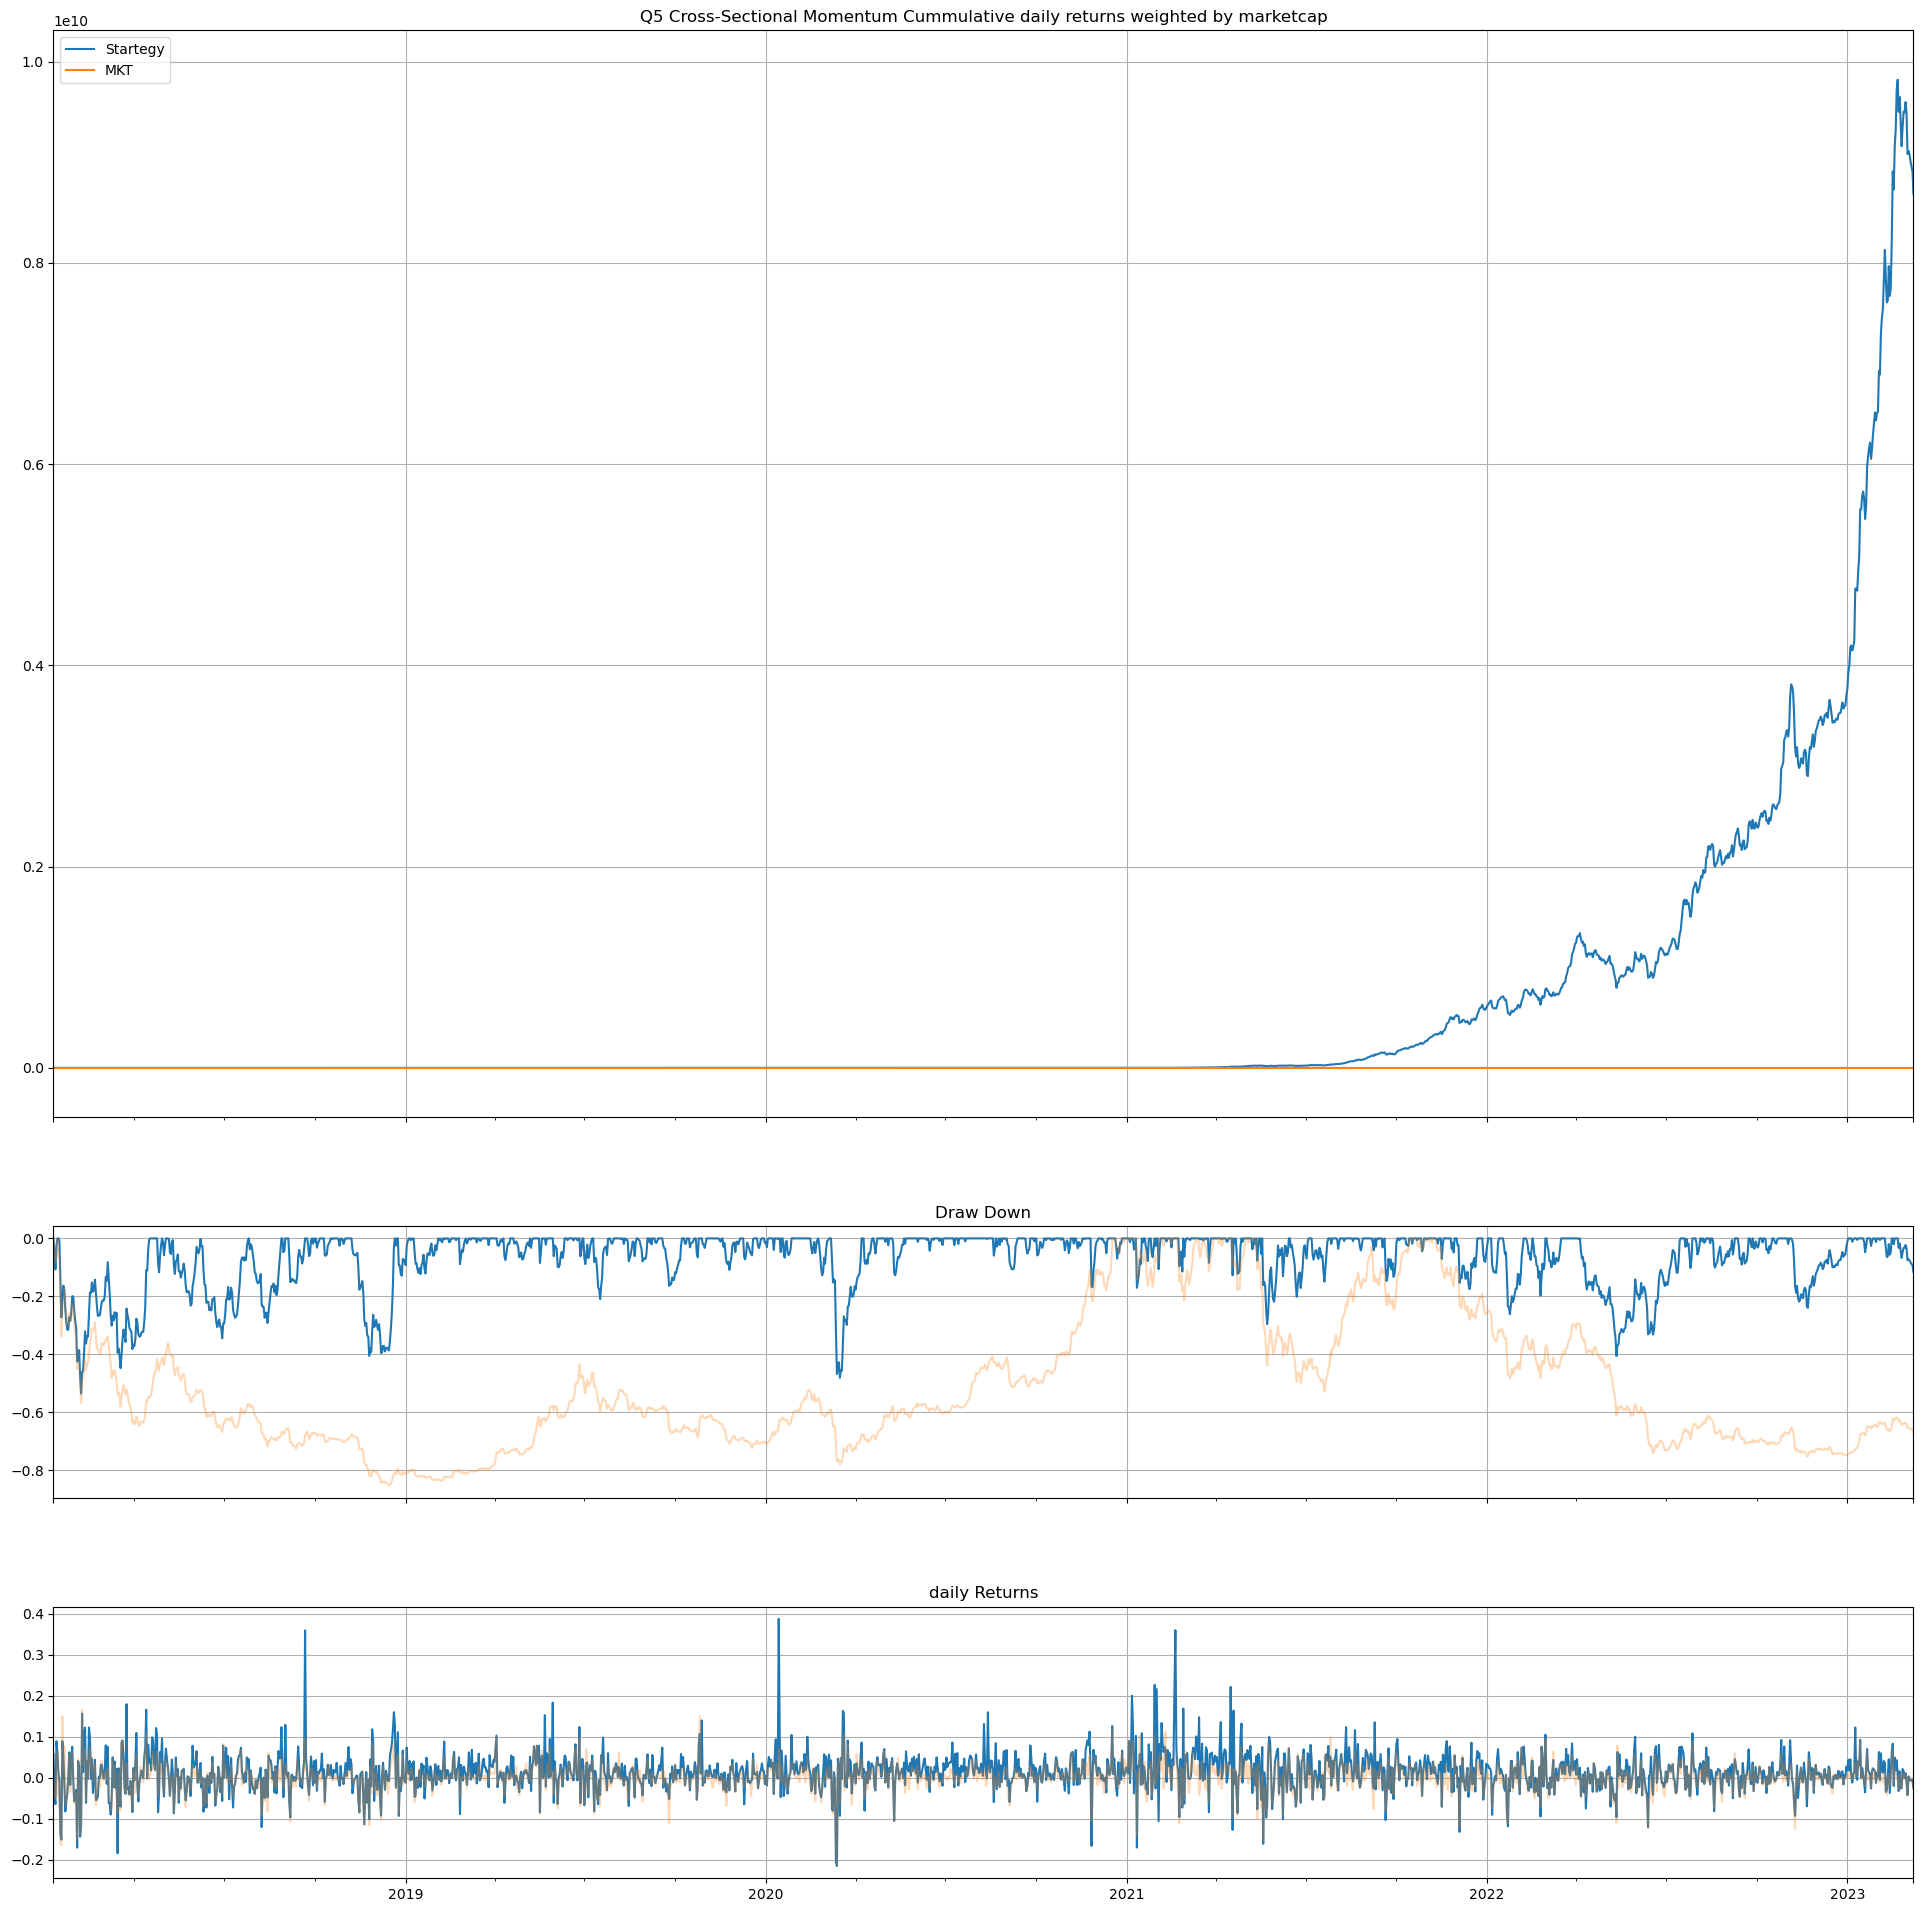

In [16]:
daily.draw_return_result(q5_daily, with_mkt=True)

In [17]:
daily.print_statistics(q5_daily, with_mkt=True)

Q1         Q2         Q3          Q4           Q5        MKT
CAGR  -99.209640 -88.307752 -59.547098  164.102657  8193.842531  11.623145
Mean   -0.012186  -0.005085  -0.001749    0.003389     0.013235   0.000856
STD     0.043770   0.039426   0.037625    0.037593     0.045923   0.033226
Shape  -5.318999  -2.464095  -0.888105    1.722315     5.506035   0.492134

In [14]:
daily.run_alpha_regression(q5_daily)

Q1 Regression Result
                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.678     
Dependent Variable: y                AIC:                -8833.5460
Date:               2023-04-01 21:51 BIC:                -8822.4103
No. Observations:   1935             Log-Likelihood:     4418.8    
Df Model:           1                F-statistic:        4078.     
Df Residuals:       1933             Prob (F-statistic): 0.00      
R-squared:          0.678            Scale:              0.00060878
---------------------------------------------------------------------
            Coef.    Std.Err.      t       P>|t|     [0.025    0.975]
---------------------------------------------------------------------
const      -0.0146     0.0006   -25.9683   0.0000   -0.0157   -0.0135
0           1.0531     0.0165    63.8576   0.0000    1.0207    1.0854
-------------------------------------------------------------------
Omnibus:             455.197       

In [17]:
new_dict = {key: df for key, df in q5_daily.items() if key != "count"}

# 상관관계 map 출력
pd.concat([pd.DataFrame(new_dict), mkt_index.loc["2017-06-28":]],
          axis=1).corr()

Q1        Q2        Q3        Q4        Q5         0
Q1  1.000000  0.852805  0.789297  0.671318  0.512056  0.789831
Q2  0.852805  1.000000  0.843296  0.751095  0.569255  0.865921
Q3  0.789297  0.843296  1.000000  0.787373  0.629204  0.903486
Q4  0.671318  0.751095  0.787373  1.000000  0.650812  0.875697
Q5  0.512056  0.569255  0.629204  0.650812  1.000000  0.717304
0   0.789831  0.865921  0.903486  0.875697  0.717304  1.000000

롤링 일단위 리밸런싱

In [18]:
daily_rol = CrossSection(price, mktcap, freq="daily")
q5_rolling_daily = daily_rol.q_momentum_rolling("5", 20, True)

c:\Users\user\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1374: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
100%|██████████| 5/5 [00:37<00:00,  7.48s/it]


2018-09-25 00:00:00에서부터 수익률을 계산


100%|██████████| 5/5 [00:01<00:00,  2.63it/s]


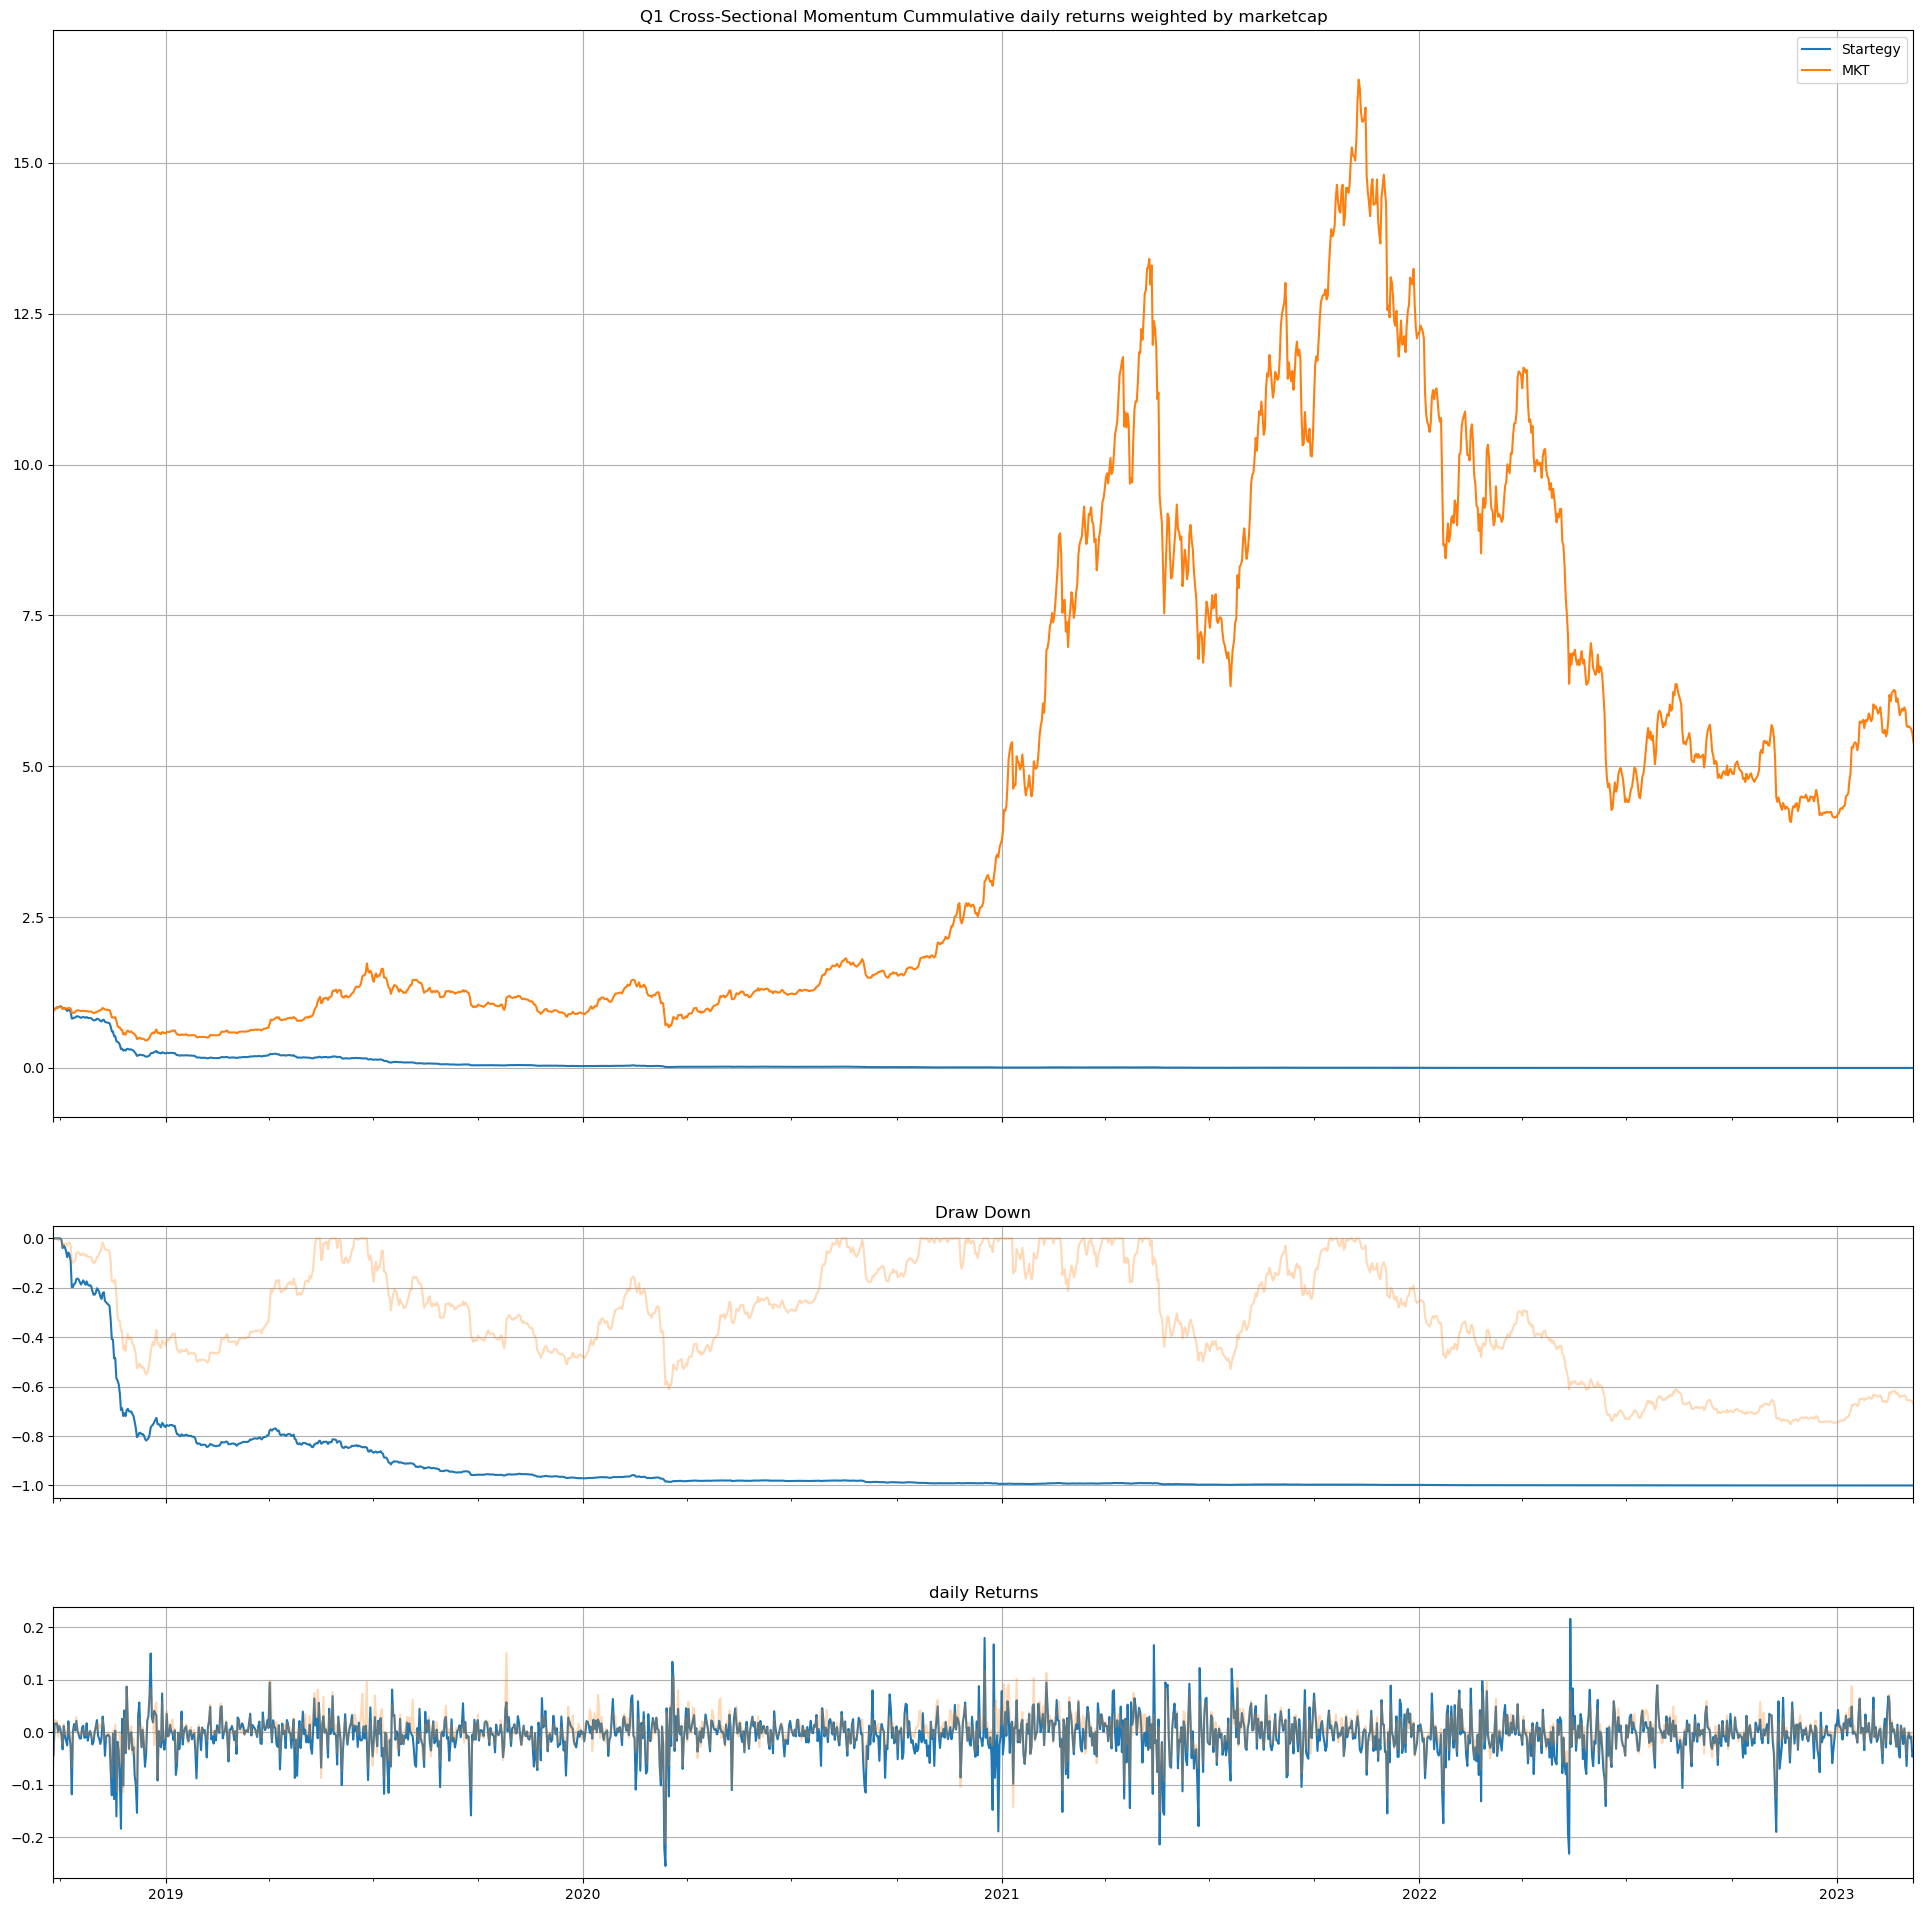

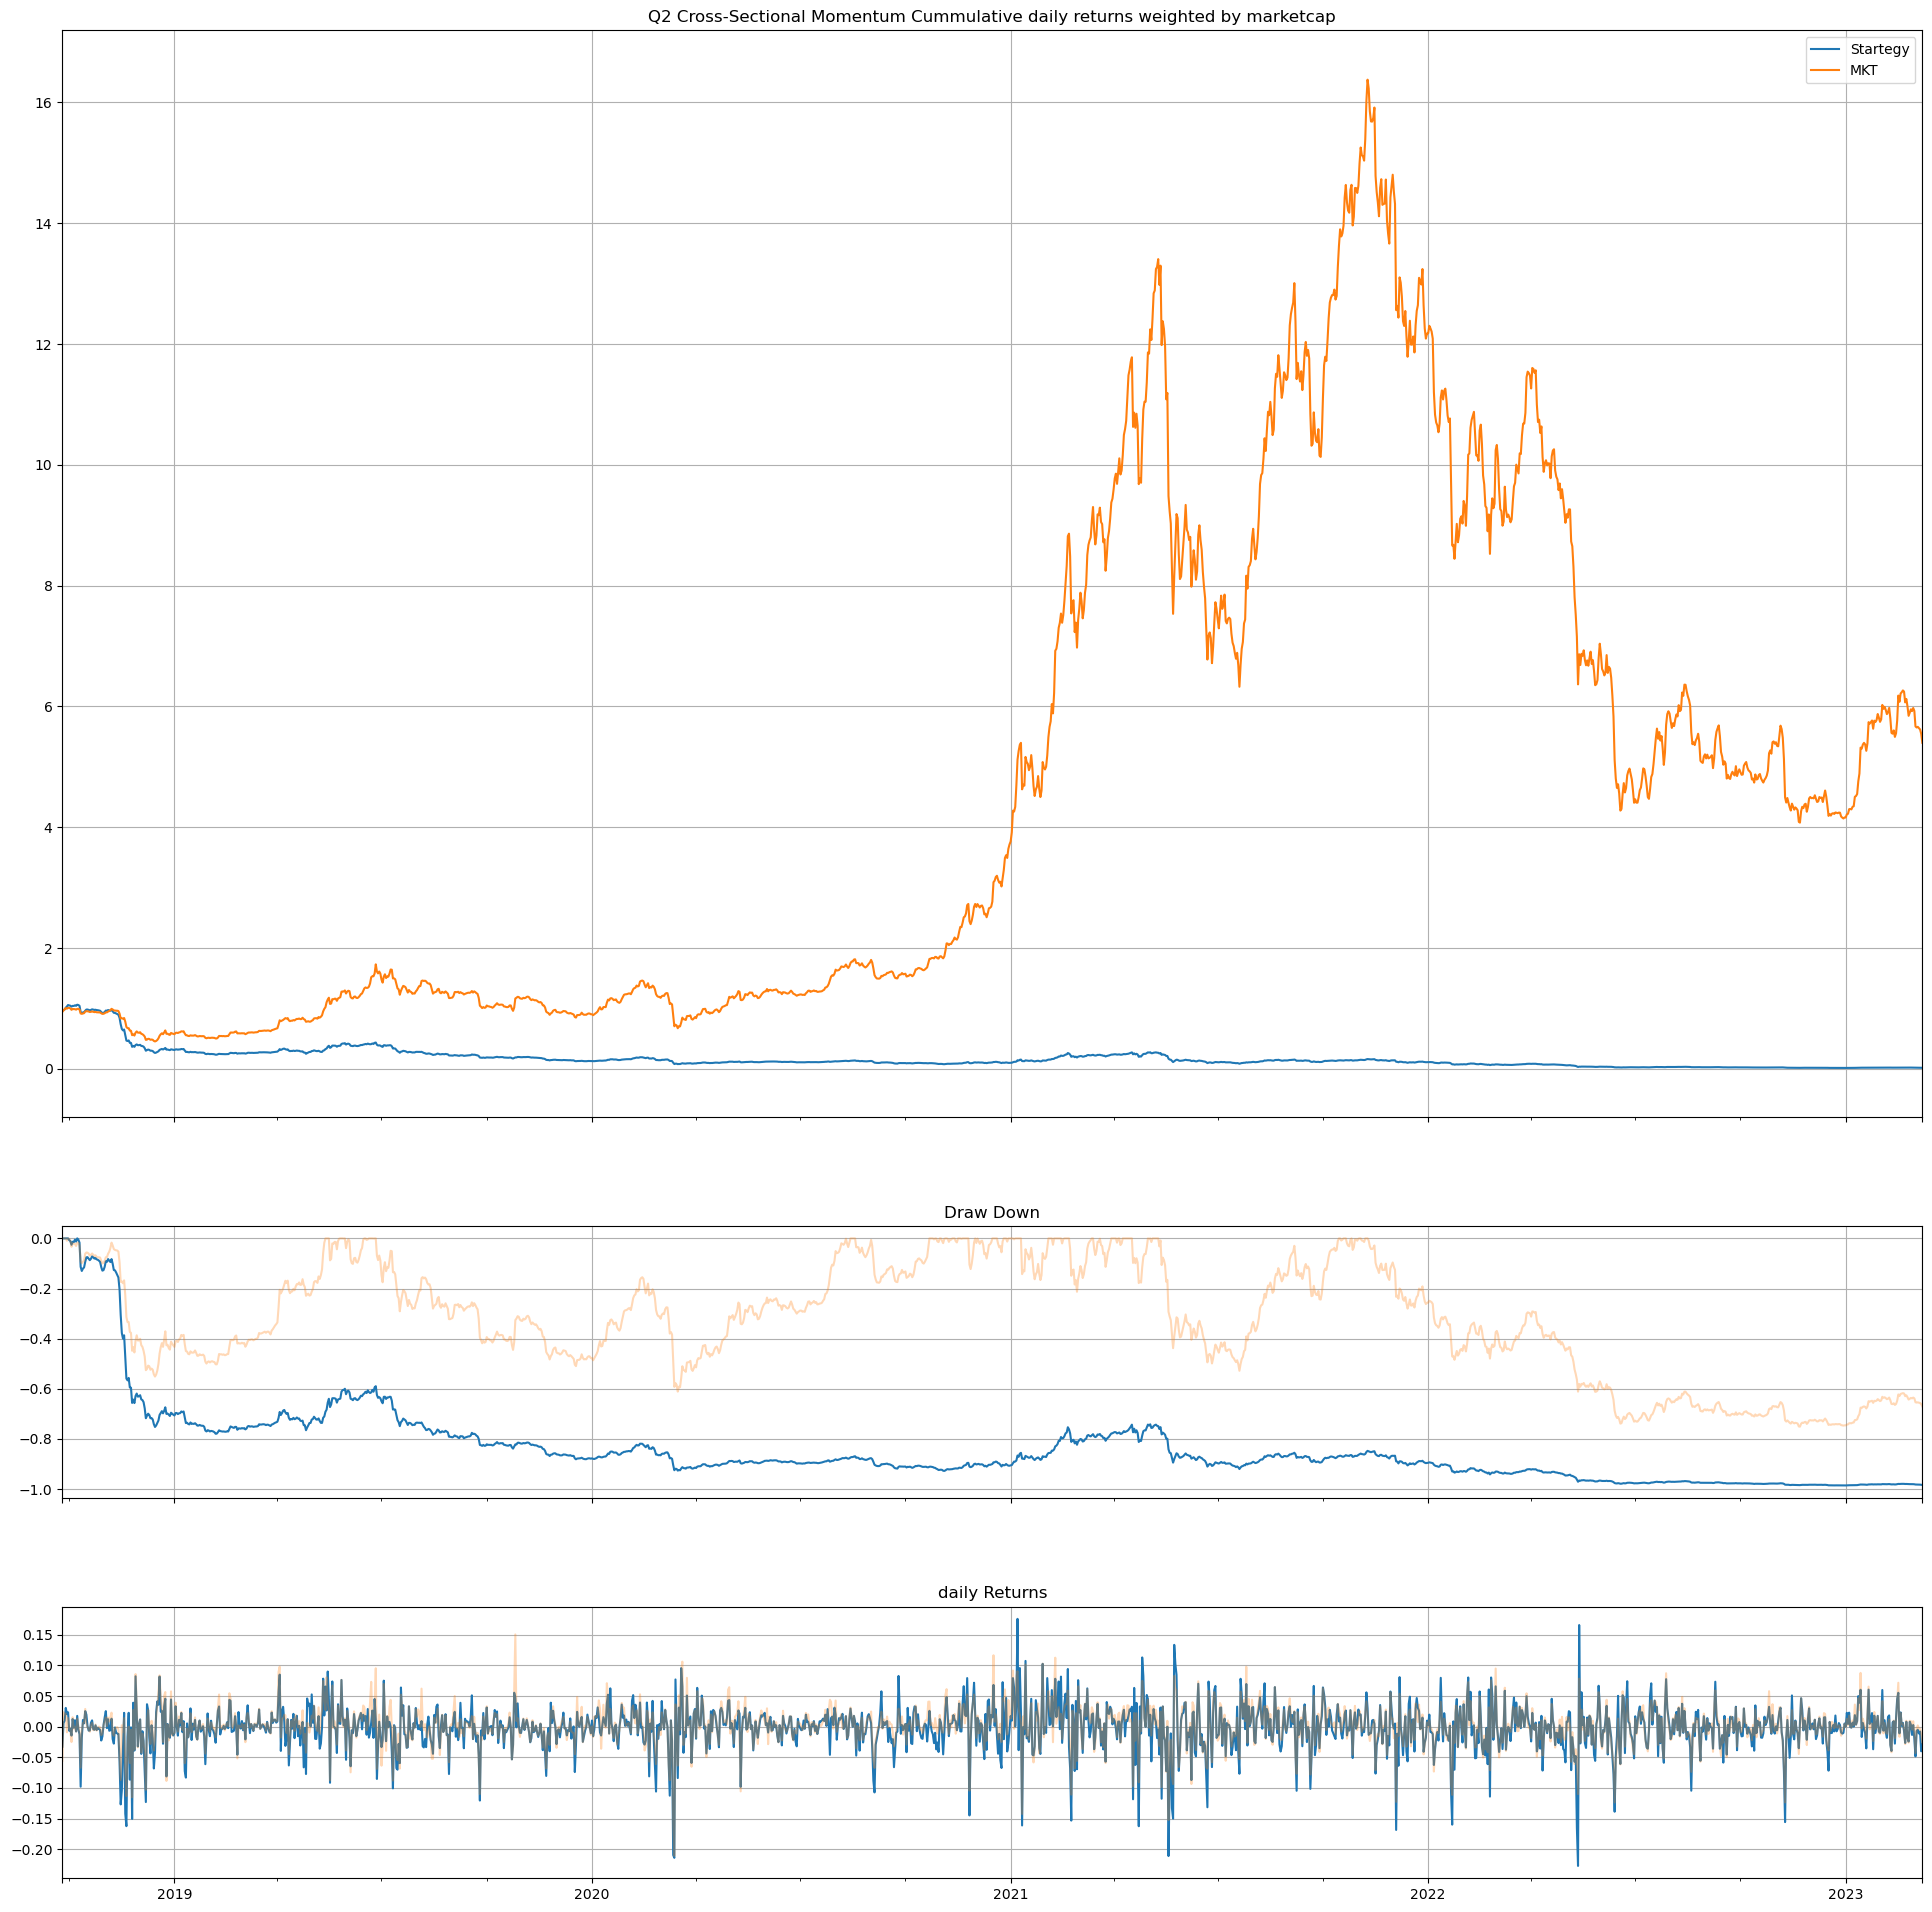

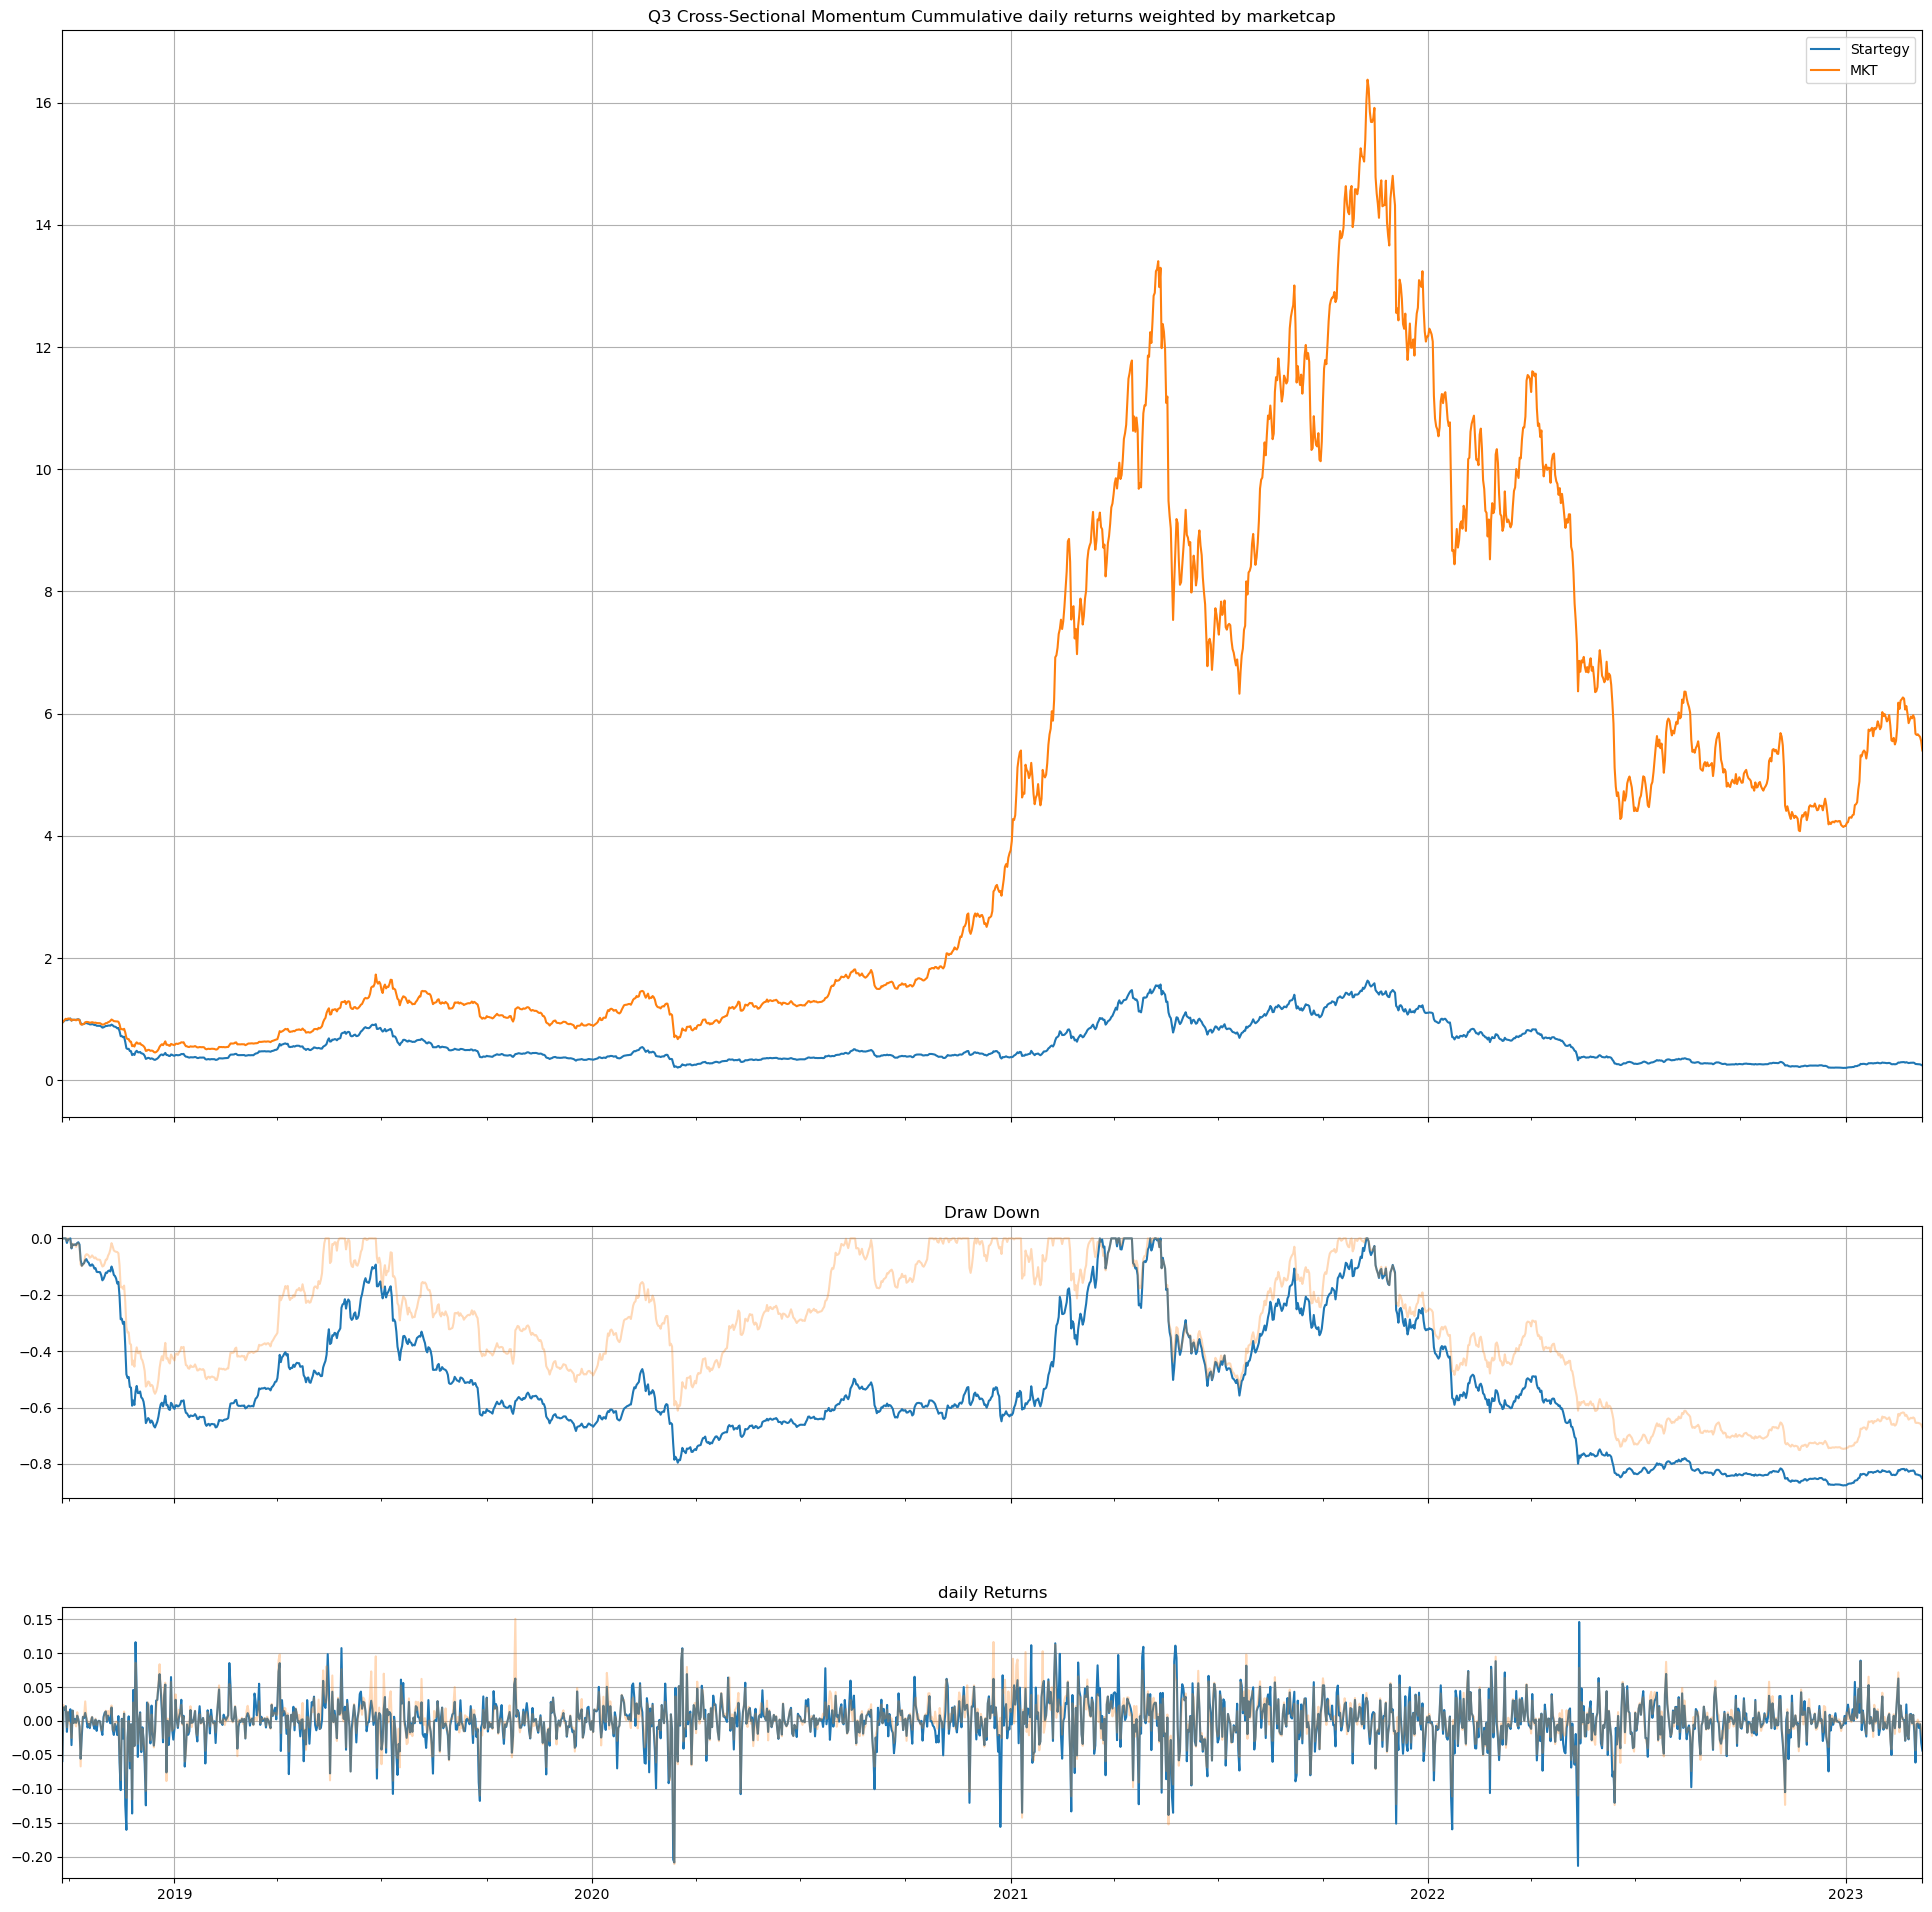

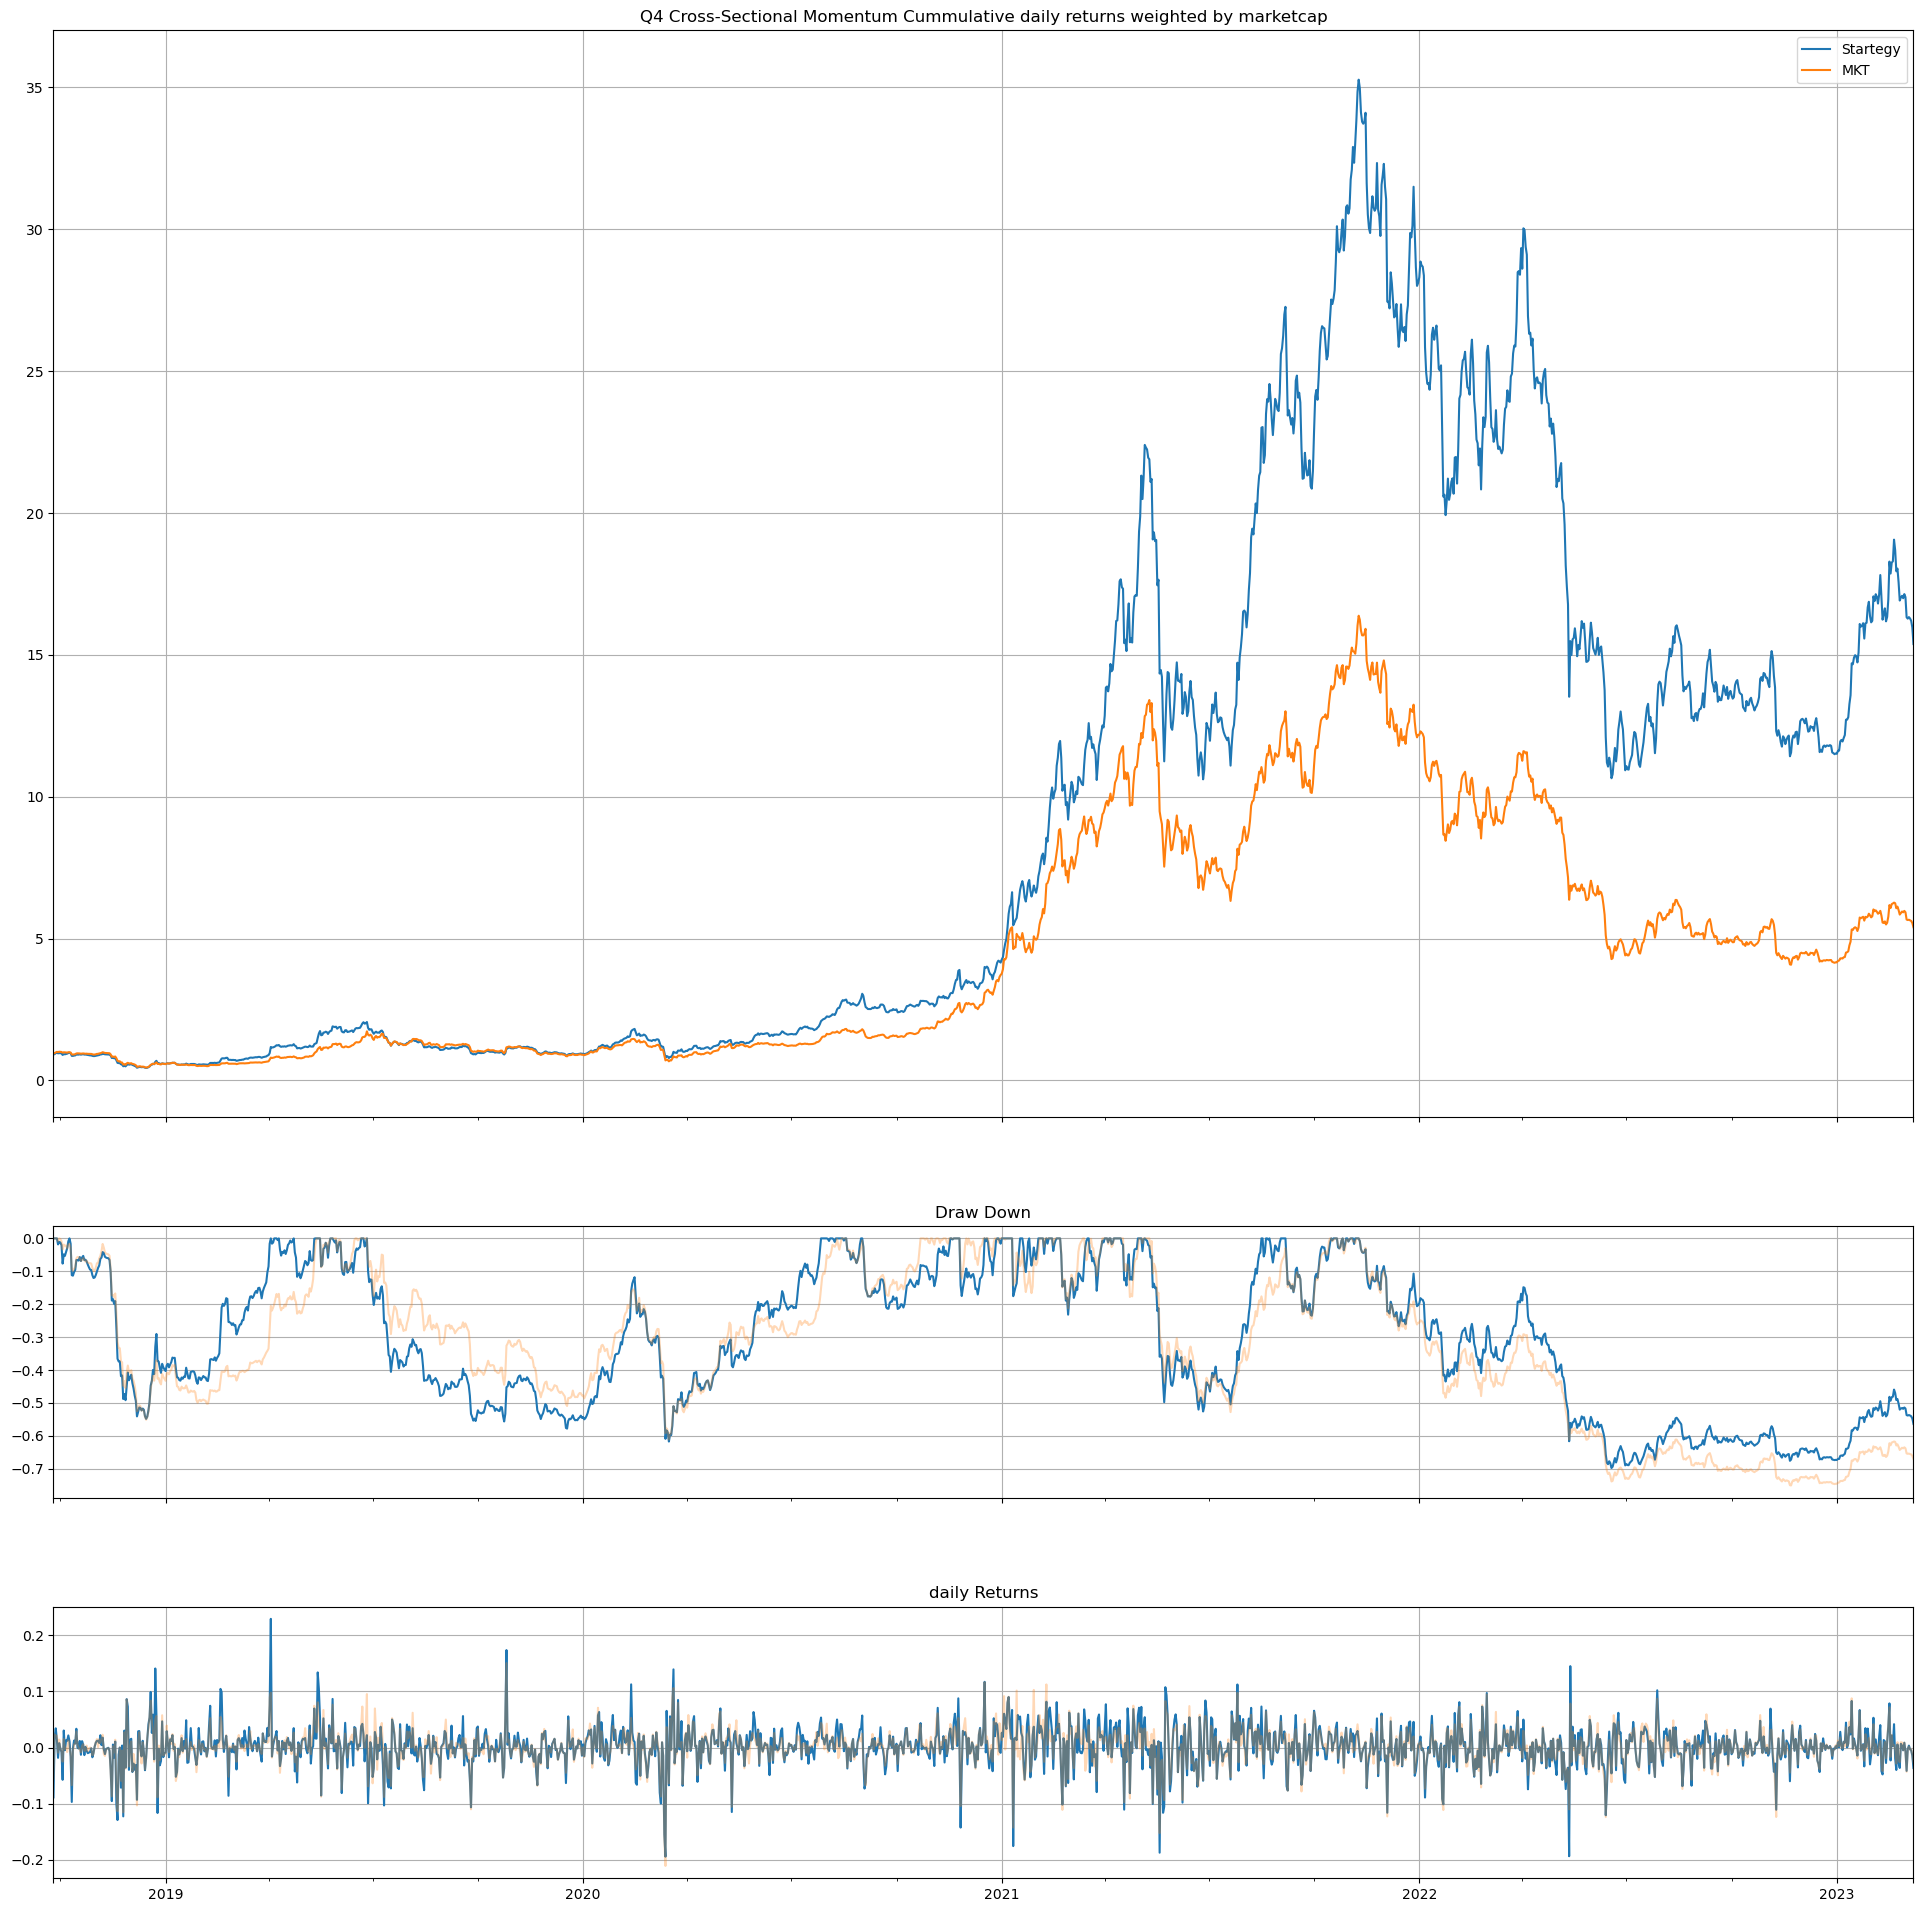

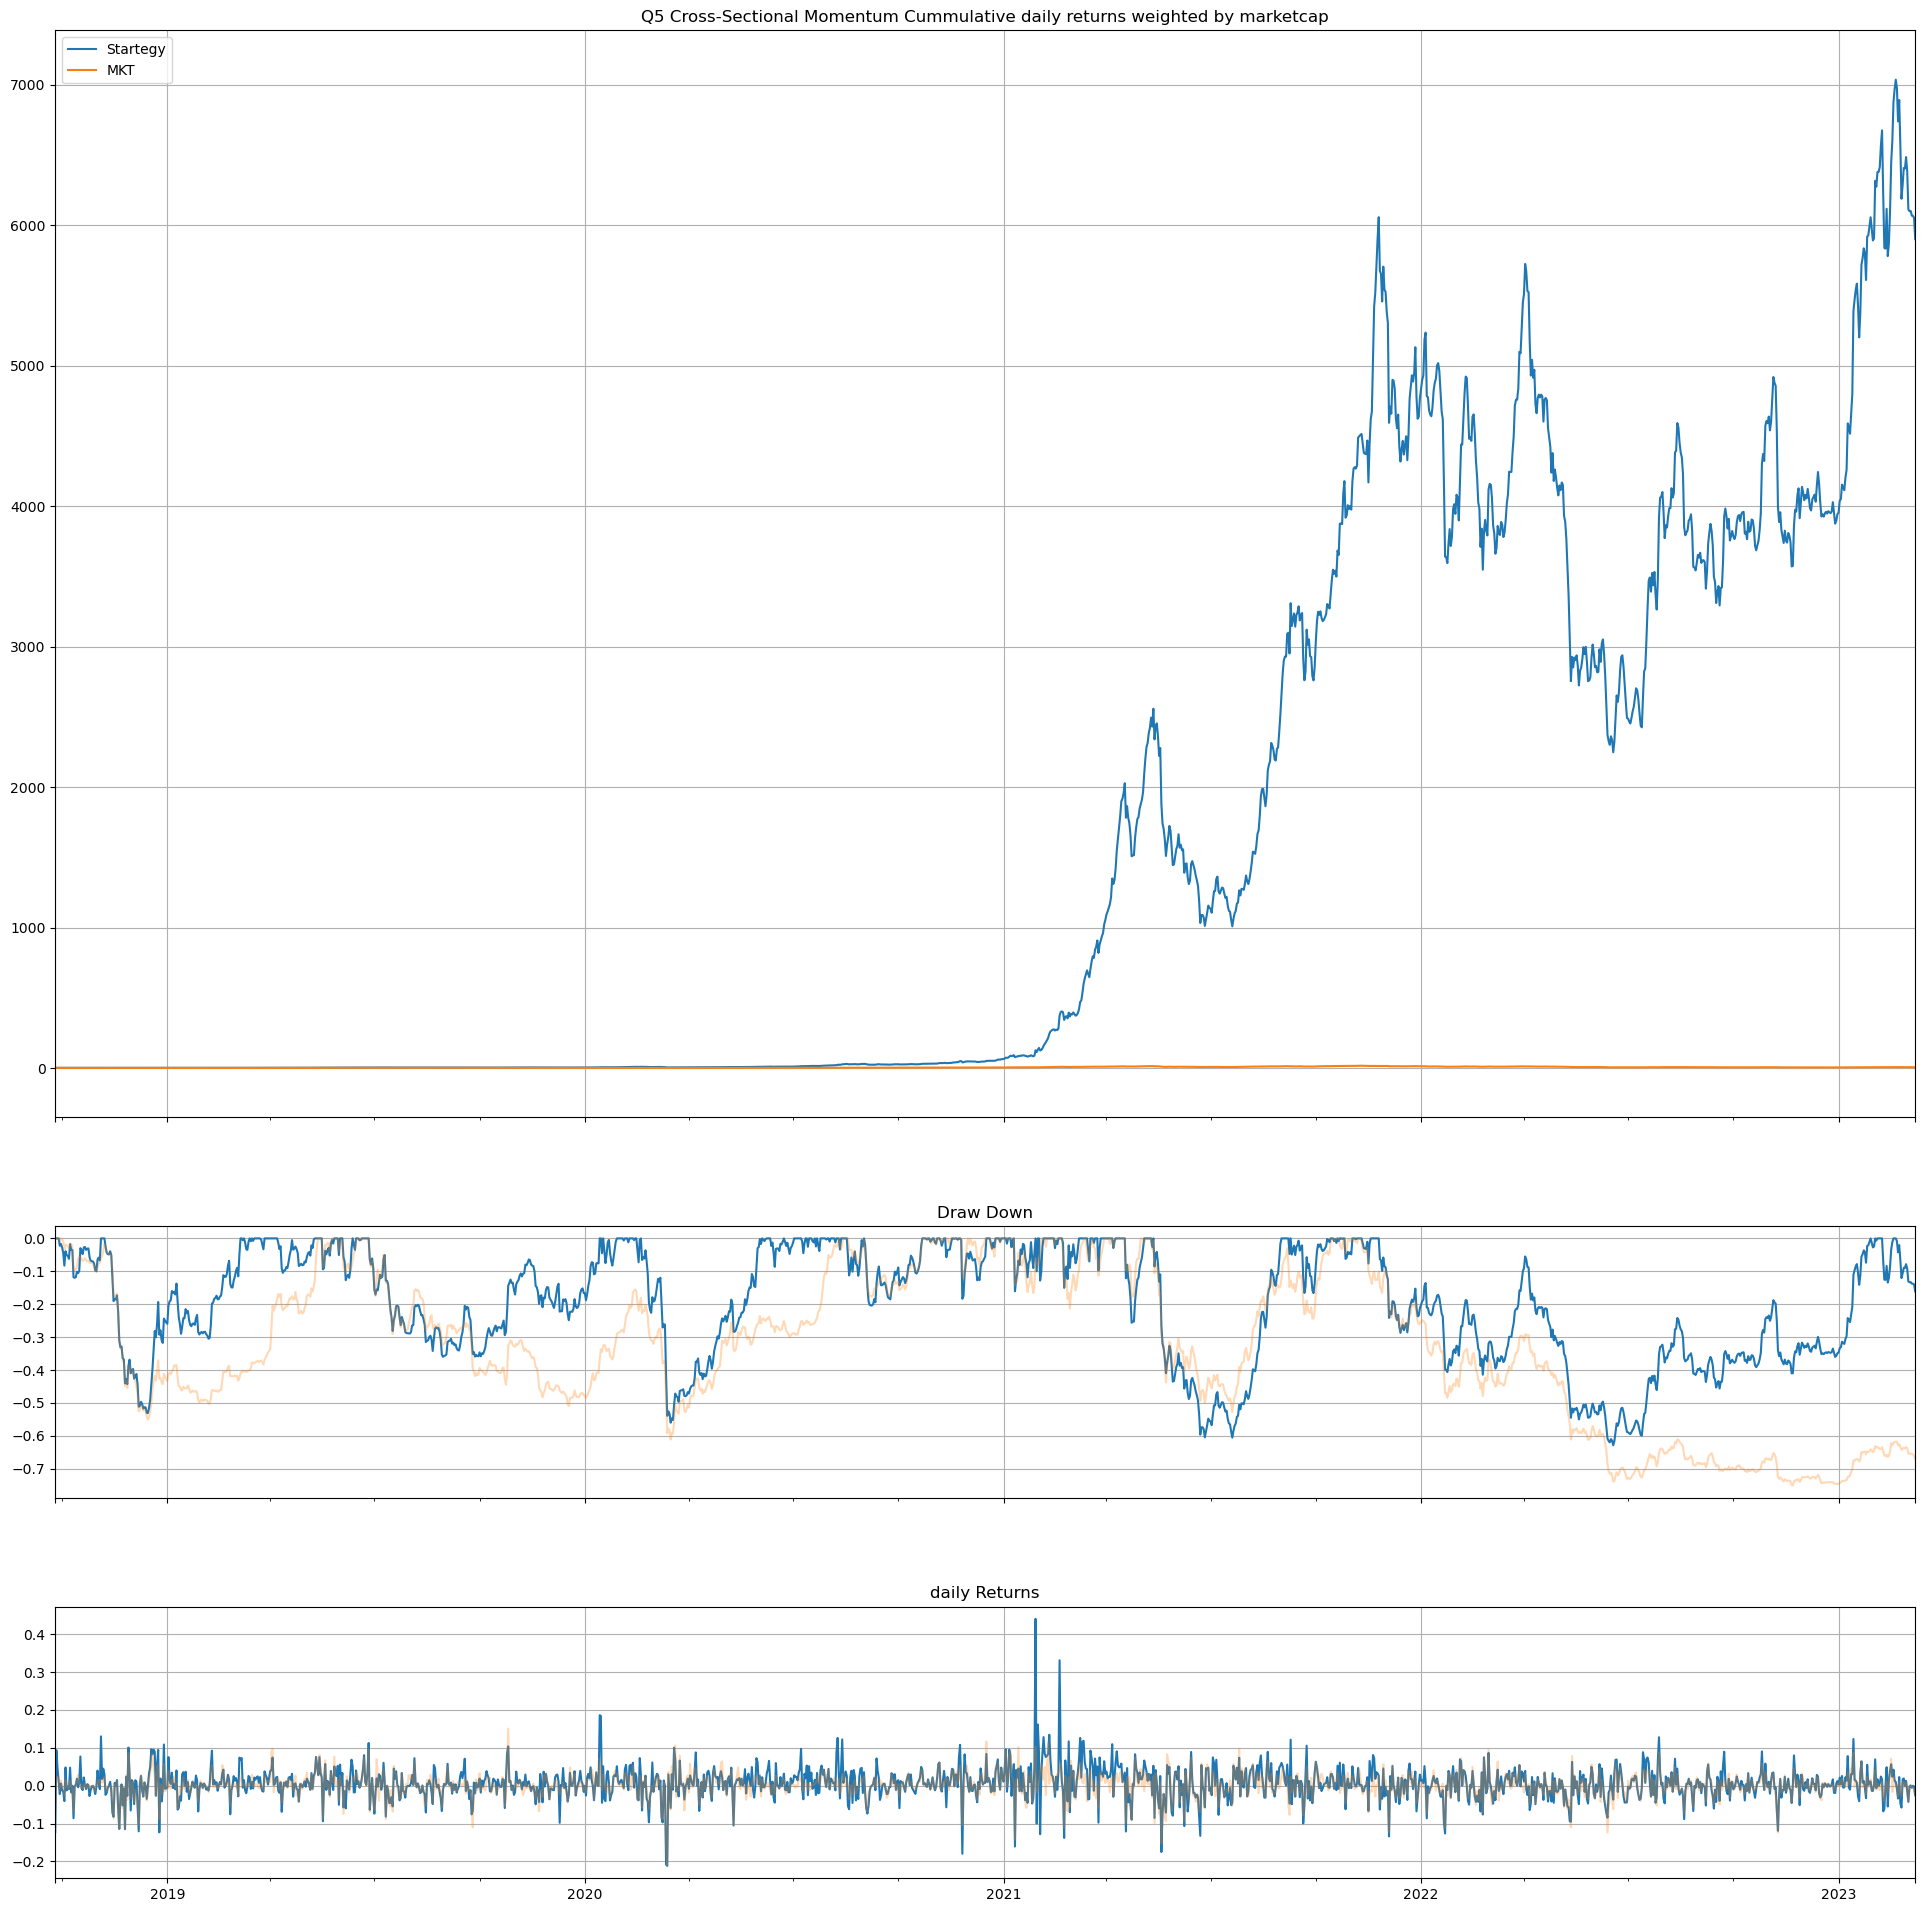

In [19]:
daily_rol.draw_return_result(q5_rolling_daily, with_mkt=True)

In [20]:
daily_rol.run_alpha_regression(q5_rolling_daily)

Q1 Regression Result
                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.643     
Dependent Variable: y                AIC:                -9150.9764
Date:               2023-03-31 21:03 BIC:                -9139.7000
No. Observations:   2076             Log-Likelihood:     4577.5    
Df Model:           1                F-statistic:        3744.     
Df Residuals:       2074             Prob (F-statistic): 0.00      
R-squared:          0.644            Scale:              0.00071243
---------------------------------------------------------------------
            Coef.    Std.Err.      t       P>|t|     [0.025    0.975]
---------------------------------------------------------------------
const      -0.0075     0.0006   -12.7786   0.0000   -0.0087   -0.0063
0           1.0855     0.0177    61.1858   0.0000    1.0508    1.1203
-------------------------------------------------------------------
Omnibus:             350.460       

In [20]:
daily_rol.print_statistics(q5_rolling_daily, with_mkt=True)

Q1         Q2         Q3         Q4          Q5        MKT
CAGR  -88.177818 -59.432179 -26.375224  88.513999  622.280775  47.875499
Mean   -0.005014  -0.001789  -0.000254   0.002314    0.006213   0.001530
STD     0.040426   0.036814   0.034814   0.035395    0.041850   0.031196
Shape  -2.369596  -0.928409  -0.139387   1.249033    2.836288   0.937122

In [22]:
new_dict = {key: df for key, df in q5_rolling_daily.items() if key != "count"}

# 상관관계 map 출력
pd.concat([pd.DataFrame(new_dict), mkt_index.loc["2017-07-03":]],
          axis=1).corr()

Q1        Q2        Q3        Q4        Q5         0
Q1  1.000000  0.861404  0.743699  0.715372  0.527198  0.802186
Q2  0.861404  1.000000  0.787953  0.775669  0.584200  0.865966
Q3  0.743699  0.787953  1.000000  0.761042  0.578629  0.849449
Q4  0.715372  0.775669  0.761042  1.000000  0.629152  0.873327
Q5  0.527198  0.584200  0.578629  0.629152  1.000000  0.730708
0   0.802186  0.865966  0.849449  0.873327  0.730708  1.000000

### Q5-Q1

In [23]:
q5_q1_weekly = (q5_weekly["Q5"] - q5_weekly["Q1"])
q5_q1_daily = (q5_daily["Q5"] - q5_daily["Q1"])
q5_q1_daily_rolling = (q5_rolling_daily["Q5"] - q5_rolling_daily["Q1"])

<AxesSubplot:>

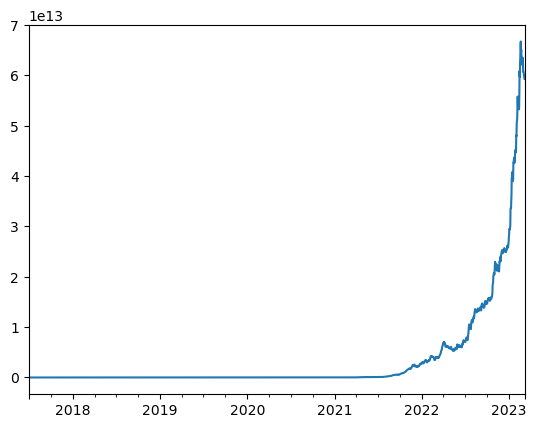

In [45]:
(q5_daily["Q5"]+1).cumprod().plot()

Text(0.5, 1.0, 'Q1 Short')

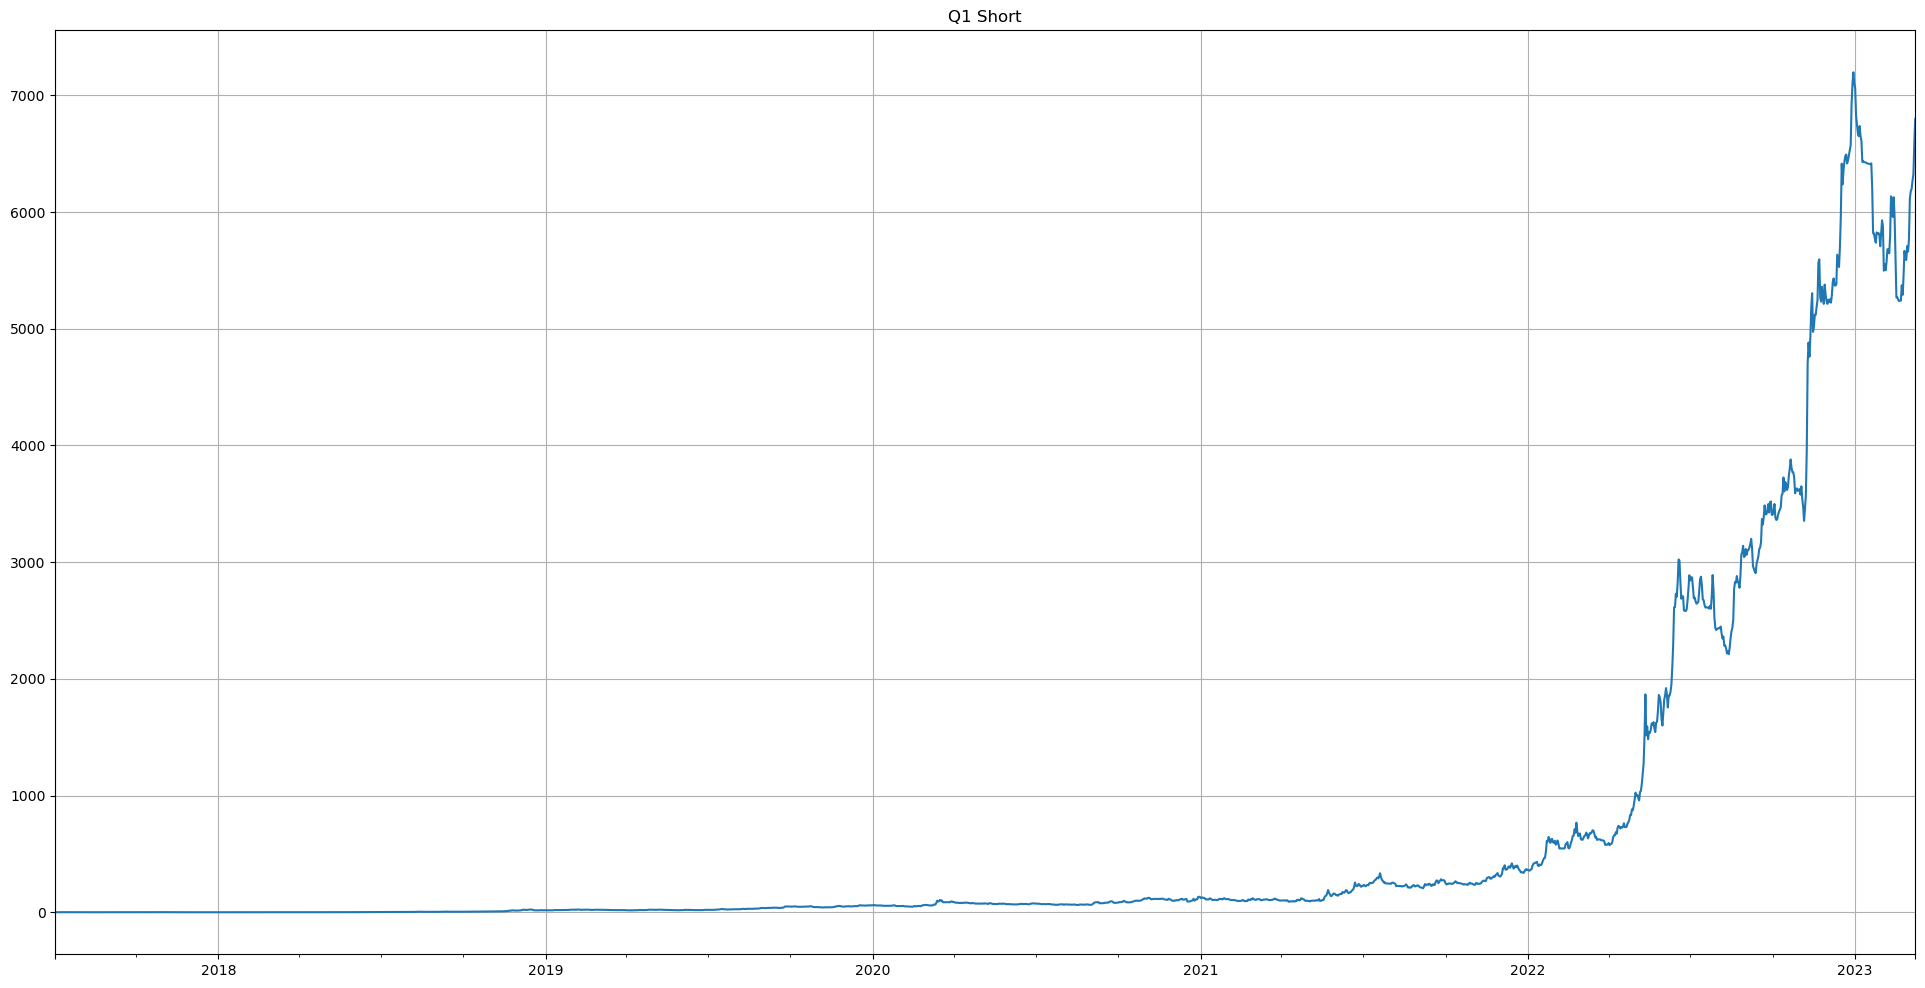

In [50]:
((-q5_rolling_daily["Q1"]) + 1).cumprod().plot(figsize=(24,12))
plt.grid()
plt.title("Q1 Short")

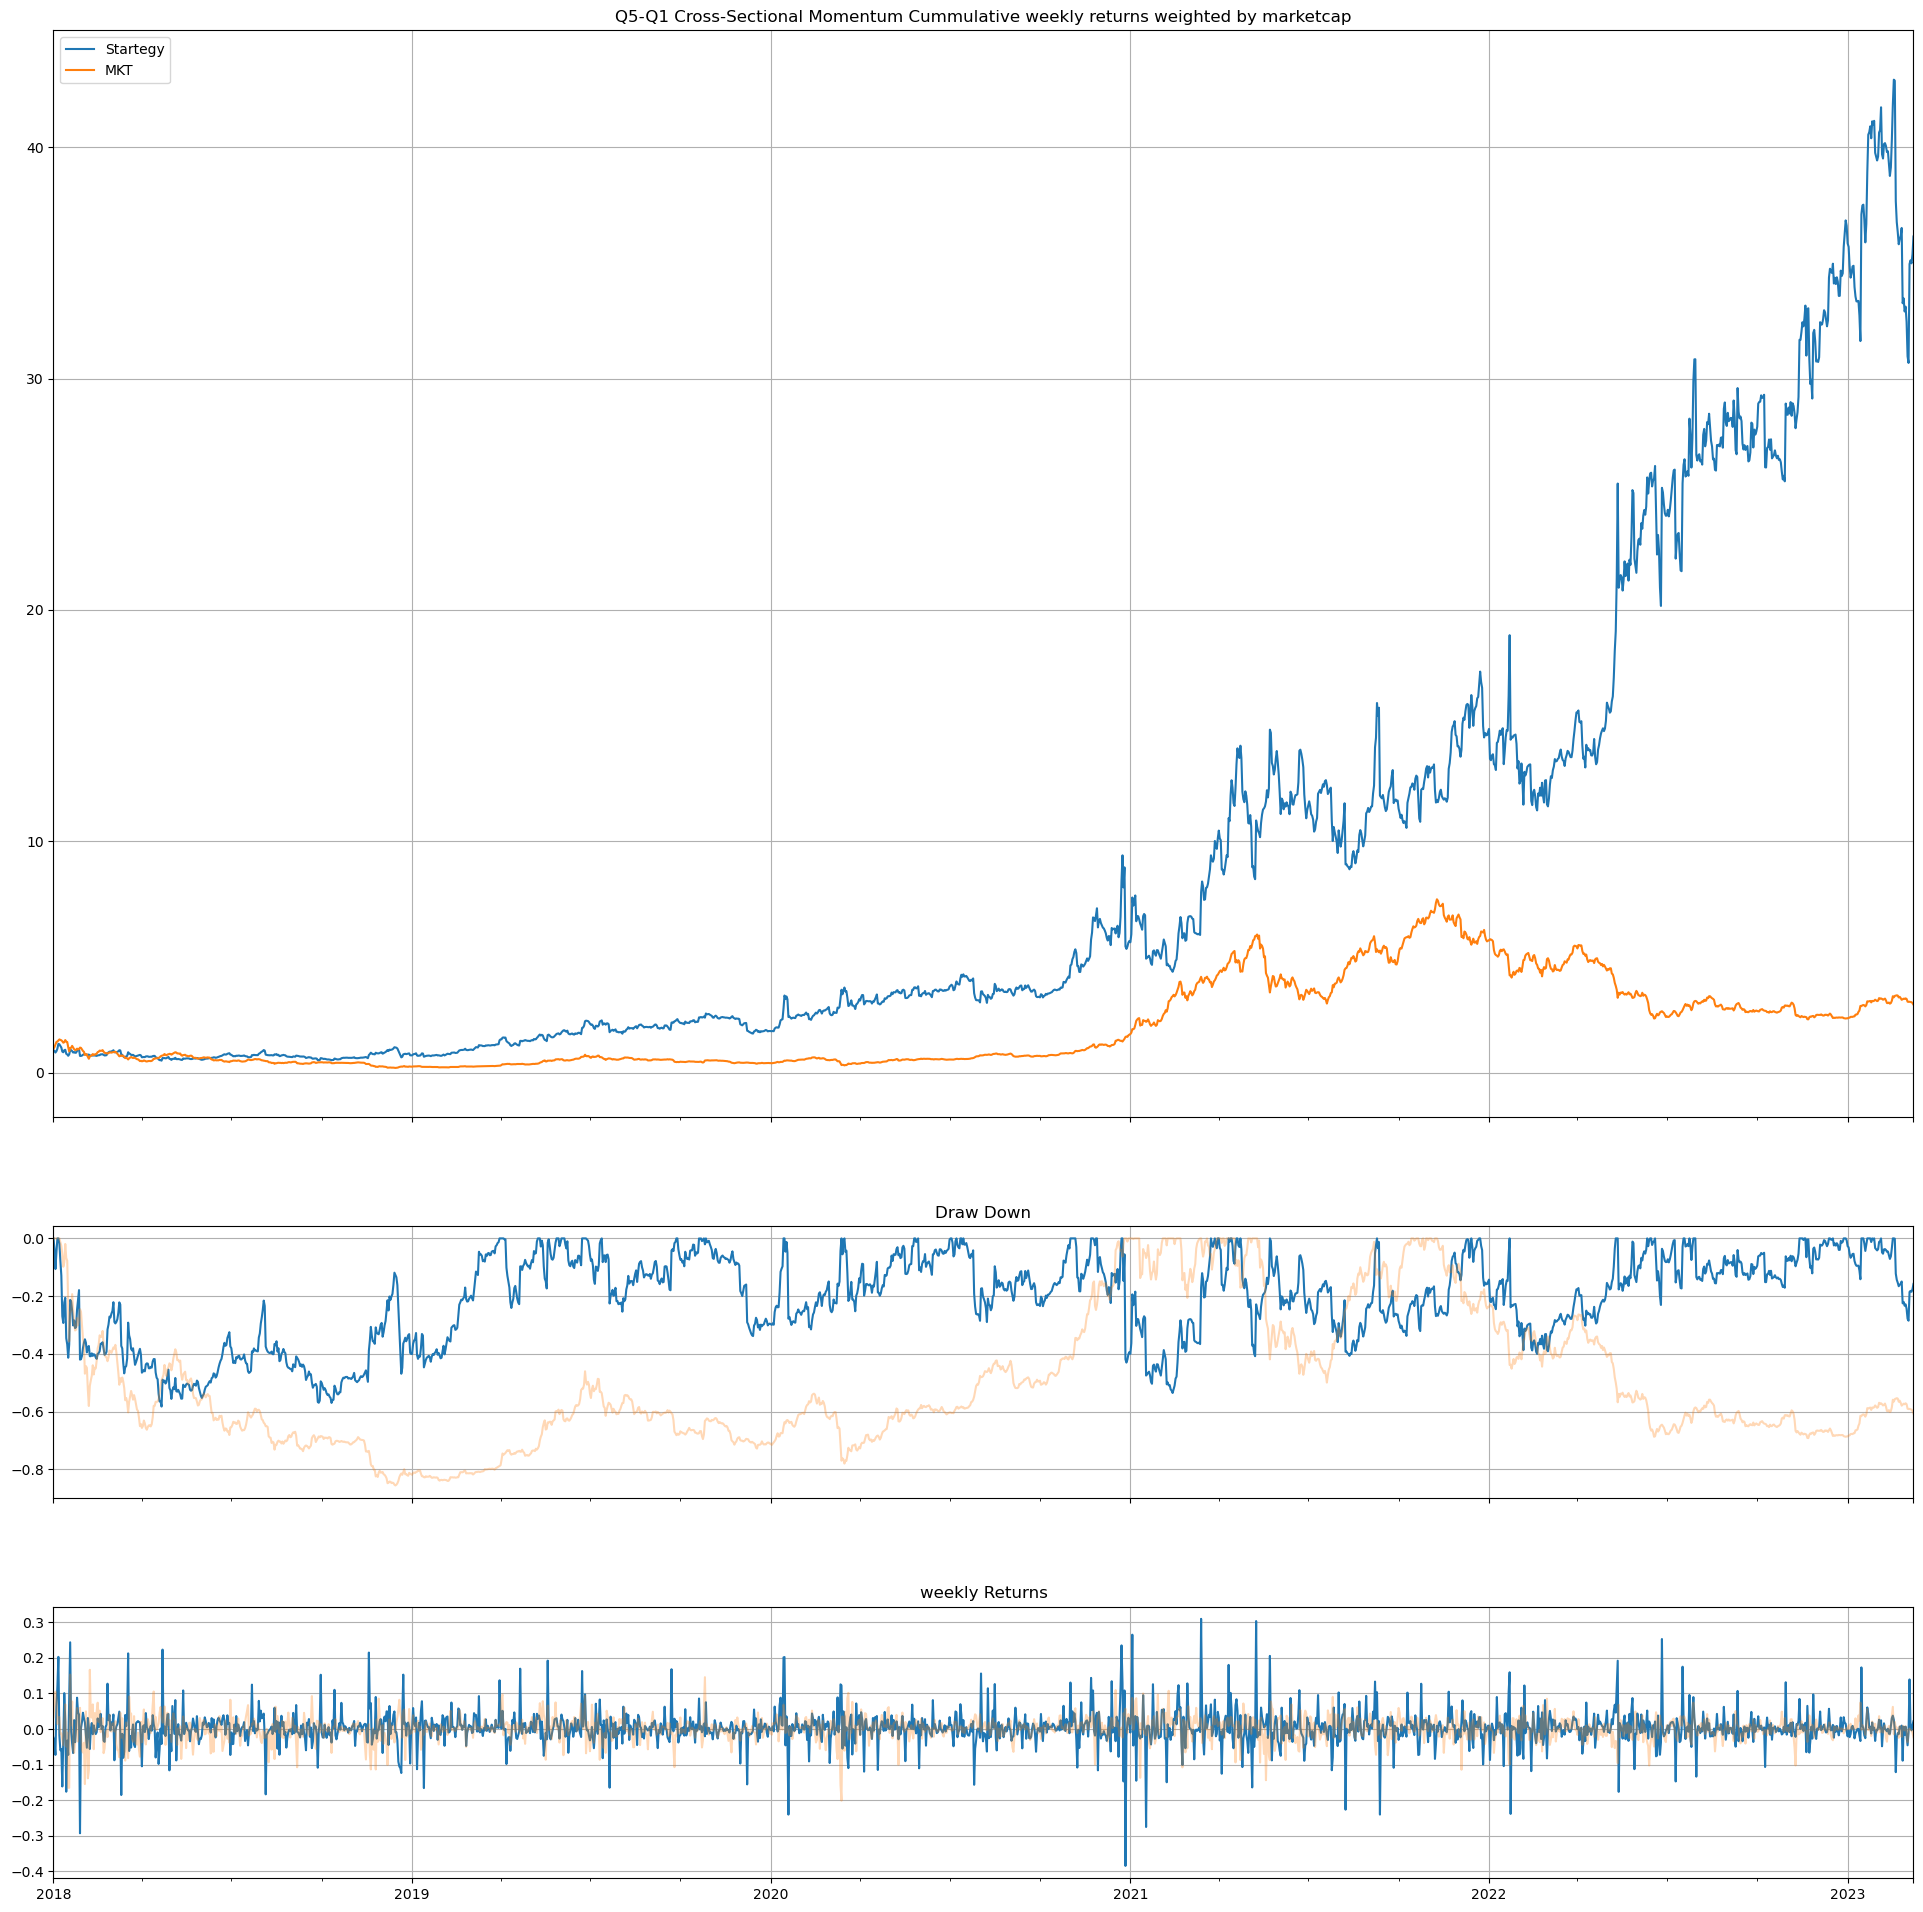

In [25]:
weekly.draw_return_result({"Q5-Q1":q5_q1_weekly["2018":]},
                          with_mkt=True,
                          go="2018")

In [26]:
weekly.print_statistics({"Q5-Q1":q5_q1_weekly["2018":],
                        "Q5-Q2":q5_q1_weekly["2018":],
                        "count":q5_q1_weekly["2018":]},
                        with_mkt=True,
                        go="2018")

Q5-Q1       Q5-Q2        MKT
CAGR   100.602981  100.602981  22.348340
Mean     0.003056    0.003056   0.001087
STD      0.047949    0.047949   0.031953
Shape    1.217643    1.217643   0.650230

In [27]:
weekly.run_alpha_regression({"Q5-Q1":q5_q1_weekly["2018":]},
                            go="2018")

Q5-Q1 Regression Result
                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.006     
Dependent Variable: y                AIC:                -6140.6713
Date:               2023-03-31 21:03 BIC:                -6129.5784
No. Observations:   1894             Log-Likelihood:     3072.3    
Df Model:           1                F-statistic:        12.14     
Df Residuals:       1892             Prob (F-statistic): 0.000504  
R-squared:          0.006            Scale:              0.0022857 
---------------------------------------------------------------------
             Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
---------------------------------------------------------------------
const        0.0032     0.0011    2.8991   0.0038    0.0010    0.0053
0           -0.1198     0.0344   -3.4847   0.0005   -0.1873   -0.0524
-------------------------------------------------------------------
Omnibus:             354.631    

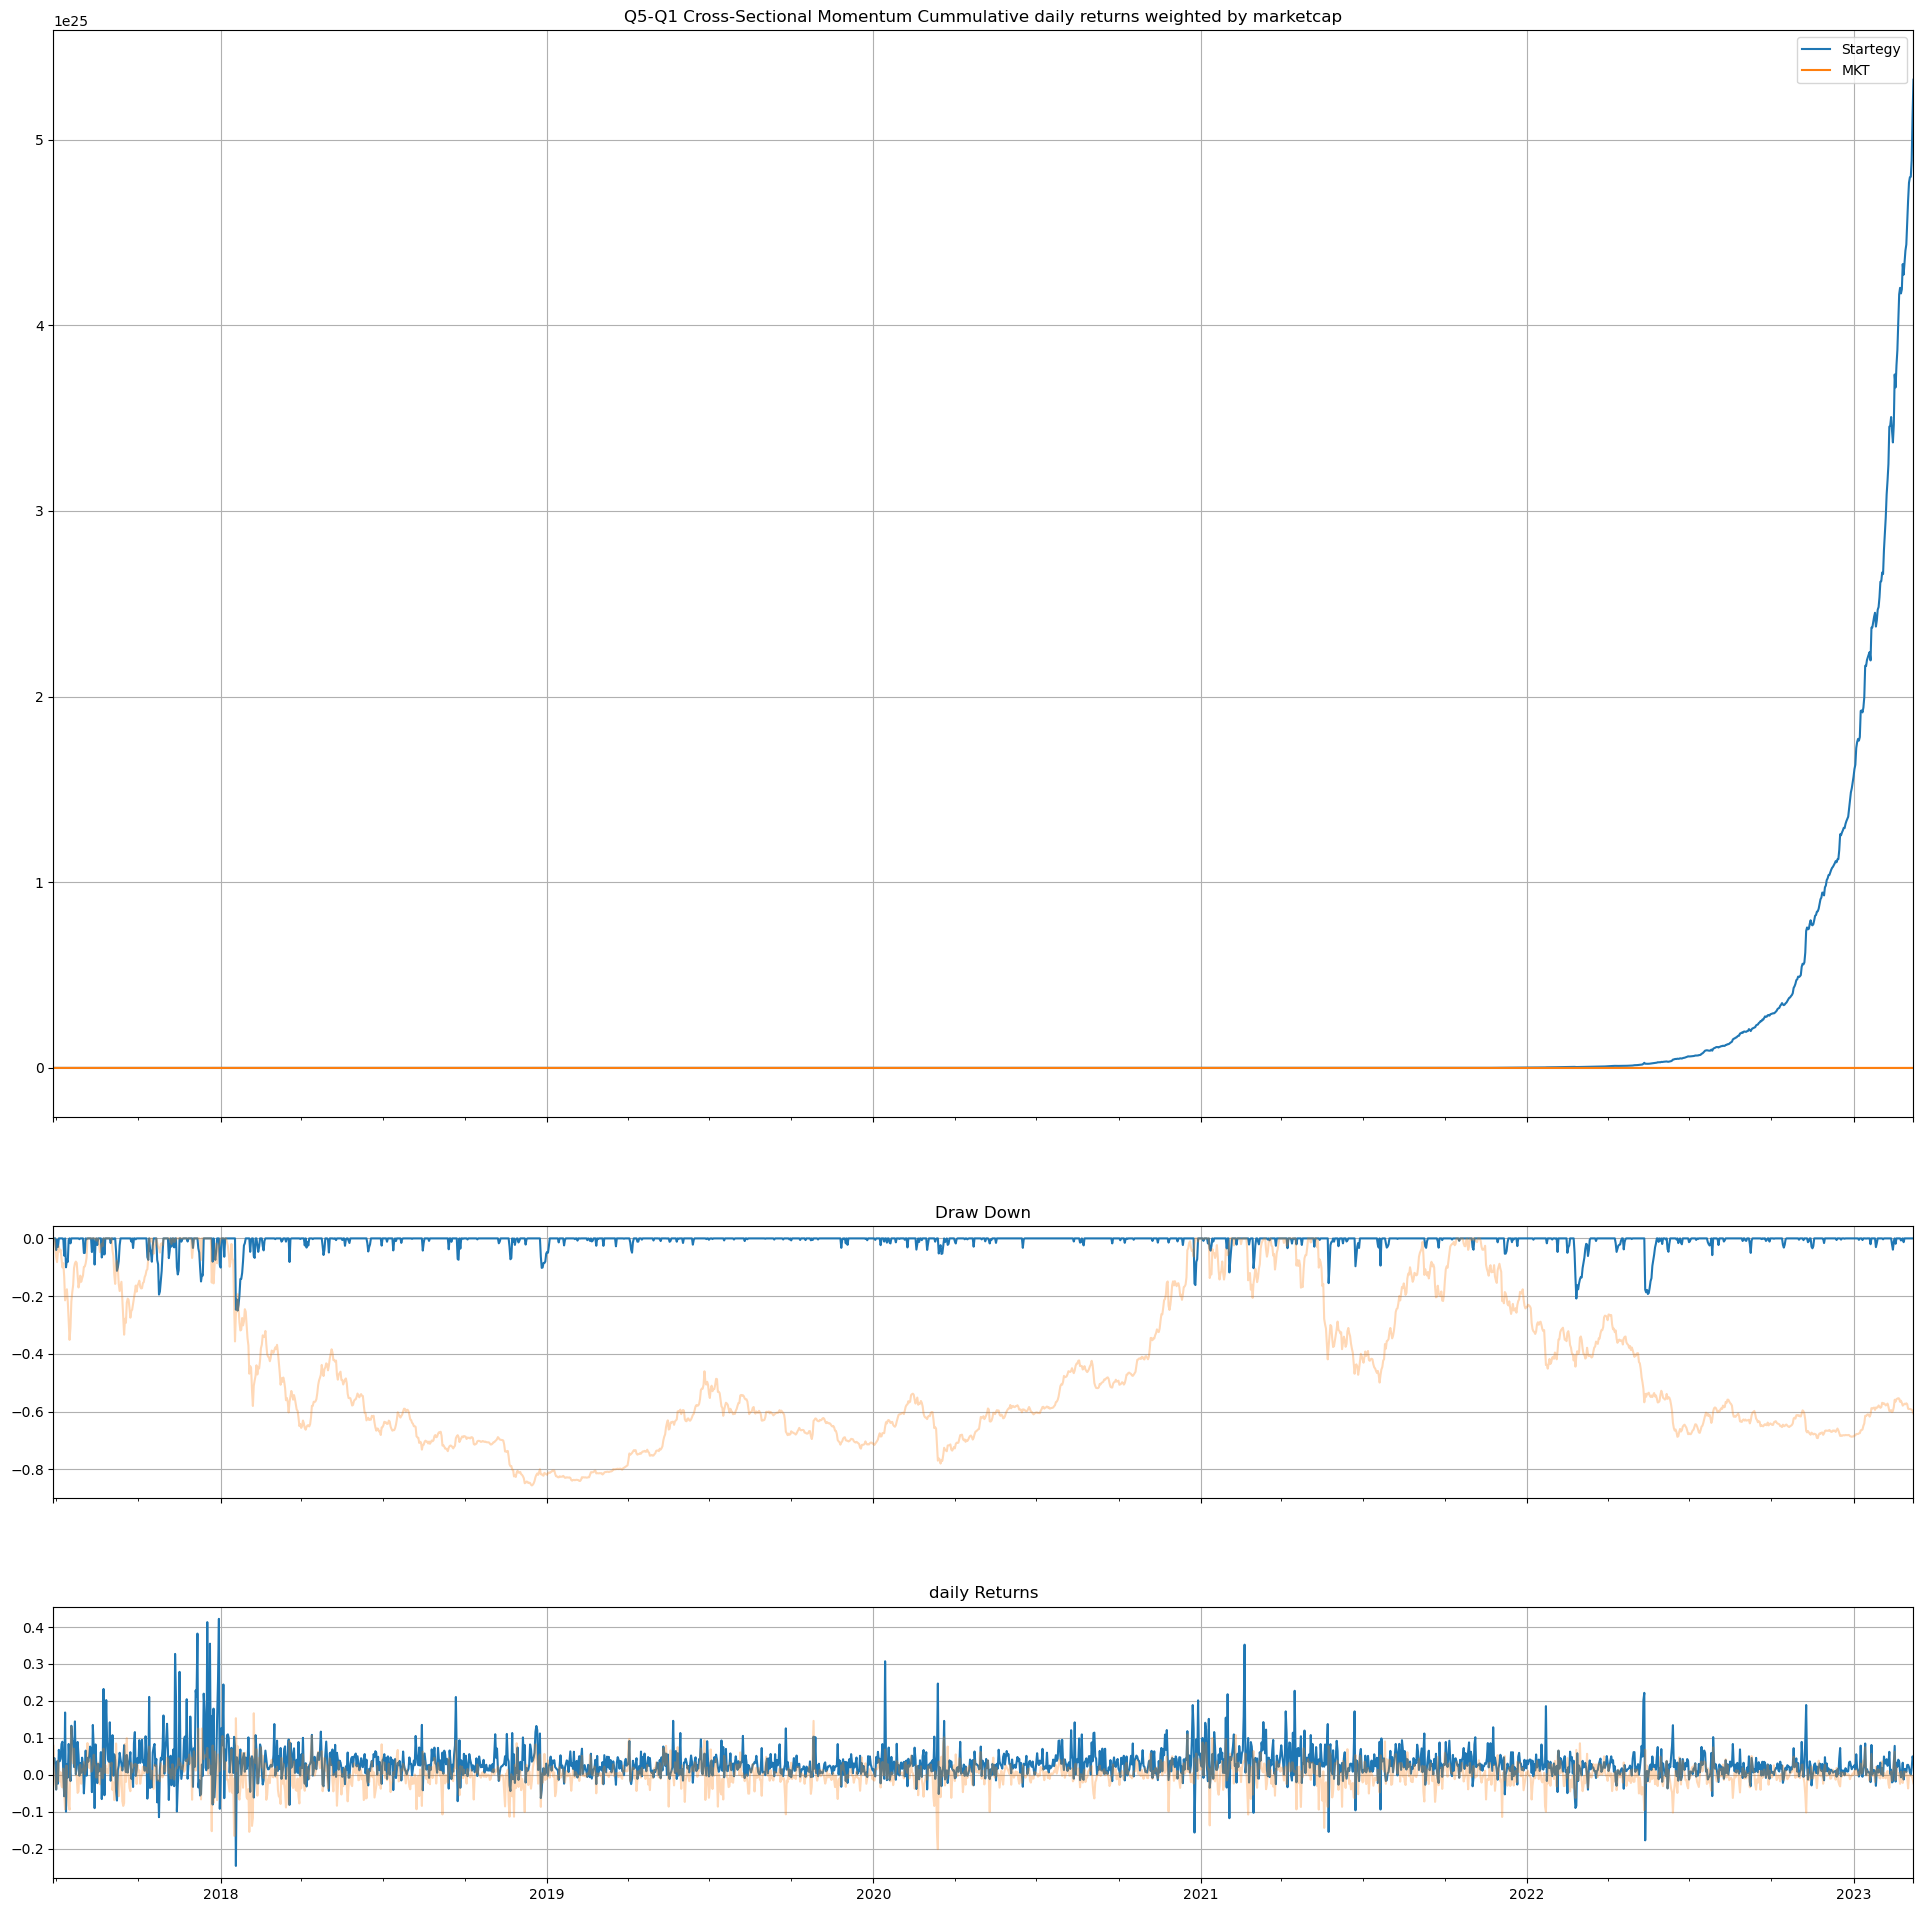

In [28]:
daily.draw_return_result({"Q5-Q1":q5_q1_daily},
                          with_mkt=True
                          )

In [29]:
daily.print_statistics({"Q5-Q1":q5_q1_daily["2018":],
                        "Q5-Q2":q5_q1_daily["2018":],
                        "count":q5_q1_daily["2018":]},
                        with_mkt=True
                        )

Q5-Q1         Q5-Q2        MKT
CAGR   1.763596e+06  1.763596e+06  71.362407
Mean   2.781400e-02  2.781400e-02   0.002066
STD    3.746186e-02  3.746186e-02   0.033053
Shape  1.418471e+01  1.418471e+01   1.193909

In [30]:
daily.run_alpha_regression({"Q5-Q1":q5_q1_daily})

Q5-Q1 Regression Result
                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     -0.000    
Dependent Variable: y                AIC:                -6980.2351
Date:               2023-03-31 21:03 BIC:                -6968.9539
No. Observations:   2081             Log-Likelihood:     3492.1    
Df Model:           1                F-statistic:        0.5640    
Df Residuals:       2079             Prob (F-statistic): 0.453     
R-squared:          0.000            Scale:              0.0020435 
----------------------------------------------------------------------
          Coef.     Std.Err.       t       P>|t|      [0.025    0.975]
----------------------------------------------------------------------
const     0.0299      0.0010    30.0795    0.0000     0.0279    0.0318
0        -0.0225      0.0300    -0.7510    0.4527    -0.0813    0.0363
-------------------------------------------------------------------
Omnibus:             1118.7

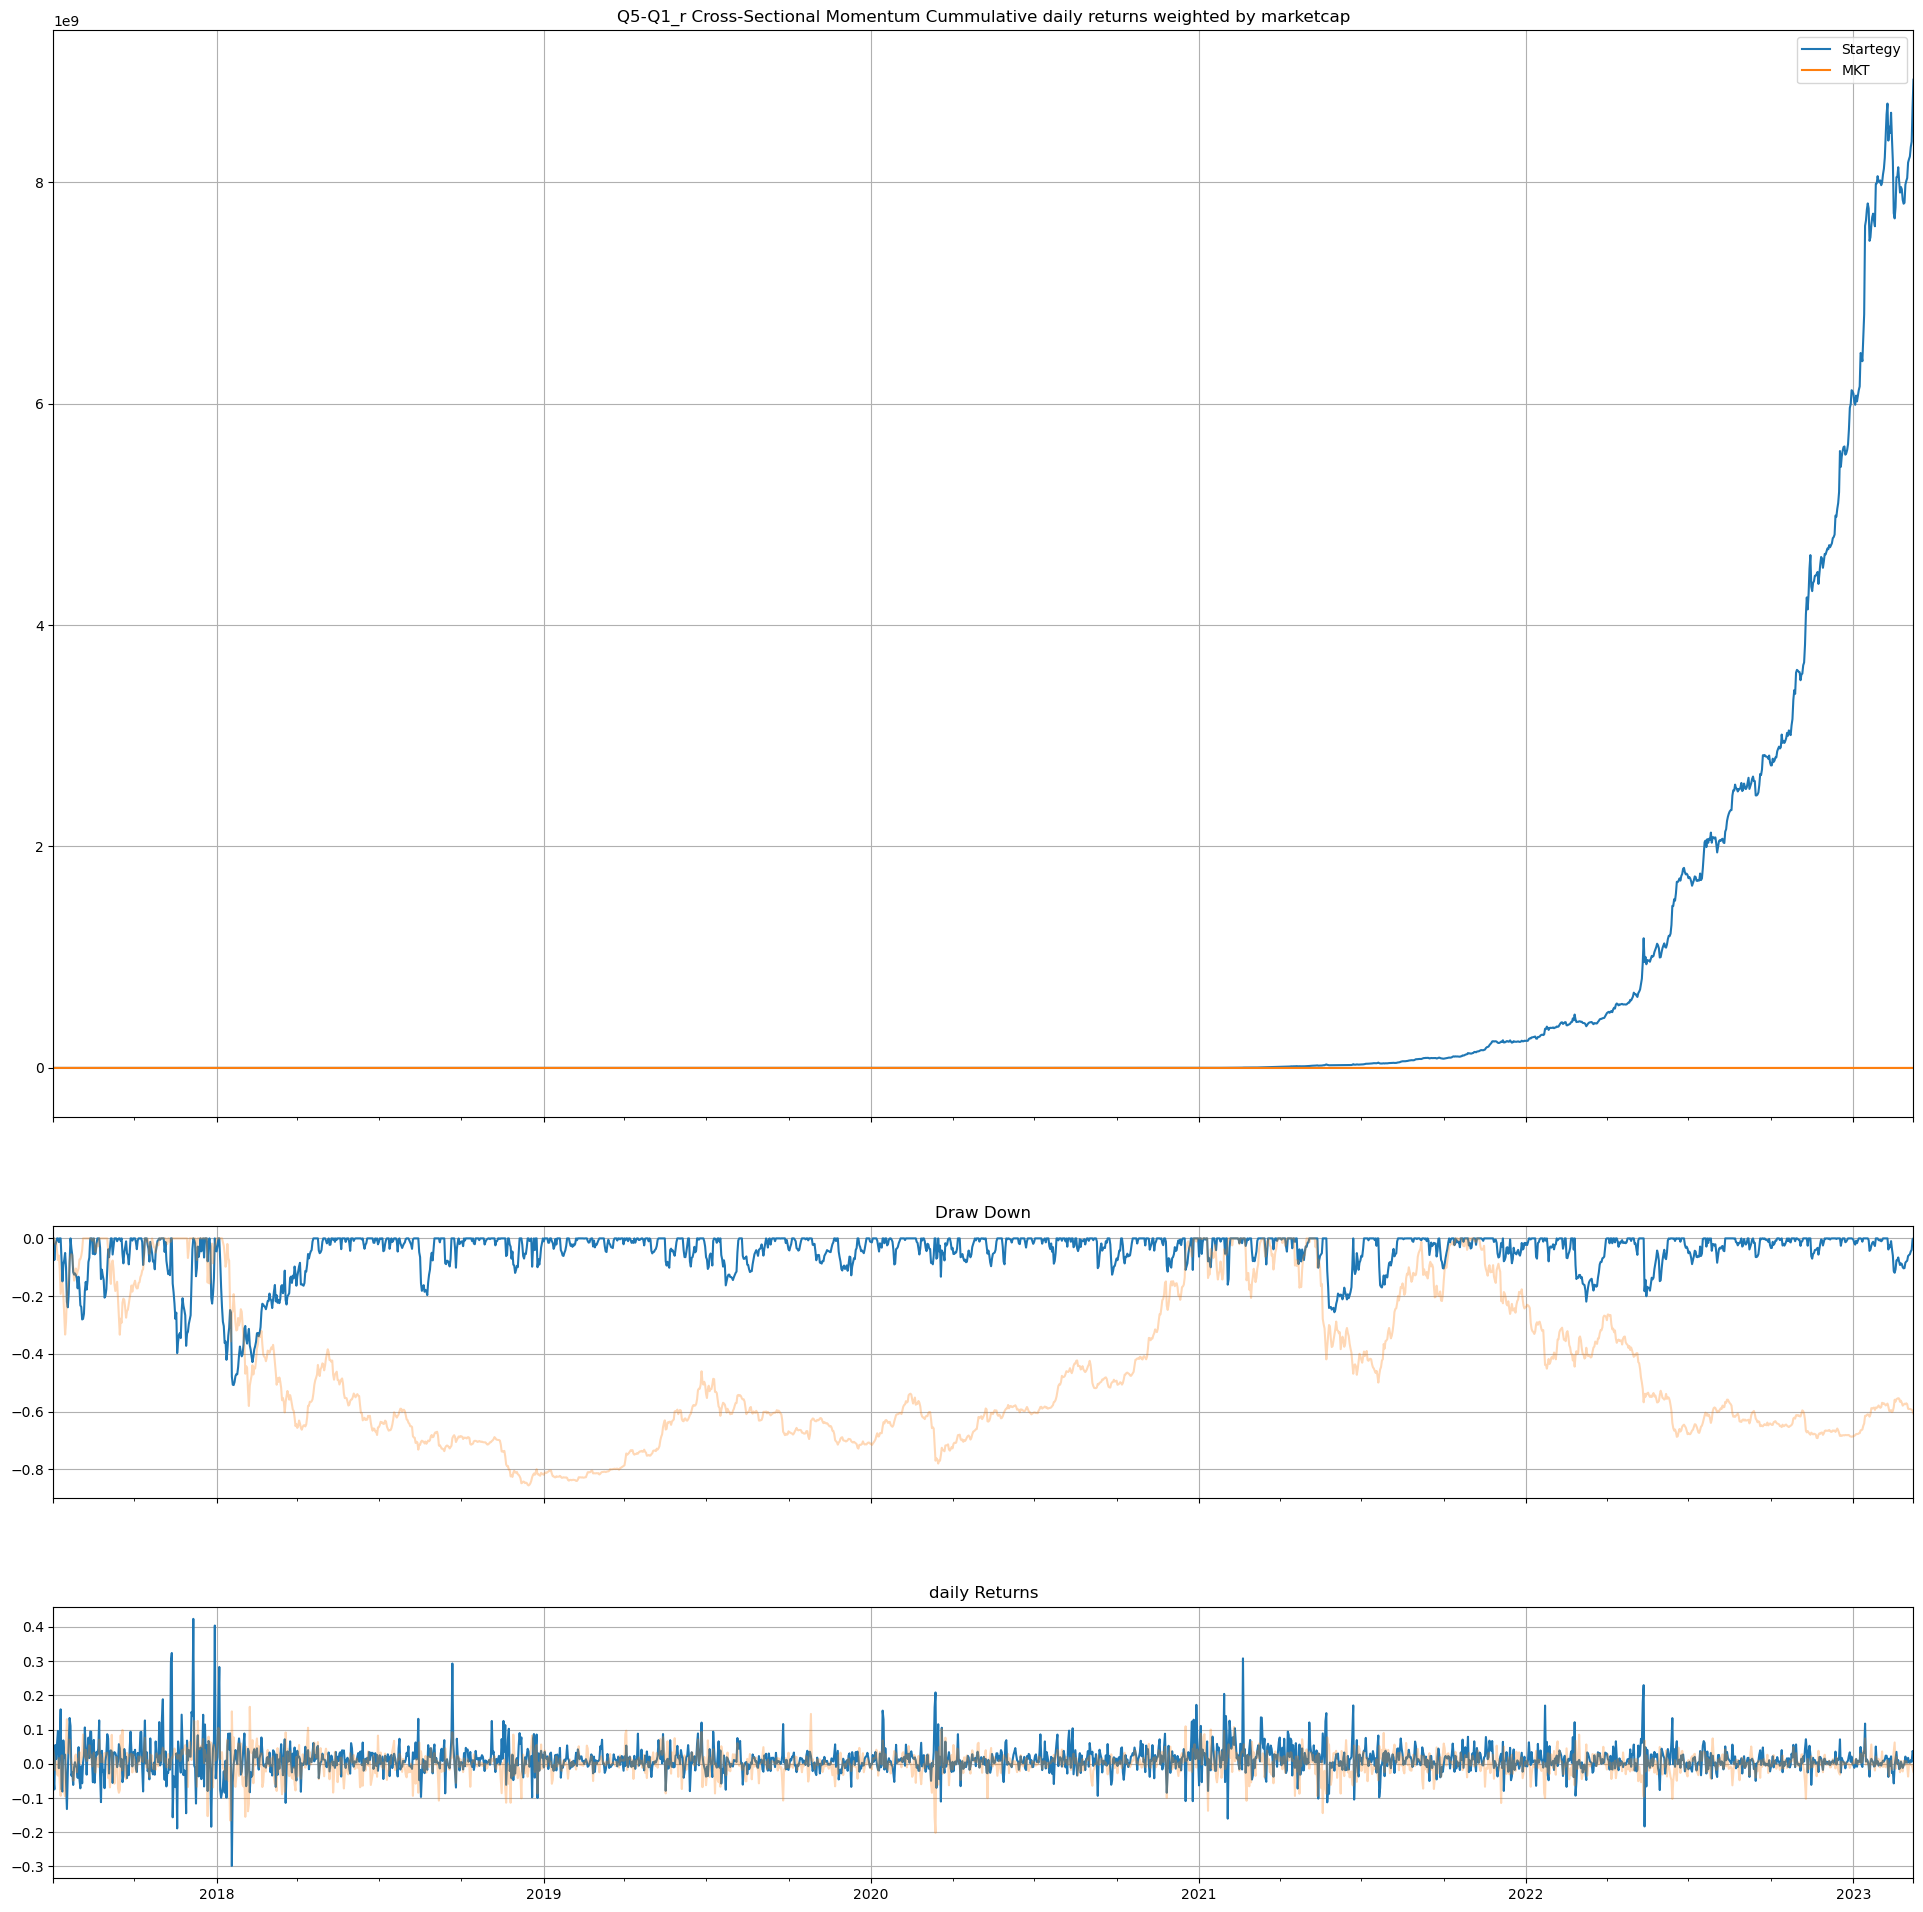

In [31]:
daily_rol.draw_return_result({"Q5-Q1_r":q5_q1_daily_rolling},
                          with_mkt=True
                          )

In [32]:
daily_rol.print_statistics({"Q5-Q1":q5_q1_daily_rolling,
                        "Q5-Q2":q5_q1_daily_rolling,
                        "count":q5_q1_daily_rolling},
                        with_mkt=True
                        )

Q5-Q1        Q5-Q2        MKT
CAGR   5556.591164  5556.591164  72.435724
Mean      0.011984     0.011984   0.002064
STD       0.043011     0.043011   0.033027
Shape     5.323140     5.323140   1.193924

In [33]:
daily_rol.run_alpha_regression({"Q5-Q5":q5_q1_daily_rolling}
                            )

Q5-Q5 Regression Result
                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.008     
Dependent Variable: y                AIC:                -7185.9706
Date:               2023-03-31 21:03 BIC:                -7174.6942
No. Observations:   2076             Log-Likelihood:     3595.0    
Df Model:           1                F-statistic:        17.03     
Df Residuals:       2074             Prob (F-statistic): 3.83e-05  
R-squared:          0.008            Scale:              0.0018358 
---------------------------------------------------------------------
             Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
---------------------------------------------------------------------
const        0.0122     0.0009   12.9767   0.0000    0.0104    0.0141
0           -0.1175     0.0285   -4.1267   0.0000   -0.1734   -0.0617
-------------------------------------------------------------------
Omnibus:              982.010   

In [34]:
pd.concat([mkt_index.loc["2021":], t.loc["2021":], q5_daily["Q1"].loc["2021":].shift(1), q5_daily["Q5"].loc["2021":].shift(1)], axis=1, keys=["MKT","Q1","Q5",'T'])

NameError: name 't' is not defined